In [ ]:
%%capture
!pip install netcdf4 colorcet
import os, fnmatch, shutil, numpy as np, pandas as pd, xarray as xr, scipy as sc, scipy.stats as st
import pylab as plt, plotly.express as px, seaborn as sns, colorcet as cc, altair as alt
from matplotlib.gridspec import GridSpec; from matplotlib.colors import from_levels_and_colors as flc
import cv2; from google.colab.patches import cv2_imshow
%load_ext google.colab.data_table 

!pip install --upgrade zarr gcsfs cftime nc-time-axis
import fsspec, zarr, gcsfs; gcs = gcsfs.GCSFileSystem( token = 'anon' )

!apt-get -qq install libgeos-dev
!pip install -qq https://github.com/matplotlib/basemap/archive/master.zip
from mpl_toolkits.basemap import Basemap, maskoceans

def rgb2hex( rgbstring ): 
    s = rgbstring.split( '(' )[1].split( ',' )
    return "#{0:02x}{1:02x}{2:02x}".format(max(0,min(np.int(s[0]),255)),max(0,min(np.int(s[1]),255)),max(0,min(np.int(s[2].split(')')[0]),255)))

def hex2rgb( value ):
    value = value.lstrip( '#' )
    return tuple(int(value[i:i + len(value) // 3], 16) for i in range(0, len(value), len(value) // 3))

from sklearn.neighbors import KernelDensity
def skkde( x, x_grid, bandwidth = 0.2, **kwargs ):
    kde_skl = KernelDensity( bandwidth = bandwidth, **kwargs )
    kde_skl.fit( x[:, np.newaxis] )
    log_pdf = kde_skl.score_samples( x_grid[:, np.newaxis] )
    return np.exp( log_pdf )

### Stats --> R ###
%load_ext rpy2.ipython
from rpy2.robjects.packages import importr
utils = importr( 'utils' )
utils.install_packages( 'lfe', repos = 'https://cloud.r-project.org' )
%R library( tidyverse )
%R library( broom     ) 
%R library( lfe       )

def get_stars( x ):
    if x < 0.001: y = '***' 
    elif (x > 0.001) & (x < 0.01): y = '**' 
    elif (x > 0.01) & (x < 0.05): y = '*'
    elif (x > 0.05) & (x < 0.1): y = '.'
    else: y = ''
    return y 

from google.colab import drive; drive.mount( '/content/drive' )

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWiI9D8gkdkd7KjY-jGXmKgcEC4ZAWmC9G4wEa-rIWvWOdQNrE_9SXw


In [1]:
### Stats --> R ###
%load_ext rpy2.ipython
from rpy2.robjects.packages import importr
utils = importr( 'utils' )
utils.install_packages( 'lfe', repos = 'https://cloud.r-project.org' )
%R library( tidyverse )
%R library( broom     ) 
%R library( lfe       )

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘zoo’, ‘Formula’, ‘xtable’, ‘sandwich’


R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/zoo_1.8-10.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 808943 bytes (789 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[w

'lfe','Matrix','broom',...,'datasets','methods','base'


In [ ]:
!pip install xarray==0.17.0

# load in final data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data/livestock/final_final_lit.csv')
df = df[['Records included in breakpoint calculation', 'Citation', 'Reference','recordID', 'Year', 
         'Region', 'Country', 'Sub-country level', 'lat', 'lon', 'Baseline THI FAO weighted']]
df = df[df['Baseline THI FAO weighted']=='x']
df = df.replace({'USA':'United States'})
country_list = df.Country.unique()

era = xr.open_dataset('/content/drive/MyDrive/data/livestock/ERA5/era_doy_media_new.nc4')
era = era.THI.values
erad = np.mean(era, axis= 0)

eram = np.empty((12, era.shape[1], era.shape[2]))
for i in range(12): eram[i,:,:] = np.mean( era[i:(i*30)+30,:,:], axis = 0 ) 
eram = np.max( eram, axis = 0)

erad = cv2.resize(erad, (4320,2160))
eram = cv2.resize(eram, (4320,2160))

img = cv2.imread('/content/drive/My Drive/data/livestock/FAO_distribution/6_Ct_2010_Aw.tif', cv2.IMREAD_UNCHANGED)
area = cv2.imread('/content/drive/My Drive/data/livestock/FAO_distribution/8_Areakm.tif', cv2.IMREAD_UNCHANGED)
img = img / area
img[img<1] = 0
cows = np.empty_like(img)
cows[:,2160:] = img[:,:2160]
cows[:,:2160] = img[:,2160:]

countries = xr.open_dataarray('/content/drive/MyDrive/data/area_masks/gadm36_level0_FAO_animal_res.nc4')
countries = np.flip(countries, axis = 0)

dfc =  pd.read_csv( '/content/drive/MyDrive/data/area_masks/gadm36_level0_codes.csv', sep = ',' )

dfout = []
for country in country_list:
    ids = dfc[dfc.NAME_0 == country].CODE.values[0]
    erad_temp = np.ma.masked_where( countries != ids , erad).harden_mask()
    eram_temp = np.ma.masked_where( countries != ids , eram).harden_mask()
    cows_temp = np.ma.masked_where( countries != ids , cows).harden_mask()
    temp1 = np.average(erad_temp, weights=cows_temp)
    temp2 = np.average(eram_temp, weights=cows_temp)
    dfout.append( {'Country': country, 'thi_hist': temp1,  'thi_maxmonth': temp2 } )

dfout = pd.DataFrame( dfout )
dfout

df = pd.read_csv('/content/drive/MyDrive/data/livestock/final_final_lit.csv')
df = df[['Records included in breakpoint calculation', 'Citation', 'Reference','recordID', 'Year', 
         'Region', 'Country', 'Sub-country level', 'lat', 'lon', 'Baseline THI FAO weighted', 
         'Calculated threshold', 'Monotonic slope ','Time period',	'Tmean_or_Tmax',
         'Mortality (Y/N)','Fertility (Y/N)','Production (Y/N)', 'Breed']]

df = df[df['Records included in breakpoint calculation']=='x']
df = df.dropna(subset=['Calculated threshold'])
df = df[df['Calculated threshold']!='na']
df = df[df.Citation != 'Bellagi et al 2017']
df = df[df.Citation != 'Bohmanova et al 2007']
df = df[df.Citation != 'Du Preez and Willemse 1994']
dft = df[df['Baseline THI FAO weighted']=='x']
dft = dft.replace({'USA':'United States'})
dft = pd.merge(dft, dfout, on=['Country'])
df2 = df[df['Baseline THI FAO weighted']!='x']

era = xr.open_dataset('/content/drive/MyDrive/data/livestock/ERA5/era_doy_media_new.nc4')
lat = era.lat.values
lon = era.lon.values
erad = era.mean(dim='dayofyear')
era = era.THI.values

eram = np.empty((12,era.shape[1], era.shape[2]))
for i in range(12): eram[i,:,:] = np.mean( era[i:(i*30)+30,:,:], axis = 0 ) 
eram = np.max(eram, axis = 0)
eram = xr.DataArray( data = eram, dims = ['lat', 'lon'], coords = dict( lat=(["lat"], lat), lon=(["lon"], lon)) )

dftemp = []
for i,row in df2.iterrows():
    if row.lon < 0: lon = 360 + row.lon
    else: lon = row.lon
    temp1 = np.asarray([erad.sel(lat = row.lat, method = 'nearest').sel(lon = lon, method = 'nearest').THI.values])[0]
    temp2 = np.array([eram.sel(lat = row.lat, method = 'nearest').sel(lon = lon, method = 'nearest').values])[0]
    dftemp.append( { 'recordID':row.recordID,'thi_hist': temp1, 'thi_maxmonth':temp2 } )

dftemp = pd.DataFrame( dftemp )
df2 = pd.merge(df2, dftemp, on=['recordID'])

df = pd.concat([dft,df2])
df = df.sort_values('thi_hist', ascending = False)
df.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

overflow encountered in true_divide



,Records included in breakpoint calculation,Citation,Reference,recordID,Year,Region,Country,Sub-country level,lat,lon,Baseline THI FAO weighted,Calculated threshold,Monotonic slope,Time period,Tmean_or_Tmax,Mortality (Y/N),Fertility (Y/N),Production (Y/N),Breed,thi_hist,thi_maxmonth
75,x,Santana et al 2018,"Santana, M. L. et al., 2018: Genetic variation...",sant3,2018,Central and South America,Brazil,"three states (São Paulo, Mato Grosso do Sul an...",-10.0,-52.0,NaN,85.60,NaN,day,mean,N,Y,N,Nelore,75.042358,75.090736
26,x,Santana et al 2015,"Santana, M. L. et al., 2015: Detrimental effec...",sant1,2015,Central and South America,Brazil,throughout,-10.0,-52.0,x,ns,NaN,day,mean,N,N,Y,Gir,72.476119,74.886161
32,x,Mayer et al 1999,"Mayer, D. G., T. M. Davison, N. N. Jonsson and...",may3_MY_b1,1999,Oceania,Australia,Atherton Tablelands,-17.0,145.0,NaN,78.50,NaN,day,max,N,N,Y,Holstein,69.724678,74.582840


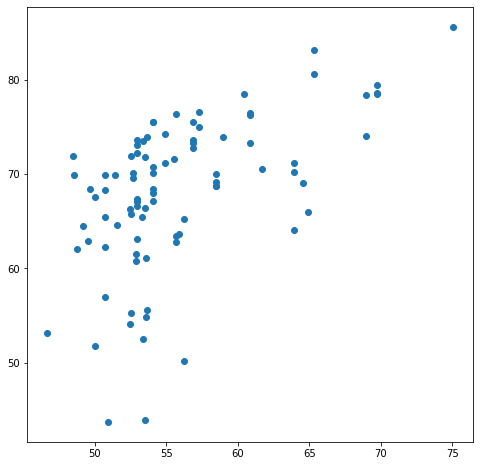

In [ ]:
df = df.rename(columns={'Calculated threshold':'breakpoint','Monotonic slope ':'ms','Mortality (Y/N)': 'Mortality', 'Fertility (Y/N)': 'Fertility', 
                        'Production (Y/N)': 'Production', 'Country':'country', 'thi_hist':'thimean','thi_maxmonth':'thimaxmonth'} )
df.breakpoint = pd.to_numeric(df.breakpoint, errors='coerce')
df.thimaxmonth = pd.to_numeric(df.thimaxmonth, errors='coerce')
df.thimean = pd.to_numeric(df.thimean, errors='coerce')
fig = plt.figure( figsize = ( 8, 8 ) )
plt.scatter(df.thimean, df.breakpoint)

In [ ]:
df = df.replace({'ns':np.nan})
df = df.replace({'ms':np.nan})

mort = df[df['Mortality (Y/N)'] == 'Y' ]
fer = df[df['Fertility (Y/N)'] == 'Y' ]
pro = df[df['Production (Y/N)'] == 'Y']
print(mort['Calculated threshold'].dropna().median())
print(fer['Calculated threshold'].dropna().median())
print(pro['Calculated threshold'].dropna().median())
print(df['Calculated threshold'].dropna().median())

In [ ]:
df = df[['Country', 'Calculated threshold', 'Monotonic slope ', 'thi_hist','thi_maxmonth','Mortality (Y/N)','Fertility (Y/N)','Production (Y/N)', 'Breed']]
df = df.rename(columns={'Calculated threshold':'breakpoint','Monotonic slope ':'ms','Mortality (Y/N)': 'Mortality', 'Fertility (Y/N)': 'Fertility', 
                        'Production (Y/N)': 'Production', 'Country':'country', 'thi_hist':'thimean','thi_maxmonth':'thimaxmonth'} )
df.breakpoint = pd.to_numeric(df.breakpoint, errors='coerce')
df.thimaxmonth = pd.to_numeric(df.thimaxmonth, errors='coerce')
df.thimean = pd.to_numeric(df.thimean, errors='coerce')

temp = []
for i, row in df.iterrows():
    if np.isnan(row.breakpoint) == True: temp.append(row.ms)
    else:  temp.append(row.breakpoint)

df['sensitivity'] = temp

df1 = df[df.Mortality == 'Y']
df1['kind'] = 'M'
df2 = df[df.Fertility == 'Y']
df2['kind'] = 'F'
df3 = df[df.Production == 'Y']
df3['kind'] = 'P'
df = pd.concat( [df1, df2, df3] )

df = df[['country','breakpoint','sensitivity','thimean','thimaxmonth','kind','Breed']]
dfh = df[df.Breed == 'Holstein']
dfh = dfh[['country','breakpoint','thimean','thimaxmonth','kind']].dropna()
dfs = df[['country','sensitivity','thimean','thimaxmonth','kind']].dropna()
df = df[['country','breakpoint','thimean','thimaxmonth','kind']].dropna()
df.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

13    50.714696
14    50.714696
15    50.714696
16    50.714696
17    50.714696
        ...    
35    60.879116
36    68.975929
71    63.889172
72    63.889172
73    63.889172
Name: thimean, Length: 90, dtype: float64

In [ ]:
dfs

,country,sensitivity,thimean,thimaxmonth,kind
13,Netherlands,62.20,50.714696,52.619398,M
14,Netherlands,57.00,50.714696,52.619398,M
15,Netherlands,69.91,50.714696,52.619398,M
16,Netherlands,68.30,50.714696,52.619398,M
17,Netherlands,65.43,50.714696,52.619398,M
...,...,...,...,...,...
38,Australia,74.00,68.975929,75.809097,P
71,Costa Rica,64.00,63.889172,64.093994,P
72,Costa Rica,70.16,63.889172,64.093994,P
73,Costa Rica,71.16,63.889172,64.093994,P


In [ ]:
%R -i df
#%R df$kind  <- as.factor( df$kind )
#%R df$country <- as.factor( df$country )

dfm = pd.DataFrame({})
%R out <- tidy( felm( breakpoint ~  thimean | country | 0 | country , data = df ) )
%R -o out 
out['model'] = 'thimean | country FE'
dfm = pd.concat( ( dfm, out ) ) 

%R out <- tidy( felm( breakpoint ~  thimaxmonth | country | 0 | country , data = df ) )
%R -o out 
out['model'] = 'thimaxmonth | country FE'
dfm = pd.concat( ( dfm, out ) ) 

%R out <- tidy( felm( breakpoint ~  thimean | kind + country | 0 | kind , data = df ) )
%R -o out 
out['model'] = 'thimean | impact type + country FE'
dfm = pd.concat( ( dfm, out ) ) 

%R out <- tidy( felm( breakpoint ~  thimaxmonth | kind + country | 0 | kind , data = df ) )
%R -o out 
out['model'] = 'thimaxmonth | impact type + country FE'
dfm = pd.concat( ( dfm, out ) ) 

%R -i dfs
#%R dfs$kind  <- as.factor( dfs$kind )
#%R dfs$country <- as.factor( dfs$country )

%R out <- tidy( felm( sensitivity ~  thimean | country | 0 | country , data = dfs ) )
%R -o out 
out['model'] = '(sensitity) thimean | country FE'
dfm = pd.concat( ( dfm, out ) ) 

%R out <- tidy( felm( sensitivity ~  thimaxmonth | country | 0 | country , data = dfs ) )
%R -o out 
out['model'] = '(sensitity) thimaxmonth | country FE'
dfm = pd.concat( ( dfm, out ) ) 

%R out <- tidy( felm( sensitivity ~  thimean | kind + country | 0 | kind , data = dfs ) )
%R -o out 
out['model'] = '(sensitity) thimean | impact type + country FE'
dfm = pd.concat( ( dfm, out ) ) 

%R out <- tidy( felm( sensitivity ~  thimaxmonth | kind + country | 0 | kind , data = dfs ) )
%R -o out 
out['model'] = '(sensitity) thimaxmonth | impact type + country FE'
dfm = pd.concat( ( dfm, out ) ) 

dfm['stars'] = dfm['p.value'].apply(get_stars)

%R -i dfh
#%R dfh$kind  <- as.factor( dfh$kind )
#%R dfh$country <- as.factor( dfh$country )

%R out <- tidy( felm( breakpoint ~  thimean | country | 0 | country , data = dfh ) )
%R -o out 
out['model'] = '(Holstein) thimean | country FE'
dfm = pd.concat( ( dfm, out ) ) 

%R out <- tidy( felm( breakpoint ~  thimaxmonth | country | 0 | country , data = dfh ) )
%R -o out 
out['model'] = '(Holstein) thimaxmonth | country FE'
dfm = pd.concat( ( dfm, out ) ) 

%R out <- tidy( felm( breakpoint ~  thimean | kind + country | 0 | kind , data = dfh ) )
%R -o out 
out['model'] = '(Holstein) thimean | impact type + country FE'
dfm = pd.concat( ( dfm, out ) ) 

%R out <- tidy( felm( breakpoint ~  thimaxmonth | kind + country | 0 | kind , data = dfh ) )
%R -o out 
out['model'] = '(Holstein) thimaxmonth | impact type + country FE'
dfm = pd.concat( ( dfm, out ) ) 

dfm['stars'] = dfm['p.value'].apply(get_stars)
dfm

,term,estimate,std.error,statistic,p.value,model,stars
1,thimean,0.303906,0.082141,3.699828,0.002671,thimean | country FE,**
1,thimaxmonth,0.381282,0.144424,2.640026,0.020395,thimaxmonth | country FE,*
1,thimean,0.292009,0.058155,5.021198,0.037449,thimean | impact type + country FE,*
1,thimaxmonth,0.373054,0.115829,3.220729,0.084381,thimaxmonth | impact type + country FE,.
1,thimean,0.351925,0.274185,1.283532,0.218781,(sensitity) thimean | country FE,
1,thimaxmonth,0.268385,0.335325,0.800372,0.435989,(sensitity) thimaxmonth | country FE,
1,thimean,0.348306,0.215922,1.613105,0.248058,(sensitity) thimean | impact type + country FE,
1,thimaxmonth,0.258777,0.195863,1.321212,0.317328,(sensitity) thimaxmonth | impact type + countr...,
1,thimean,0.325154,0.133095,2.443031,0.034669,(Holstein) thimean | country FE,*
1,thimaxmonth,0.569174,0.332872,1.709890,0.118078,(Holstein) thimaxmonth | country FE,


In [ ]:
dfm = np.round(dfm, 3)

In [ ]:
dfm

,term,estimate,std.error,statistic,p.value,model,stars
1,thimean,0.304,0.082,3.700,0.003,thimean | country FE,**
1,thimaxmonth,0.381,0.144,2.640,0.020,thimaxmonth | country FE,*
1,thimean,0.292,0.058,5.021,0.037,thimean | impact type + country FE,*
1,thimaxmonth,0.373,0.116,3.221,0.084,thimaxmonth | impact type + country FE,.
1,thimean,0.352,0.274,1.284,0.219,(sensitity) thimean | country FE,
1,thimaxmonth,0.268,0.335,0.800,0.436,(sensitity) thimaxmonth | country FE,
1,thimean,0.348,0.216,1.613,0.248,(sensitity) thimean | impact type + country FE,
1,thimaxmonth,0.259,0.196,1.321,0.317,(sensitity) thimaxmonth | impact type + countr...,
1,thimean,0.325,0.133,2.443,0.035,(Holstein) thimean | country FE,*
1,thimaxmonth,0.569,0.333,1.710,0.118,(Holstein) thimaxmonth | country FE,


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data/livestock/Final_lit_june.csv')
df = df[['Records included in breakpoint calculation','Citation','lat','lon','Calculated breakpoint','Habitat','Included in impact calculation','Impact']]
df = df[df['Records included in breakpoint calculation']=='x']
df = df.dropna(subset=['Calculated breakpoint'])
df = df[df['Calculated breakpoint']!='na']
df = df[df.Citation != 'Bellagi et al 2017']
df = df[df.Citation != 'Bohmanova et al 2007']
df = df[df.Citation != 'Du Preez and Willemse 1994']
df = df[df.Citation != 'Du Preez and Willemse 1994']
df
#mort = df[df['Mortality (Y/N)'] == 'Y' ]
#fer = df[df['Fertility (Y/N)'] == 'Y' ]
#pro = df[df['Production (Y/N)'] == 'Y']
#print(mort.breakpoint.dropna().median())
#print(fer.breakpoint.dropna().median())
#print(pro.breakpoint.dropna().median())

,Records included in breakpoint calculation,Citation,lat,lon,Calculated breakpoint,Habitat,Included in impact calculation,Impact
2,x,Amamou et al 2019,36.20,9.60,ms,Indoor,N,NaN
11,x,Ben Salem and Bouraoui 2009,34.00,9.00,ms,not described,N,-1
13,x,Bernabucci et al 2014,45.13,10.03,73.30,Outdoor,Y,-1.16
14,x,Bernabucci et al 2014,45.13,10.03,72.70,Outdoor,Y,-1.27
15,x,Bernabucci et al 2014,45.13,10.03,75.50,Outdoor,Y,-0.91
...,...,...,...,...,...,...,...,...
243,x,Sanchez et al 2009,40.00,-100.00,64.20,not described,Y,-0.15
248,x,Santana et al 2016b,-21.90,-47.60,ms,not described,Y,-0.23
249,x,Santana et al 2018,-10.00,-52.00,85.60,Outdoor,N,-0.009
251,x,Schuller et al 2014,51.97,11.47,68.40,Indoor,N,-0.49


In [ ]:
df['Calculated breakpoint'] = pd.to_numeric(df['Calculated breakpoint'], errors='coerce')

In [ ]:
df[df['Calculated breakpoint']>74].shape

(17, 40)

In [ ]:
df[df['Calculated breakpoint']<74].shape

(73, 40)

In [ ]:
73/90

0.8111111111111111

In [ ]:
78/95

0.8210526315789474

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data/livestock/Final_lit_june.csv')
df = df[['Records included in breakpoint calculation','Citation','lat','lon','Calculated breakpoint','Habitat','Included in impact calculation','Impact']]
dfm = df[df['Included in impact calculation']=='Y']
dfb = df[df['Records included in breakpoint calculation']=='x']
df = df[df.Citation != 'Bellagi et al 2017']
df = df[df.Citation != 'Bohmanova et al 2007']
df = df[df.Citation != 'Du Preez and Willemse 1994']

df = pd.concat([dfm,dfb])

### get baseline climate info from the HADisd ###
sta = pd.read_fwf('/content/drive/My Drive/data/livestock/hadisd_station_fullinfo_v311_202001p.txt',
                  colspecs = [(0,11),(12,42),(43,50),(51,59),(60,67),(68,78),(79,89)],
                  names = ['ID','name','lat','lon','elv','start_date','end_date'] )
sta = pd.read_fwf('/content/drive/My Drive/data/livestock/hadisd_station_info_v311_202008p.txt',
                  colspecs = [(0,11),(12,19),(20,29),(30,39)], names = ['ID','lat','lon','elv'] )

sta = sta.dropna()
new = sta.copy()

def get_path(sid):
    files = ['080000-099999','000000-029999','030000-049999','450000-499999','650000-699999','400000-449999',
            '350000-399999','300000-349999','200000-249999','250000-299999','100000-149999','150000-199999',
            '050000-079999','550000-599999','600000-649999','500000-549999','700000-709999','720000-722999',
            '710000-719999','723000-723999','726000-726999','725000-725999','724000-724999','730000-799999',
            '800000-849999','950000-999999','900000-949999','850000-899999','727000-729999']

    bins = np.zeros((len(files),2))
    for i, file in enumerate(files): bins[i,:] = np.array(file.split('-'), dtype=int) 

    sidn = np.int(sid[:6])
    for i,j in bins: 
        if (sidn > i) & (sidn < j): out = i,j
        else: pass
    
    b1 = out[0].astype(int).astype(str)
    b2 = out[1].astype(int).astype(str)

    if len(b1) == 5: 
        b1 = '0'+ b1
        b2 = '0'+ b2
    else: pass

    path = f'/content/drive/My Drive/data/livestock/HadISD/WMO_{b1}-{b2}_heat_stress/hadisd.3.1.1.202008p_19310101-20200901_{sid+sid[-1]}_heat_stress.nc'
    ds = xr.open_dataset( path )
    ds = ds.temperature_humidity_index

    ds = ds.where( (ds > 0) & (ds < 150) )
    thimean  = ds.resample( time = '1D' ).mean().mean().values
    return thimean

l = []
for index, row in df.iterrows():
    new['latlon'] = np.abs( new.lat-row.lat ) + np.abs( new.lon-row.lon )
    new.sort_values( 'latlon' , inplace=True)
    try: l.append(get_path(new.iloc[0].ID))
    except: 
        try: l.append(get_path(new.iloc[1].ID))
        except: 
            try: l.append(get_path(new.iloc[2].ID))
            except: 
                try: l.append(get_path(new.iloc[3].ID))
                except:
                    try: l.append(get_path(new.iloc[4].ID))
                    except: 
                        try: l.append(et_path(new.iloc[5].ID))
                        except: l.append(get_path(new.iloc[6].ID))

l = np.array(l)
df['thimean'] = l
df.to_csv('/content/drive/My Drive/data/livestock/final_with_month_removed.csv', index = False )

In [ ]:
df = pd.read_csv('/content/drive/My Drive/data/livestock/final_for_michelle_boxplot.csv' )
split = df.thimean.median()

df1 = df.copy()
df1['climate'] = 'all records'
df2 = df[df.thimean > split]
df2['climate'] = 'hot'
df3 = df[df.thimean < split]
df3['climate'] = 'cold'
df = pd.concat([df1,df2,df3])

df['Calculated breakpoint'] = pd.to_numeric(df['Calculated breakpoint'], errors='coerce')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df['Impact'] = pd.to_numeric(df['Impact'], errors='coerce')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



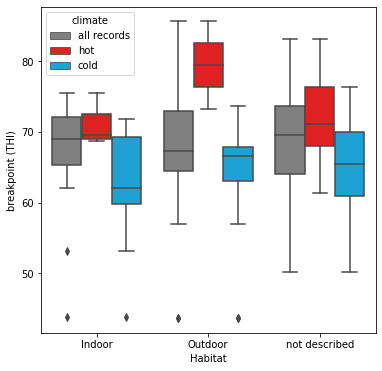

In [ ]:
plt.close('all')

fig = plt.figure( figsize = ( 6, 6 ) )
my_pal = {"all records": "gray", "hot": "#ff0102", "cold":"#00b0f1"}
sns.boxplot(df.Habitat,  df['Calculated breakpoint'], hue = df.climate , palette=my_pal, width=0.8)#, notch = True)
plt.ylabel('breakpoint (THI)')

plt.savefig( '/content/drive/My Drive/figures/livestock/Figure1c.png', dpi = 700, bbox_inches = 'tight', pad_inches = 0.01 )

In [ ]:
#df = pd.read_csv('/content/drive/My Drive/data/livestock/final_for_michelle_boxplot.csv' )
df = pd.read_csv('/content/drive/MyDrive/data/livestock/Final_lit_june.csv')
df['Calculated breakpoint'] = pd.to_numeric(df['Calculated breakpoint'], errors='coerce')
df = df[df.Citation != 'Bellagi et al 2017']
df = df[df.Citation != 'Bohmanova et al 2007']
df = df[df.Citation != 'Du Preez and Willemse 1994']
dfi = df[df.Habitat == 'Indoor']
datai = dfi['Calculated breakpoint'].dropna().values
dfi = df[df.Habitat == 'Outdoor']
datao = dfi['Calculated breakpoint'].dropna().values
print(np.median(datao))
st.t.interval(alpha=0.95, df=len(datao)-1, loc=np.median(datao), scale=st.sem(datao))

67.225


(63.38462265395309, 71.0653773460469)

In [ ]:
print(np.median(datai))
st.t.interval(alpha=0.95, df=len(datai)-1, loc=np.median(datai), scale=st.sem(datai))

68.7


(63.40647788702024, 73.99352211297978)

In [ ]:
print(np.std(datao))

7.99790939871164


In [ ]:
19+16

35

In [ ]:
print(np.std(datai))

7.679285588309266


In [ ]:
st.median_test(datai, datao, ties='above')

(1.6519831730769226, 0.19868922544221868, 68.4, array([[ 9,  8],
        [ 4, 12]]))

In [ ]:
st.median_test(datai, datao, ties='above')

(2.050001807403124, 0.15220600909633356, 68.7, array([[13, 11],
        [ 6, 15]]))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



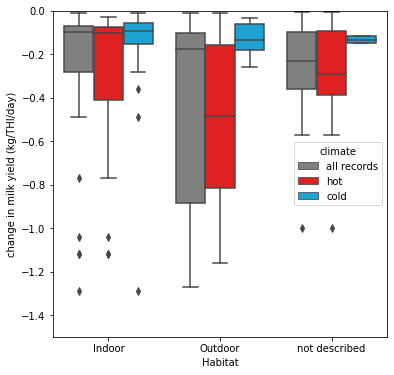

In [ ]:
plt.close('all')

fig = plt.figure( figsize = ( 6, 6 ) )
my_pal = {"all records": "gray", "hot": "#ff0102", "cold":"#00b0f1"}
sns.boxplot(df.Habitat,  df['Impact'], hue = df.climate , palette=my_pal, width=0.8)#, notch = True)
plt.ylabel('change in milk yield (kg/THI/day)')
plt.ylim(-1.5,0)

plt.savefig( '/content/drive/My Drive/figures/livestock/Figure1c.png', dpi = 700, bbox_inches = 'tight', pad_inches = 0.01 )

In [ ]:
gs = GridSpec( 2, 3, height_ratios = [1, 0.05], width_ratios = [0.05, 1, 0.55] )
gs.update( wspace = 0, hspace = 0.2 )

ax1 = plt.subplot( gs[0,:] )


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data/livestock/Final_lit_june.csv')
df = df[['Records included in breakpoint calculation','Country','lat','lon','Type','Breed','Mortality (Y/N)','Fertility (Y/N)','Production (Y/N)','Calculated breakpoint','Monotonic slope ', 'Source of weather data']]
df = df[df['Records included in breakpoint calculation']=='x']
df = df.rename(columns={'Calculated breakpoint':'breakpoint','Monotonic slope ':'ms'})

df = df[df['Source of weather data']=='Weather station']
df.breakpoint = pd.to_numeric(df.breakpoint, errors='coerce')

data = df.breakpoint.dropna().values
print(np.median(data))
st.t.interval(alpha=0.95, df=len(data)-1, loc=np.median(data), scale=st.sem(data))

68.925


(67.36164214791471, 70.48835785208529)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data/livestock/Final_lit_june.csv')
df

NameError: ignored

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data/livestock/Final_lit_june.csv')
df = df[['Records included in breakpoint calculation','Citation','Country','lat','lon','Type','Breed','Mortality (Y/N)','Fertility (Y/N)','Production (Y/N)','Calculated breakpoint','Monotonic slope ']]
df = df[df['Records included in breakpoint calculation']=='x']
df = df[df.Citation != 'Bellagi et al 2017']
df = df[df.Citation != 'Bohmanova et al 2007']
df = df[df.Citation != 'Du Preez and Willemse 1994']
df = df[df.Citation != 'Igono et al 1992']
df = df[df.Citation != 'Ben Salem and Bouraoui 2009']

df = df.rename(columns={'Calculated breakpoint':'breakpoint','Monotonic slope ':'ms'})

df.breakpoint = pd.to_numeric(df.breakpoint, errors='coerce')
mort = df[df['Mortality (Y/N)'] == 'Y' ].breakpoint.dropna().values
fer = df[df['Fertility (Y/N)'] == 'Y' ].breakpoint.dropna().values
pro = df[df['Production (Y/N)'] == 'Y'].breakpoint.dropna().values
#df.breakpoint.median()
x = np.concatenate((df.breakpoint,df.ms))
x = x[~np.isnan(x)]
np.median(x)


68.3

In [ ]:
data = df.breakpoint.dropna().values
np.quantile(data, 0.95)

78.55

In [ ]:
data = df.breakpoint.dropna().values
print(np.median(data))
st.t.interval(alpha=0.95, df=len(data)-1, loc=np.median(data), scale=st.sem(data))

70.5


(68.07032589252994, 72.92967410747006)

In [ ]:
mort 65.79 (63.4, 68.1)
fer 68.4 (61.8, 75.0)
pro 70.5 (68.1, 72.9)


SyntaxError: ignored

In [ ]:
print(np.median(mort))
print(np.median(fer))
print(np.median(pro))

65.79
68.4
70.5


In [ ]:
np.quantile( df.breakpoint.dropna().values, [0.95])

array([78.53])

In [ ]:
mort = df[df['Mortality (Y/N)'] == 'Y' ].breakpoint.dropna().values
fer = df[df['Fertility (Y/N)'] == 'Y' ].breakpoint.dropna().values
pro = df[df['Production (Y/N)'] == 'Y'].breakpoint.dropna().values
st.median_test(pro, fer, mort, lambda_="log-likelihood", ties='above')

(3.261317622672874, 0.19580053601288466, 69.0, array([[26,  4, 16],
        [17,  5, 23]]))

In [ ]:
data = df.breakpoint.dropna().values
print(np.median(data))
st.t.interval(alpha=0.95, df=len(data)-1, loc=np.median(data), scale=st.sem(data))

69.0


(67.34411010624251, 70.65588989375749)

In [ ]:
g1 = [10, 14, 14, 18, 20, 22, 24, 25, 31, 31, 32, 39, 43, 43, 48, 49]
g2 = [28, 30, 31, 33, 34, 35, 36, 40, 44, 55, 57, 61, 91, 92, 99]
g3 = [0, 3, 9, 22, 23, 25, 25, 33, 34, 34, 40, 45, 46, 48, 62, 67, 84]
np.median(g1)

28.0

In [ ]:
np.random.rand(100).mean()

0.5541653156946528

In [ ]:
st.median_test(np.random.rand(1000)+10, np.random.rand(1000), lambda_="log-likelihood")

(2755.3874174040516, 0.0, 5.500265726733807, array([[1000,    0],
        [   0, 1000]]))

In [ ]:
st.kruskal(pro, fer, mort)

KruskalResult(statistic=7.799773701697444, pvalue=0.02024420193048547)

In [ ]:
import scipy.stats as st

In [ ]:
import scipy.stats as st
data = pd.to_numeric(df['Calculated threshold']).dropna().values
st.t.interval(alpha=0.95, df=len(data)-1, loc=np.median(data), scale=st.sem(data))

(67.37756103961411, 70.72243896038589)

In [ ]:
pd.to_numeric(data)

AttributeError: ignored

In [ ]:
mort = df[df['Mortality (Y/N)'] == 'Y' ]
fer = df[df['Fertility (Y/N)'] == 'Y' ]
pro = df[df['Production (Y/N)'] == 'Y']
print(mort.breakpoint.dropna().median())
print(fer.breakpoint.dropna().median())
print(pro.breakpoint.dropna().median())

65.79
68.575
70.33


In [ ]:
mort = df[df['Mortality (Y/N)'] == 'Y' ]
fer = df[df['Fertility (Y/N)'] == 'Y' ]
pro = df[df['Production (Y/N)'] == 'Y']
data = mort.breakpoint.dropna()
st.t.interval(alpha=0.95, df=len(data)-1, loc=np.median(data), scale=st.sem(data))

(63.43175853447771, 68.1482414655223)

In [ ]:
mort = df[df['Mortality (Y/N)'] == 'Y' ]
fer = df[df['Fertility (Y/N)'] == 'Y' ]
pro = df[df['Production (Y/N)'] == 'Y']
data = fer.breakpoint.dropna()
st.t.interval(alpha=0.95, df=len(data)-1, loc=np.median(data), scale=st.sem(data))

(62.796161666973646, 74.35383833302636)

In [ ]:
mort = df[df['Mortality (Y/N)'] == 'Y' ]
fer = df[df['Fertility (Y/N)'] == 'Y' ]
pro = df[df['Production (Y/N)'] == 'Y']
data = pro.breakpoint.dropna()
st.t.interval(alpha=0.95, df=len(data)-1, loc=np.median(data), scale=st.sem(data))

(68.0049546348527, 72.6550453651473)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data/livestock/Final_lit_june.csv')
df = df[['Records included in breakpoint calculation','Citation','Country','lat','lon','Type','Breed','Mortality (Y/N)','Fertility (Y/N)','Production (Y/N)','Calculated breakpoint','Monotonic slope ']]
df = df[df['Records included in breakpoint calculation']=='x']
df = df[df.Citation != 'Bellagi et al 2017']
df = df[df.Citation != 'Bohmanova et al 2007']
df = df[df.Citation != 'Du Preez and Willemse 1994']
df

,Records included in breakpoint calculation,Citation,Country,lat,lon,Type,Breed,Mortality (Y/N),Fertility (Y/N),Production (Y/N),Calculated breakpoint,Monotonic slope
2,x,Amamou et al 2019,Tunisia,36.20,9.60,taurine,Holstein,N,N,Y,ms,52.0
11,x,Ben Salem and Bouraoui 2009,Tunisia,34.00,9.00,taurine,Holstein,N,Y,N,ms,55.0
13,x,Bernabucci et al 2014,Italy,45.13,10.03,taurine,Holstein,N,N,Y,73.30,NaN
14,x,Bernabucci et al 2014,Italy,45.13,10.03,taurine,Holstein,N,N,Y,72.70,NaN
15,x,Bernabucci et al 2014,Italy,45.13,10.03,taurine,Holstein,N,N,Y,75.50,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
244,x,Santana et al 2015,Brazil,-10.00,-52.00,indicine,Gir,N,N,Y,na,NaN
248,x,Santana et al 2016b,Brazil,-21.90,-47.60,taurine,Holstein,N,N,Y,ms,54.0
249,x,Santana et al 2018,Brazil,-10.00,-52.00,indicine,Nelore,N,Y,N,85.60,NaN
251,x,Schuller et al 2014,Germany,51.97,11.47,taurine,Holstein,N,Y,N,68.40,NaN


# Figure 1 panel c

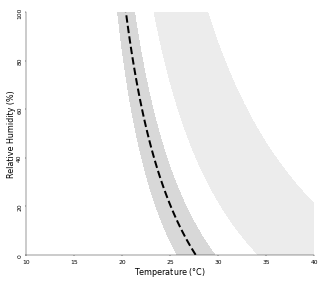

In [ ]:
xx, yy = np.mgrid[10:50:2000j, 0:101:2000j]
thom = (1.8 * xx + 32) - ( (0.55 - 0.0055 * yy) * (1.8 * xx - 26) )
#thom = 0.80*xx + xx*(yy/100) - 1.43*(yy/100) + 46.4

gs = GridSpec( 2, 3, height_ratios = [1, 0.05], width_ratios = [0.05, 1, 0.55] )
gs.update( wspace = 0, hspace = 0.2 )

ax1 = plt.subplot( gs[0,:] )

#plt.contourf( xx, yy, thom, levels = [74,84], hatches = '////////////////', color = 'gray', alpha = 0, zorder = 2)
#plt.contour( xx, yy, thom, levels = [74], linewidths = 1, colors = 'gray',  alpha = 1, zorder = 2)
#plt.contour( xx, yy, thom, levels = [84], linewidths = 1, colors = 'gray',  alpha = 1, zorder = 2)

plt.contourf( xx, yy, thom, levels = [74,84], colors = 'gray', alpha = 0.15, zorder = 2 )
#plt.contour( xx, yy, thom, levels = [74], linewidths = 2, colors = '#434343',  linestyles ='--',  alpha = 1, zorder = 2)

colors = ['#377eb8','#ff7f00','#e41a1c']
#plt.contour( xx, yy, thom, levels = [pro],  linewidths = 2, colors = colors[0], linestyles ='--', alpha = 1, zorder = 2)
#plt.contour( xx, yy, thom, levels = [fer],  linewidths = 2, colors = colors[1], linestyles ='--', alpha = 1, zorder = 2)
#plt.contour( xx, yy, thom, levels = [mort], linewidths = 2, colors = colors[2], linestyles ='--', alpha = 1, zorder = 2)
plt.contourf( xx, yy, thom, levels = [67.15,70.3], colors = 'gray', alpha = 0.3, zorder = 2 )
plt.contour( xx, yy, thom, levels = [68.7], linewidths = 2, colors = 'black', linestyles ='--', alpha = 1, zorder = 2)
#'#00b0f1'

colors = [rgb2hex(i) for i in px.colors.sequential.deep] #dense
per_levels = np.linspace( 5, 95, 13 )
cmap, norm = flc( per_levels, colors )

#plt.contourf( xx, yy, x, levels = per_levels, cmap = cmap, alpha = 0.8, zorder = 0 )

plt.ylim( 0, 100 )
plt.xlim( 10, 40 )
plt.xlabel( 'Temperature ($\degree$C)' )
plt.ylabel( 'Relative Humidity (%)' )
sns.despine( offset = 0, trim = True )
plt.yticks( rotation = 90, va = 'center' )

#ax2 = plt.subplot( gs[1,1] )
#CB = plt.colorbar( cax = ax2, ticks = [5, 20, 35.5, 50, 65.5, 80, 95], orientation = "horizontal" )
#CB.ax.set_xticklabels( ['5','20','35.5','50','65.5','80','95'] )
#CB.ax.tick_params( labelsize = 7 )
#CB.set_label( '% of published onset thresholds', fontsize = 7 )

plt.savefig( '/content/drive/My Drive/figures/livestock/Figure1c.png', dpi = 700, bbox_inches = 'tight', pad_inches = 0 )

# Fig 1 A

In [ ]:
img = cv2.imread('/content/drive/My Drive/data/livestock/FAO_distribution/6_Ct_2010_Aw.tif', cv2.IMREAD_UNCHANGED)
area = cv2.imread('/content/drive/My Drive/data/livestock/FAO_distribution/8_Areakm.tif', cv2.IMREAD_UNCHANGED)
img = img / area
img = np.flip( img, axis = 0 )
img = np.ma.masked_where( img < 0, img )

df = pd.read_csv('/content/drive/My Drive/data/livestock/digitized_breakpoints_connverted.csv')
df = df.rename(columns={'long':'lon'})

df2 = pd.read_csv('/content/drive/My Drive/data/livestock/milk_yield_impact_studies.csv')
#df2 = df2[df2['Included in breakpoint calculation'] != 'x' ]
df2 = df2[['lat','lon','Breakpoint']]
df2 = df2.dropna()
df2['Production'] = 'x'

df = pd.concat([df,df2])

df['lat'].where(df.duplicated( ['lat']), lambda x: x+np.random.randn()*5, inplace=True, axis=0)
df['lon'].where(df.duplicated( ['lon']), lambda x: x+np.random.randn()*5, inplace=True, axis=0)

mort = df[df['Mortality'] == 'x' ]
fer = df[df['Fertility'] == 'x' ]
pro = df[df['Production'] == 'x']

plt.close('all')
fig = plt.figure( figsize = ( 10, 5 ) )

colors = [rgb2hex(i) for i in px.colors.sequential.gray_r][1:]
levels = np.linspace( 1, 100, 11 )
img[ img > 102 ] = 102
cmap, norm = flc( levels = levels, colors = colors, extend = 'max')

gs = GridSpec(2, 3, height_ratios = [1, 0.05], width_ratios = [0.2, 1, 0.2] )
gs.update( wspace = 0, hspace = 0.01)

m = Basemap( projection = 'eck4', lon_0 = 0, resolution = 'l' )
lat = np.linspace( -90, 90, img.shape[0] )
lon = np.linspace( -180, 180, img.shape[1] )
lon2d, lat2d = np.meshgrid( lon, lat )
x, y = m( lon2d, lat2d )

ax1 = plt.subplot( gs[0, 0:3] )
m.drawmapboundary( fill_color = 'white', color = 'white', linewidth = 0.0 )
m.pcolormesh( x, y, img, cmap = cmap, zorder = 10, alpha = 0.7)

scatcolors = ['#377eb8','#ff7f00','#e41a1c']
xa, ya = m( pro.lon.values, pro.lat.values )
plt.scatter( xa, ya, s = 30, facecolors = scatcolors[0], edgecolors = 'white', lw = 0.3, zorder = 20, alpha = 0.8 )

xa, ya = m( fer.lon.values, fer.lat.values )
plt.scatter( xa, ya, s = 30, facecolors = scatcolors[1], edgecolors = 'white', lw = 0.3, zorder = 20, alpha = 0.8 )
xa, ya = m( mort.lon.values, mort.lat.values )
plt.scatter( xa, ya, s = 30, facecolors = scatcolors[2], edgecolors = 'white', lw = 0.3, zorder = 20, alpha = 0.8 )

ax2 = plt.subplot( gs[1, 1] )
CB = plt.colorbar( cax = ax2, orientation = "horizontal" )
CB.ax.tick_params( labelsize = 7 )
CB.set_label( 'Number of animals per km$^2$', fontsize = 7 )

plt.savefig( '/content/drive/MyDrive/figures/livestock/cow_density_map.png', dpi = 700, bbox_inches = 'tight', pad_inches = 0.01 )

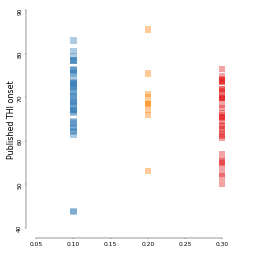

In [ ]:
plt.close('all')
fig = plt.figure( figsize = ( 4, 4 ) )

scatcolors = ['#377eb8','#ff7f00','#e41a1c']

mort = df[df['Mortality (Y/N)'] == 'Y' ]
fer = df[df['Fertility (Y/N)'] == 'Y' ]
pro = df[df['Production (Y/N)'] == 'Y']

plt.scatter( np.full_like(fer.breakpoint.values, 0.2),  fer.breakpoint.values, s = 40, marker = 's', facecolors = scatcolors[1], edgecolors = 'none', lw = 0.3, zorder = 20, alpha = 0.4 )
plt.scatter( np.full_like(pro.breakpoint.values, 0.1),  pro.breakpoint.values, s = 40, marker = 's', facecolors = scatcolors[0], edgecolors = 'none', lw = 0.3, zorder = 20, alpha = 0.4 )
plt.scatter( np.full_like(mort.breakpoint.values, 0.3), mort.breakpoint.values, s =40, marker = 's', facecolors = scatcolors[2], edgecolors = 'none', lw = 0.3, zorder = 20, alpha = 0.4 )

#plt.scatter( np.median(fer.breakpoint.values), 0.2,  marker = '|', s = 100, facecolors = scatcolors[1], edgecolors = 'white', lw = 0.3, zorder = 20, alpha = 1 )
#plt.scatter( np.median(pro.breakpoint.values), 0.1, marker = '|', s = 100, facecolors = scatcolors[0], edgecolors = 'white', lw = 0.3, zorder = 20, alpha = 1 )
#plt.scatter( np.median(mort.breakpoint.values),  0.3, marker = '|', s = 100, facecolors = scatcolors[2], edgecolors = 'white', lw = 0.3, zorder = 20, alpha = 1 )

plt.xlim( 0.05, 0.35 )
plt.ylim( 40, 90 )
plt.ylabel( 'Published THI onset' )
sns.despine( offset = 10, trim = True )
plt.yticks( rotation = 90, va = 'center' )

plt.savefig( '/content/drive/My Drive/figures/livestock/Figure1d.png', dpi = 700, bbox_inches = 'tight', pad_inches = 0 )

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data/livestock/Final_lit_june.csv')
df = df[['Records included in breakpoint calculation','Citation','Country','lat','lon','Type','Breed','Mortality (Y/N)','Fertility (Y/N)','Production (Y/N)','Calculated breakpoint','Monotonic slope ']]
df = df[df['Records included in breakpoint calculation']=='x']
df = df[df.Citation != 'Bellagi et al 2017']
df = df[df.Citation != 'Bohmanova et al 2007']
df = df[df.Citation != 'Du Preez and Willemse 1994']


### get baseline climate info from the HADisd ###
sta = pd.read_fwf('/content/drive/My Drive/data/livestock/hadisd_station_fullinfo_v311_202001p.txt',
                  colspecs = [(0,11),(12,42),(43,50),(51,59),(60,67),(68,78),(79,89)],
                  names = ['ID','name','lat','lon','elv','start_date','end_date'] )
sta = pd.read_fwf('/content/drive/My Drive/data/livestock/hadisd_station_info_v311_202008p.txt',
                  colspecs = [(0,11),(12,19),(20,29),(30,39)], names = ['ID','lat','lon','elv'] )

sta = sta.dropna()
new = sta.copy()

def get_path(sid):
    files = ['080000-099999','000000-029999','030000-049999','450000-499999','650000-699999','400000-449999',
            '350000-399999','300000-349999','200000-249999','250000-299999','100000-149999','150000-199999',
            '050000-079999','550000-599999','600000-649999','500000-549999','700000-709999','720000-722999',
            '710000-719999','723000-723999','726000-726999','725000-725999','724000-724999','730000-799999',
            '800000-849999','950000-999999','900000-949999','850000-899999','727000-729999']

    bins = np.zeros((len(files),2))
    for i, file in enumerate(files): bins[i,:] = np.array(file.split('-'), dtype=int) 

    sidn = np.int(sid[:6])
    for i,j in bins: 
        if (sidn > i) & (sidn < j): out = i,j
        else: pass
    
    b1 = out[0].astype(int).astype(str)
    b2 = out[1].astype(int).astype(str)

    if len(b1) == 5: 
        b1 = '0'+ b1
        b2 = '0'+ b2
    else: pass

    path = f'/content/drive/My Drive/data/livestock/HadISD/WMO_{b1}-{b2}_heat_stress/hadisd.3.1.1.202008p_19310101-20200901_{sid+sid[-1]}_heat_stress.nc'
    ds = xr.open_dataset( path )
    ds = ds.temperature_humidity_index

    ds = ds.where( (ds > 0) & (ds < 150) )
    thimax   = ds.resample( time = '1D' ).max().mean().values
    thimean  = ds.resample( time = '1D' ).mean().mean().values
    thimin   = ds.resample( time = '1D' ).min().mean().values
    thimaxmonth = ds.resample( time = '1M' ).mean().max().values
    thimean3 = ds.resample( time = '3D' ).max().mean().values
    return thimax, thimean, thimin, thimaxmonth, thimean3

l = []
for index, row in df.iterrows():
    new['latlon'] = np.abs( new.lat-row.lat ) + np.abs( new.lon-row.lon )
    new.sort_values( 'latlon' , inplace=True)
    try: l.append(get_path(new.iloc[0].ID))
    except: 
        try: l.append(get_path(new.iloc[1].ID))
        except: 
            try: l.append(get_path(new.iloc[2].ID))
            except: 
                try: l.append(get_path(new.iloc[3].ID))
                except:
                    try: l.append(get_path(new.iloc[4].ID))
                    except: 
                        try: l.append(et_path(new.iloc[5].ID))
                        except: l.append(get_path(new.iloc[6].ID))

l = np.array(l)
df['thimax'] = l[:,0]
df['thimean'] = l[:,1]
df['thimin'] = l[:,2]
df['thimaxmonth'] = l[:,3]
df['thi3dmax'] = l[:,4]

df.to_csv('/content/drive/My Drive/data/livestock/final_digitized_breakpoints_with_min_mean_max_and_month_removed.csv', index = False )

In [ ]:
foo = '/content/drive/My Drive/data/livestock/final_digitized_breakpoints_with_min_mean_max_and_month_removed.csv'
df = pd.read_csv(foo )
df = df.rename(columns={'Calculated breakpoint':'breakpoint','Monotonic slope ':'ms','Mortality (Y/N)': 
                        'Mortality', 'Fertility (Y/N)': 'Fertility', 'Production (Y/N)': 'Production', 'Country':'country'} )
df.breakpoint = pd.to_numeric(df.breakpoint, errors='coerce')

df1 = df[df.Mortality == 'Y']
df1['kind'] = 'M'
df2 = df[df.Fertility == 'Y']
df2['kind'] = 'F'
df3 = df[df.Production == 'Y']
df3['kind'] = 'P'
df = pd.concat([df1, df2, df3])

df = df[['country','breakpoint', 'thimean','thimaxmonth','kind']]
df = df.dropna()


df1 = pd.read_csv( foo )
df1 = df1.rename(columns={'Calculated breakpoint':'breakpoint','Monotonic slope ':'ms','Mortality (Y/N)': 
                        'Mortality', 'Fertility (Y/N)': 'Fertility', 'Production (Y/N)': 'Production', 'Country':'country'} )
df1.breakpoint = pd.to_numeric(df1.ms, errors='coerce')

df1 = df1[df1.Mortality == 'Y']
df1['kind'] = 'M'
df2 = df1[df1.Fertility == 'Y']
df2['kind'] = 'F'
df3 = df1[df1.Production == 'Y']
df3['kind'] = 'P'
df1 = pd.concat([df1, df2, df3])

df1 = df1[['country','breakpoint', 'thimean','thimaxmonth','kind']]
df1 = df1.dropna()

dfs = pd.concat([df,df1])

dfh = pd.read_csv( foo )
dfh = dfh.rename(columns={'Calculated breakpoint':'breakpoint','Monotonic slope ':'ms','Mortality (Y/N)': 
                        'Mortality', 'Fertility (Y/N)': 'Fertility', 'Production (Y/N)': 'Production', 'Country':'country'} )
dfh.breakpoint = pd.to_numeric(dfh.breakpoint, errors='coerce')

df1 = dfh[dfh.Mortality == 'Y']
df1['kind'] = 'M'
df2 = dfh[dfh.Fertility == 'Y']
df2['kind'] = 'F'
df3 = dfh[dfh.Production == 'Y']
df3['kind'] = 'P'
dfh = pd.concat([df1, df2, df3])

dfh = dfh[dfh.Breed == 'Holstein']
dfh = dfh[['country','breakpoint', 'thimean','thimaxmonth','kind']]
dfh = dfh.dropna()
dfh

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

,country,breakpoint,thimean,thimaxmonth,kind
35,Germany,53.10,47.800783,65.213433,F
93,Australia,65.92,65.290659,78.330545,F
94,USA,67.10,58.436780,78.738890,F
95,USA,70.10,61.324652,77.754622,F
96,USA,75.50,67.304663,78.019133,F
97,USA,70.70,61.324652,77.754622,F
98,USA,68.40,61.324652,77.754622,F
107,Germany,68.40,48.682787,67.819764,F
2,Italy,73.30,55.263118,78.024455,P
3,Italy,72.70,55.263118,78.024455,P


In [ ]:
%R -i df
%R df$kind  <- as.factor( df$kind )
%R df$country <- as.factor( df$country )

dfm = pd.DataFrame({})
%R out <- tidy( felm( breakpoint ~  thimean | country | 0 | country , data = df ) )
%R -o out 
out['model'] = 'thimean | country FE'
dfm = pd.concat( ( dfm, out ) ) 

%R out <- tidy( felm( breakpoint ~  thimaxmonth | country | 0 | country , data = df ) )
%R -o out 
out['model'] = 'thimaxmonth | country FE'
dfm = pd.concat( ( dfm, out ) ) 

%R out <- tidy( felm( breakpoint ~  thimean | kind + country | 0 | kind , data = df ) )
%R -o out 
out['model'] = 'thimean | impact type + country FE'
dfm = pd.concat( ( dfm, out ) ) 


%R out <- tidy( felm( breakpoint ~  thimaxmonth | kind + country | 0 | kind , data = df ) )
%R -o out 
out['model'] = 'thimaxmonth | impact type + country FE'
dfm = pd.concat( ( dfm, out ) ) 

%R -i dfs
%R dfs$kind  <- as.factor( dfs$kind )
%R dfs$country <- as.factor( dfs$country )

%R out <- tidy( felm( breakpoint ~  thimean | country | 0 | country , data = dfs ) )
%R -o out 
out['model'] = '(sensitity) thimean | country FE'
dfm = pd.concat( ( dfm, out ) ) 

%R out <- tidy( felm( breakpoint ~  thimaxmonth | country | 0 | country , data = dfs ) )
%R -o out 
out['model'] = '(sensitity) thimaxmonth | country FE'
dfm = pd.concat( ( dfm, out ) ) 

%R out <- tidy( felm( breakpoint ~  thimean | kind + country | 0 | kind , data = dfs ) )
%R -o out 
out['model'] = '(sensitity) thimean | impact type + country FE'
dfm = pd.concat( ( dfm, out ) ) 

%R out <- tidy( felm( breakpoint ~  thimaxmonth | kind + country | 0 | kind , data = dfs ) )
%R -o out 
out['model'] = '(sensitity) thimaxmonth | impact type + country FE'
dfm = pd.concat( ( dfm, out ) ) 

dfm['stars'] = dfm['p.value'].apply(get_stars)

%R -i dfh
%R dfh$kind  <- as.factor( dfh$kind )
%R dfh$country <- as.factor( dfh$country )

%R out <- tidy( felm( breakpoint ~  thimean | country | 0 | country , data = dfh ) )
%R -o out 
out['model'] = '(Holstein) thimean | country FE'
dfm = pd.concat( ( dfm, out ) ) 

%R out <- tidy( felm( breakpoint ~  thimaxmonth | country | 0 | country , data = dfh ) )
%R -o out 
out['model'] = '(Holstein) thimaxmonth | country FE'
dfm = pd.concat( ( dfm, out ) ) 

%R out <- tidy( felm( breakpoint ~  thimean | kind + country | 0 | kind , data = dfh ) )
%R -o out 
out['model'] = '(Holstein) thimean | impact type + country FE'
dfm = pd.concat( ( dfm, out ) ) 

%R out <- tidy( felm( breakpoint ~  thimaxmonth | kind + country | 0 | kind , data = dfh ) )
%R -o out 
out['model'] = '(Holstein) thimaxmonth | impact type + country FE'
dfm = pd.concat( ( dfm, out ) ) 

dfm['stars'] = dfm['p.value'].apply(get_stars)
dfm

,term,estimate,std.error,statistic,p.value,model,stars
1,thimean,0.325841,0.210626,1.547017,0.145850,thimean | country FE,
1,thimaxmonth,-0.041410,0.381243,-0.108619,0.915163,thimaxmonth | country FE,
1,thimean,0.376972,0.166024,2.270590,0.151179,thimean | impact type + country FE,
1,thimaxmonth,-0.039201,0.312228,-0.125552,0.911569,thimaxmonth | impact type + country FE,
1,thimean,0.325841,0.210626,1.547017,0.145850,(sensitity) thimean | country FE,
1,thimaxmonth,-0.041410,0.381243,-0.108619,0.915163,(sensitity) thimaxmonth | country FE,
1,thimean,0.376972,0.166024,2.270590,0.151179,(sensitity) thimean | impact type + country FE,
1,thimaxmonth,-0.039201,0.312228,-0.125552,0.911569,(sensitity) thimaxmonth | impact type + countr...,
1,thimean,0.254148,0.221675,1.146490,0.278285,(Holstein) thimean | country FE,
1,thimaxmonth,-0.431999,0.358379,-1.205423,0.255789,(Holstein) thimaxmonth | country FE,


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data/livestock/Final_lit_june.csv')
df = df[['Records included in breakpoint calculation','Country','lat','lon','Type','Breed','Calculated breakpoint']]
df

In [ ]:
df = pd.read_csv('/content/drive/My Drive/data/livestock/final_digitized_breakpoints_with_min_mean_max_and_month.csv' )
df = df.rename(columns={'Calculated breakpoint':'breakpoint','Monotonic slope ':'ms','Mortality (Y/N)': 
                        'Mortality', 'Fertility (Y/N)': 'Fertility', 'Production (Y/N)': 'Production', 'Country':'country'} )
df.breakpoint = pd.to_numeric(df.breakpoint, errors='coerce')

df1 = df[df.Mortality == 'Y']
df1['kind'] = 'M'
df2 = df[df.Fertility == 'Y']
df2['kind'] = 'F'
df3 = df[df.Production == 'Y']
df3['kind'] = 'P'
df = pd.concat([df1, df2, df3])

#df = df[['country','breakpoint', 'thimean','thimaxmonth','kind']]
#df = df.dropna()
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

,Records included in breakpoint calculation,country,lat,lon,Type,Breed,Mortality,Fertility,Production,breakpoint,ms,thimax,thimean,thimin,thimaxmonth,thi3dmax,kind
25,x,Italy,44.39,7.55,taurine,not reported,Y,N,N,70.09,NaN,58.656603,52.840940,45.730768,71.941327,61.606394,M
26,x,Italy,41.88,12.50,taurine,not reported,Y,N,N,73.86,NaN,64.986586,58.721468,52.683121,76.928304,67.068911,M
27,x,Italy,45.54,10.22,taurine,not reported,Y,N,N,71.53,NaN,61.537428,55.416171,48.626334,79.400921,63.756204,M
32,x,Netherlands,52.32,5.55,not reported,not reported,Y,N,N,62.20,NaN,56.312224,50.956518,44.954237,67.664173,58.826611,M
33,x,Netherlands,52.32,5.55,not reported,not reported,Y,N,N,57.00,NaN,56.312224,50.956518,44.954237,67.664173,58.826611,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,x,Costa Rica,10.00,-84.00,taurine,crossbred,N,N,Y,70.16,NaN,73.430667,70.192756,66.148042,71.834848,74.467799,P
106,x,Costa Rica,10.00,-84.00,taurine,Jersey,N,N,Y,71.16,NaN,73.430667,70.192756,66.148042,71.834848,74.467799,P
107,x,USA,40.00,-100.00,taurine,Holstein,N,N,Y,64.20,NaN,63.466887,52.459288,42.499265,76.996336,67.015464,P
108,x,Brazil,-10.00,-52.00,indicine,Gir,N,N,Y,NaN,NaN,78.582901,74.504966,68.669785,77.463314,79.980000,P


# OLD

In [ ]:
root = '/content/drive/MyDrive/data/livestock/digitized/'
filelist = os.listdir( root )
filelist = fnmatch.filter(filelist, '*.csv')
out = []
for file in filelist: 
    df = pd.read_csv(root+file)
    out.append({'fname':file.strip('.csv'), 'thicon':df.columns[0]})

out = pd.DataFrame(out)

out = out.replace( ['THI (C) ', 'THI', 'THIavg', 'THI ', 'THI1', 'THI(Bo)', 'mTHI'], 'THI' )
out = out.replace( ['THI3-d max ', 'THI3-day max', 'THI3-d max'], '3daymax' )
out = out.replace( ['50.02222222222222','RR', '8.772727272727273'], 'nan' )

df = pd.merge(df, out, on = ['fname'])

df1 = df[df.thicon == 'THI']
df2 = df[df.thicon == 'THImin']
df2['delta'] = df2.thimin - df2.thimean	
df2.breakpoint = df2.breakpoint + df2.delta	
df3 = df[df.thicon == 'THImax']
df3['delta'] = df3.thimax - df3.thimean
df3.breakpoint = df3.breakpoint + df3.delta	
df4 = df[df.thicon == '3daymax']
df4['delta'] = df4.thi3dmax - df4.thimean
df4.breakpoint = df4.breakpoint + df4.delta	
df5 = df[df.thicon == 'nan']

df = pd.concat([df1,df2,df3,df4,df5])


array(['THI (C) ', 'THI', 'RR', 'THImax', 'THIavg', '50.02222222222222',
       'THI ', 'THImin', 'THI3-d max ', 'THI3-day max', 'THI3-d max',
       'THI1', 'THI(Bo)', 'mTHI', '8.772727272727273'], dtype=object)

In [ ]:
df1 = df[df.thicon == 'THI']
df2 = df[df.thicon == 'THImin']
df2['delta'] = df2.thimin - df2.thimean	
df2.breakpoint = df2.breakpoint + df2.delta	
df3 = df[df.thicon == 'THImax']
df3['delta'] = df3.thimax - df3.thimean
df3.breakpoint = df3.breakpoint + df3.delta	
df4 = df[df.thicon == '3daymax']
df4['delta'] = df4.thi3dmax - df4.thimean
df4.breakpoint = df4.breakpoint + df4.delta	
df5 = df[df.thicon == 'nan']

df = pd.concat([df1,df2,df3,df4,df5])


# new regression breakpoints from digitized

In [ ]:
x = 18
0.80*((40/29) * x - (11/2)) + ((40/29) * x - (11/2))*0.5 - 1.43*0.5 + 46.4

70.81086206896552

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/data/livestock/jims_digitized.csv')


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data/livestock/Digitized_studies.csv', skiprows = 1)
df = df[['plotID', 'Citation', 'studyID', 'Jim_for_using','comment_for_Jim', 'lat', 'long', 'Unnamed: 14','Mortality', 'Fertility', 'Production','Physiological', '.csv file name']]
df = df[df.Jim_for_using == 'y']
df = df.rename( columns = {'.csv file name':'fname'})

df1 = pd.read_csv('/content/drive/MyDrive/data/livestock/jims_digitized.csv')
df1 = df1.rename( columns = {'file':'fname','note ':'breaknote', 'study ':'csvname'} )

df = pd.merge(df,df1, on ='fname')
df.breakpoint = pd.to_numeric(df.breakpoint, errors='coerce')
dfb = df[df.eqflag == 'x']
dfb.breakpoint = dfb.breakpoint.apply( lambda x: 0.80*((40/29) * x - (11/2)) + ((40/29) * x - (11/2))*0.5 - 1.43*0.5 + 46.4 )
dfg = df[df.eqflag != 'x']
df = pd.concat([dfb,dfg])

### get baseline climate info from the HADisd ###
sta = pd.read_fwf('/content/drive/My Drive/data/livestock/hadisd_station_fullinfo_v311_202001p.txt',
                  colspecs = [(0,11),(12,42),(43,50),(51,59),(60,67),(68,78),(79,89)],
                  names = ['ID','name','lat','lon','elv','start_date','end_date'] )
sta = pd.read_fwf('/content/drive/My Drive/data/livestock/hadisd_station_info_v311_202008p.txt',
                  colspecs = [(0,11),(12,19),(20,29),(30,39)], names = ['ID','lat','lon','elv'] )

sta = sta.dropna()
new = sta.copy()

def get_path(sid):
    files = ['080000-099999','000000-029999','030000-049999','450000-499999','650000-699999','400000-449999',
            '350000-399999','300000-349999','200000-249999','250000-299999','100000-149999','150000-199999',
            '050000-079999','550000-599999','600000-649999','500000-549999','700000-709999','720000-722999',
            '710000-719999','723000-723999','726000-726999','725000-725999','724000-724999','730000-799999',
            '800000-849999','950000-999999','900000-949999','850000-899999','727000-729999']

    bins = np.zeros((len(files),2))
    for i, file in enumerate(files): bins[i,:] = np.array(file.split('-'), dtype=int) 

    sidn = np.int(sid[:6])
    for i,j in bins: 
        if (sidn > i) & (sidn < j): out = i,j
        else: pass
    
    b1 = out[0].astype(int).astype(str)
    b2 = out[1].astype(int).astype(str)

    if len(b1) == 5: 
        b1 = '0'+ b1
        b2 = '0'+ b2
    else: pass

    path = f'/content/drive/My Drive/data/livestock/HadISD/WMO_{b1}-{b2}_heat_stress/hadisd.3.1.1.202008p_19310101-20200901_{sid+sid[-1]}_heat_stress.nc'
    ds = xr.open_dataset( path )
    ds = ds.temperature_humidity_index

    ds = ds.where( (ds > 0) & (ds < 150) )
    thimax   = ds.resample( time = '1D' ).max().mean().values
    thimean  = ds.resample( time = '1D' ).mean().mean().values
    thimin   = ds.resample( time = '1D' ).min().mean().values
    thimaxmonth = ds.resample( time = '1M' ).mean().max().values
    thimean3 = ds.resample( time = '3D' ).max().mean().values
    return thimax, thimean, thimin, thimaxmonth, thimean3

l = []
for index, row in df.iterrows():
    new['latlon'] = np.abs( new.lat-row.lat ) + np.abs( new.lon-row.long )
    new.sort_values( 'latlon' , inplace=True)
    try: l.append(get_path(new.iloc[0].ID))
    except: 
        try: l.append(get_path(new.iloc[1].ID))
        except: 
            try: l.append(get_path(new.iloc[2].ID))
            except: 
                try: l.append(get_path(new.iloc[3].ID))
                except:
                    try: l.append(get_path(new.iloc[4].ID))
                    except: 
                        try: l.append(et_path(new.iloc[5].ID))
                        except: l.append(get_path(new.iloc[6].ID))

l = np.array(l)
df['thimax'] = l[:,0]
df['thimean'] = l[:,1]
df['thimin'] = l[:,2]
df['thimaxmonth'] = l[:,3]
df['thi3dmax'] = l[:,4]

df.to_csv('/content/drive/My Drive/data/livestock/digitized_breakpoints_with_min_mean_max_and_month.csv', index = False )


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df = pd.read_csv('/content/drive/My Drive/data/livestock/digitized_breakpoints_with_min_mean_max_and_month.csv')

root = '/content/drive/MyDrive/data/livestock/digitized/'
filelist = os.listdir( root )
filelist = fnmatch.filter(filelist, '*.csv')
out = []
for file in filelist: 
    temp = pd.read_csv(root+file)
    out.append({'fname':file.strip('.csv'), 'thicon':temp.columns[0]})

out = pd.DataFrame(out)

out = out.replace( ['THI (C) ', 'THI', 'THIavg', 'THI ', 'THI1', 'THI(Bo)', 'mTHI'], 'THI' )
out = out.replace( ['THI3-d max ', 'THI3-day max', 'THI3-d max'], '3daymax' )
out = out.replace( ['50.02222222222222','RR', '8.772727272727273'], 'nan' )

df = pd.merge(df, out, on = ['fname'])

df1 = df[df.thicon == 'THI']
df2 = df[df.thicon == 'THImin']
df2['delta'] = df2.thimean - df2.thimin
df2.breakpoint = df2.breakpoint + df2.delta	
df3 = df[df.thicon == 'THImax']
df3['delta'] = df3.thimean - df3.thimax
df3.breakpoint = df3.breakpoint + df3.delta	
df4 = df[df.thicon == '3daymax']
df4['delta'] = df4.thimean - df4.thi3dmax
df4.breakpoint = df4.breakpoint + df4.delta	
df5 = df[df.thicon == 'nan']

df = pd.concat([df1,df2,df3,df4,df5])


df.to_csv('/content/drive/My Drive/data/livestock/digitized_breakpoints_connverted.csv', index = False )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Tamma heatmap figure

In [ ]:
df = pd.read_csv( 'https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv' )

In [ ]:
img = cv2.imread('/content/drive/My Drive/data/livestock/FAO_distribution/6_Ct_2010_Aw.tif', cv2.IMREAD_UNCHANGED)
area = cv2.imread('/content/drive/My Drive/data/livestock/FAO_distribution/8_Areakm.tif', cv2.IMREAD_UNCHANGED)
img = img / area
img = np.flip( img, axis = 0 )
img = np.ma.masked_where( img < 0, img )

model = 'CESM2-WACCM'
model = 'GFDL-ESM4'

df1 = df.query( f"activity_id=='CMIP' & variable_id == 'huss' & experiment_id == 'historical' & table_id == 'day' & source_id == '{model}'" )
huss = xr.open_zarr( gcs.get_mapper( df1.zstore.values[0] ), consolidated = True )
df1 = df.query( f"activity_id=='CMIP' & variable_id == 'tas' & experiment_id == 'historical' & table_id == 'day' & source_id == '{model}'" )
Ta = xr.open_zarr( gcs.get_mapper( df1.zstore.values[0] ), consolidated = True )
lat = Ta.lat.values
lon = Ta.lon.values

hu  = huss.sel(time = slice( f'1980-01-01T12:00:00', f'2014-12-30T12:00:00') ).huss.values
tas = Ta.sel(  time = slice( f'1980-01-01T12:00:00', f'2014-12-30T12:00:00') ).tas.values - 273.15
RH = (hu * 1013 / (0.378 * hu + 0.622)) / (6.112 * np.exp((17.67 * tas)/(tas + 243.5)))
RH = xr.where( RH < 1, RH, 1 ) * 100

tas = tas.mean( axis = 0 )
RH = RH.mean( axis = 0 )

ds = xr.Dataset( coords={'lat': lat, 'lon':  lon} )
ds['tas'] = (['lat', 'lon'],  tas)
ds['RH'] = (['lat', 'lon'],  RH)

RH = cv2.resize( RH, (img.shape[1], img.shape[0]) )
tas = cv2.resize( tas, (img.shape[1], img.shape[0]) )

RHr = np.ma.masked_where( img <1, RH ).ravel().compressed()
tasr = np.ma.masked_where( img <1, tas ).ravel().compressed()
imgr = np.ma.masked_where( img <1, tas ).ravel().compressed() 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

overflow encountered in true_divide



In [ ]:
df1 = pd.read_csv('/content/drive/My Drive/data/livestock/digitized_breakpoints_connverted.csv')


In [ ]:
df1 = pd.read_csv('/content/drive/My Drive/data/livestock/digitized_breakpoints_connverted.csv')
df1 = df1[['lat','long','breakpoint']].rename( columns = {'long':'lon', 'breakpoint':'Breakpoint'})
df1 = df1.dropna()

df2 = pd.read_csv('/content/drive/My Drive/data/livestock/milk_yield_impact_studies.csv')
df2 = df2[df2['Included in breakpoint calculation'] != 'x' ]
df2 = df2[['lat','lon','Breakpoint']]
df2 = df2.dropna()

df1 = pd.concat([df1,df2])

x = []
y = []
for i, row in df1.iterrows():
    y.append(ds.sel(lat = row.lat, method = 'nearest').sel(lon = row.lon, method = 'nearest').RH.values)
    x.append(ds.sel(lat = row.lat, method = 'nearest').sel(lon = row.lon, method = 'nearest').tas.values)

x = np.array(x)
y = np.array(y)

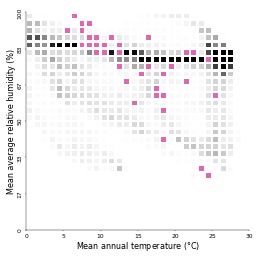

In [ ]:
plt.close('all')
plt.rcParams.update( {'font.size': 8, 'xtick.labelsize' : 6, 'ytick.labelsize' : 6, 'legend.fontsize': 6, 'legend.frameon': False, 
                     'axes.linewidth':0.4, 'xtick.major.width':0.4, 'ytick.major.width':0.4, 'xtick.major.size':1, 'ytick.major.size':1,
                     'xtick.bottom': True, 'xtick.top': False, 'ytick.right': False, 'ytick.right': False, 'legend.numpoints': 4,
                     'xtick.major.pad':3, 'ytick.major.pad':3, 'axes.labelpad':1,'xtick.direction': 'out', 'ytick.direction': 'out', 
                      'axes.edgecolor': 'black','ytick.color': 'black','xtick.color': 'black', 'hatch.color': 'gray' } )

fig = plt.figure( figsize = ( 4, 4 ) )

xedges = np.arange(0,31,1)
yedges = np.linspace(0,100,31)

H, xedges, yedges = np.histogram2d(tasr, RHr, bins=(xedges, yedges))
H = np.ma.masked_where(H == 0, H)
H = H.T

colors = [rgb2hex(i) for i in px.colors.sequential.Greys][1:-1]
plt.pcolormesh(H, cmap = plt.cm.binary, vmin = 1, vmax = 10000, edgecolors = 'white', lw=0.2)

H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges) )
H[H>1] = 1
H = np.ma.masked_where(H == 0, H)
H = H.T
plt.pcolormesh(H, cmap = plt.cm.PuRd, vmin = 0.01, vmax = 2, edgecolors = 'white', lw=1.5)

plt.xlim(0,30)
#plt.ylim(0,50)
plt.yticks([0,5,10,15,20,25,30], np.round(yedges[[0,5,10,15,20,25,30]],0).astype(int))

plt.xlabel( 'Mean annual temperature ($\degree$C)' )
plt.ylabel( 'Mean average relative humidity (%)' )
sns.despine( offset = 0, trim = True )
plt.yticks( rotation = 90, va = 'center' )

plt.savefig( '/content/drive/My Drive/figures/livestock/Figure1_tamma_a.png', dpi = 700, bbox_inches = 'tight', pad_inches = 0 )

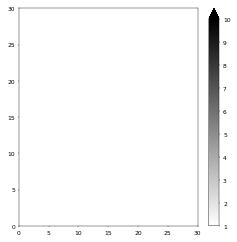

In [ ]:
fig = plt.figure( figsize = ( 4, 4 ) )
plt.pcolormesh(H/1000, cmap = plt.cm.binary, vmin = 1, vmax = 10, edgecolors = 'white', lw=0.2)
plt.colorbar(orientation='vertical', extend = 'max')
plt.savefig( '/content/drive/My Drive/figures/livestock/Figure1_tamma_a.png', dpi = 700, bbox_inches = 'tight', pad_inches = 0 )

In [ ]:
img = cv2.imread('/content/drive/My Drive/data/livestock/FAO_distribution/6_Ct_2010_Aw.tif', cv2.IMREAD_UNCHANGED)
area = cv2.imread('/content/drive/My Drive/data/livestock/FAO_distribution/8_Areakm.tif', cv2.IMREAD_UNCHANGED)
img = img / area
img = np.flip( img, axis = 0 )
img = np.ma.masked_where( img < 0, img )

model = 'CESM2-WACCM'
model = 'GFDL-ESM4'

df1 = df.query( f"activity_id=='ScenarioMIP' & variable_id == 'huss' & experiment_id == 'ssp585' & table_id == 'day' & source_id == '{model}'" )
huss = xr.open_zarr( gcs.get_mapper( df1.zstore.values[0] ), consolidated = True )
df1 = df.query( f"activity_id=='ScenarioMIP' & variable_id == 'tas' & experiment_id == 'ssp585' & table_id == 'day' & source_id == '{model}'" )
Ta = xr.open_zarr( gcs.get_mapper( df1.zstore.values[0] ), consolidated = True )

hu  = huss.sel(time = slice( f'2090-01-01T12:00:00', f'2099-12-30T12:00:00') ).huss.values
tas = Ta.sel(  time = slice( f'2090-01-01T12:00:00', f'2099-12-30T12:00:00') ).tas.values - 273.15
RH = (hu * 1013 / (0.378 * hu + 0.622)) / (6.112 * np.exp((17.67 * tas)/(tas + 243.5)))
RH = xr.where( RH < 1, RH, 1 ) * 100

tas = tas.mean( axis = 0 )
RH = RH.mean( axis = 0 )

ds = xr.Dataset( coords={'lat': lat, 'lon':  lon} )
ds['tas'] = (['lat', 'lon'],  tas)
ds['RH'] = (['lat', 'lon'],  RH)

RH = cv2.resize( RH, (img.shape[1], img.shape[0]) )
tas = cv2.resize( tas, (img.shape[1], img.shape[0]) )

RHr = np.ma.masked_where( img <1, RH ).ravel().compressed()
tasr = np.ma.masked_where( img <1, tas ).ravel().compressed()
imgr = np.ma.masked_where( img <1, tas ).ravel().compressed() 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

overflow encountered in true_divide



KeyboardInterrupt: ignored

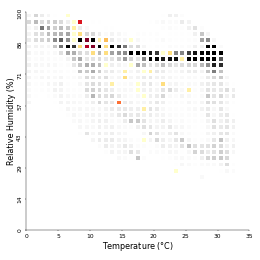

In [ ]:
plt.close('all')
plt.rcParams.update( {'font.size': 8, 'xtick.labelsize' : 6, 'ytick.labelsize' : 6, 'legend.fontsize': 6, 'legend.frameon': False, 
                     'axes.linewidth':0.4, 'xtick.major.width':0.4, 'ytick.major.width':0.4, 'xtick.major.size':1, 'ytick.major.size':1,
                     'xtick.bottom': True, 'xtick.top': False, 'ytick.right': False, 'ytick.right': False, 'legend.numpoints': 4,
                     'xtick.major.pad':3, 'ytick.major.pad':3, 'axes.labelpad':1,'xtick.direction': 'out', 'ytick.direction': 'out', 
                      'axes.edgecolor': 'black','ytick.color': 'black','xtick.color': 'black', 'hatch.color': 'gray' } )

fig = plt.figure( figsize = ( 4, 4 ) )

xedges = np.arange(0,36,1)
yedges = np.linspace(0,100,36)

#H, xedges, yedges = np.histogram2d(tasr, RHr, weights=imgr, bins=(xedges, yedges))
H, xedges, yedges = np.histogram2d(tasr, RHr, bins=(xedges, yedges))
H = np.ma.masked_where(H == 0, H)
H = H.T

colors = [rgb2hex(i) for i in px.colors.sequential.Greys][1:-1]
plt.pcolormesh(H, cmap = plt.cm.binary, vmin = 1, vmax = 10000, edgecolors = 'white', lw=0.2)

H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges) )
H = np.ma.masked_where(H == 0, H)
H = H.T
plt.pcolormesh(H, cmap = plt.cm.YlOrRd, vmin = 1, vmax = 10, edgecolors = 'white', lw=1.5)

plt.xlim(0,35)
plt.yticks([0,5,10,15,20,25,30,35], np.round(yedges[[0,5,10,15,20,25,30,35]],0).astype(int))

plt.xlabel( 'Temperature ($\degree$C)' )
plt.ylabel( 'Relative Humidity (%)' )
sns.despine( offset = 0, trim = True )
plt.yticks( rotation = 90, va = 'center' )

plt.savefig( '/content/drive/My Drive/figures/livestock/Figure1_tamma_b.png', dpi = 700, bbox_inches = 'tight', pad_inches = 0 )

In [ ]:
df1 = df.query( f"activity_id=='CMIP' & variable_id == 'huss' & experiment_id == 'historical' & table_id == 'day' & source_id == '{model}'" )
huss = xr.open_zarr( gcs.get_mapper( df1.zstore.values[0] ), consolidated = True )
df1 = df.query( f"activity_id=='CMIP' & variable_id == 'tas' & experiment_id == 'historical' & table_id == 'day' & source_id == '{model}'" )
Ta = xr.open_zarr( gcs.get_mapper( df1.zstore.values[0] ), consolidated = True )
lat = Ta.lat.values
lon = Ta.lon.values

hu  = huss.sel(time = slice( f'1980-01-01T12:00:00', f'2014-12-30T12:00:00') ).huss.values
tas = Ta.sel(  time = slice( f'1980-01-01T12:00:00', f'2014-12-30T12:00:00') ).tas.values - 273.15
RH = (hu * 1013 / (0.378 * hu + 0.622)) / (6.112 * np.exp((17.67 * tas)/(tas + 243.5)))
RH = xr.where( RH < 1, RH, 1 ) * 100
thi = (1.8 * tas + 32) - ( (0.55 - 0.55 * RH) * (1.8 * tas - 26) )
thi = thi.mean( axis = 0 )

df1 = df.query( f"activity_id=='CMIP' & variable_id == 'rsds' & experiment_id == 'historical' & table_id == 'day' & source_id == '{model}'" )
rs = xr.open_zarr( gcs.get_mapper( df1.zstore.values[0] ), consolidated = True )
rs  = rs.sel(time = slice( f'1980-01-01T12:00:00', f'2014-12-30T12:00:00') ).rsds.values
rs = rs.mean( axis = 0)

thi = cv2.resize( thi, (img.shape[1], img.shape[0]) )
rs = cv2.resize( rs, (img.shape[1], img.shape[0]) )


In [ ]:
rs = np.ma.masked_where( img <1, rs ).ravel().compressed()
thi = np.ma.masked_where( img <1, thi ).ravel().compressed()
weight = np.ma.masked_where( img <1, img ).ravel().compressed() 

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
regr = LinearRegression()
regr.fit(rs.reshape(-1, 1), thi)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
regr.score(rs.reshape(-1, 1), thi)

0.511664230686892

# Breakpoint analyis

In [ ]:
df = pd.read_csv('/content/drive/My Drive/data/livestock/digitized_breakpoints_connverted.csv')
df

Index(['plotID', 'Citation', 'studyID', 'Jim_for_using', 'comment_for_Jim',
       'lat', 'long', 'Unnamed: 14', 'Mortality', 'Fertility', 'Production',
       'Physiological', 'fname', 'breakpoint', 'eqflag', 'thimax', 'thimean',
       'thimin', 'thimaxmonth', 'thi3dmax', 'thicon', 'delta'],
      dtype='object')

<Figure size 360x360 with 0 Axes>

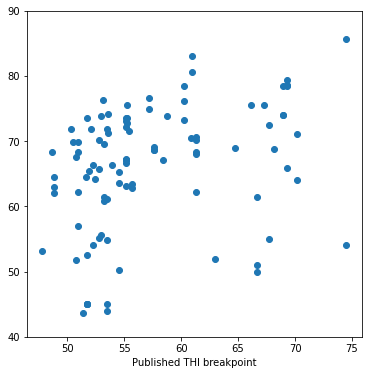

In [ ]:
fig = plt.figure( figsize = ( 5, 5 ) )

df = pd.read_csv('/content/drive/My Drive/data/livestock/digitized_breakpoints_connverted.csv')
df = df.rename(columns={'long':'lon'})
plt.figure(figsize=(6,6))
plt.scatter( df.thimean, df.breakpoint )
plt.ylim(40,90)
plt.xlabel('Baseline mean THI')

plt.xlabel('Published THI breakpoint')

plt.savefig( '/content/drive/My Drive/figures/livestock/breakpoints_baseline_scatter.png', dpi = 700, bbox_inches = 'tight', pad_inches = 0 )

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data/livestock/Digitized_studies.csv', skiprows = 1)
df = df[df.Jim_for_using == 'y']
df = df[['studyID','.csv file name']]
df = df.rename( columns = {'.csv file name':'fname'})
#df['breakpoint'] = np.nan
dft = pd.read_csv('/content/drive/My Drive/data/livestock/digitized_breakpoints_connverted.csv')
dft = dft[['studyID','breakpoint']]
df = pd.merge(df,dft, on = 'studyID', how= 'outer')
df.sort_values(by = ['breakpoint'])

,studyID,fname,breakpoint
9,car2_MY_lux,dig021car2_MY_lux,25.0
8,car1_MY_bel,dig020car1_MY_bel,43.7
49,kon4_win,dig078kon4_win,43.9
47,kon2_sum,dig076kon2_sum,45.0
46,kin5_fif,dig073kin5_fif,45.0
...,...,...,...
54,may5_MY_c,digi097may5_MY_c,NaN
57,may8_MY_e2,digi097may8_MY_e2,NaN
83,mor31_beef1_a7,digi102mor31_beef1_a7,NaN
105,rui3_cross,dig114rui3_cross,NaN


In [ ]:
filelist = df[df.breakpoint.isna()].fname.values

In [ ]:
filelist

array(['dig022car3_MY_slo', 'dig037dur3_sec', 'dig043egb5_lac',
       'dig044ber2_sec', 'dig050bry2_MY_cross', 'dig061gar1_preg',
       'dig073kin2_sec', 'digi097may5_MY_c', 'digi097may8_MY_e2',
       'digi102mor31_beef1_a7', 'dig114rui3_cross', 'dig116sant1'],
      dtype=object)

In [ ]:
root = '/content/drive/MyDrive/data/livestock/digitized/'

In [ ]:
df[df.breakpoint.isna()].fname

Series([], Name: fname, dtype: object)

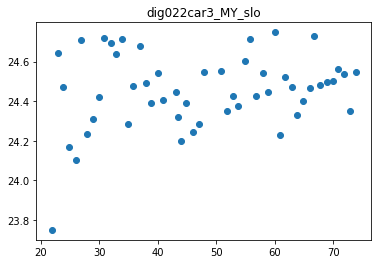

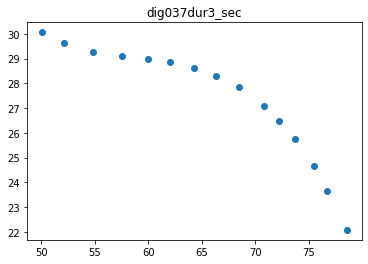

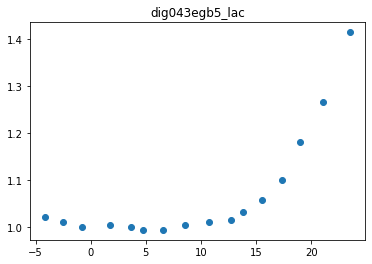

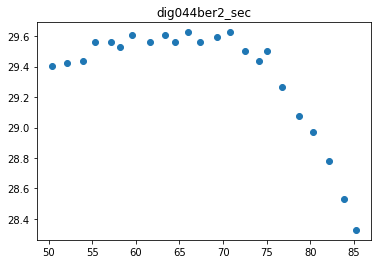

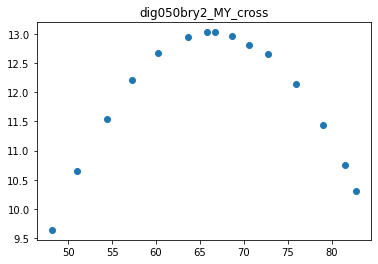

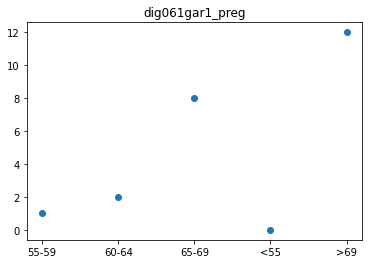

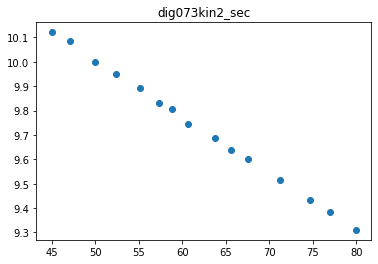

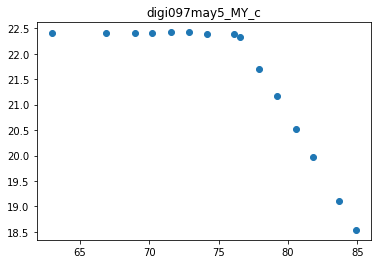

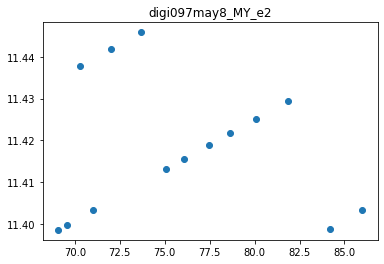

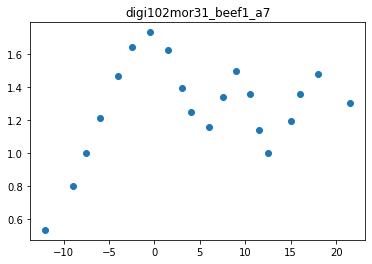

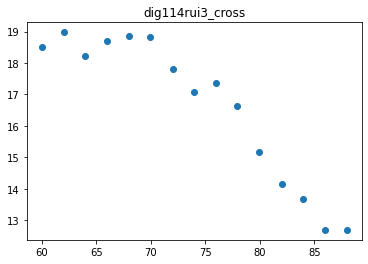

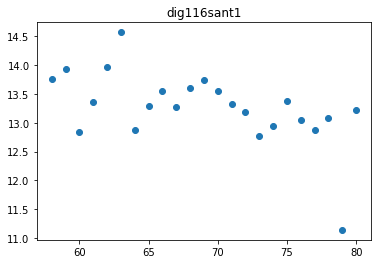

In [ ]:
out = []
for file in filelist:
    df1 = pd.read_csv(root + file+'.csv')
    cols = df1.columns
    df1 = df1.rename( columns = {cols[0]:'x', cols[1]:'y'} )
    df1 = df1.sort_values( by = 'x' )
    x = np.array(df1.x)
    y = np.array(df1.y)
    plt.scatter(x,y)
    plt.title(file)
    plt.show()
    out.append({'file':file, 'n':x.shape})

#out = pd.DataFrame(out)
#out

In [ ]:
	car3_MY_slo	NaN
17	dur3_sec	NaN
23	egb5_lac	NaN
25	ber2_sec	NaN
28	bry2_MY_cross	NaN
37	gar1_preg	NaN
43	kin2_sec	NaN
54	may5_MY_c	NaN
57	may8_MY_e2	NaN
83	mor31_beef1_a7	NaN
105	rui3_cross	NaN
108	sant1

In [ ]:
dft = pd.read_csv('/content/drive/My Drive/data/livestock/digitized_breakpoints_connverted.csv')
#df = df[df.breakpoint == ]
df = df[['Citation','breakpoint']]
df = df.sort_values(by='breakpoint')
df

,Citation,breakpoint
48,Carabaño et al. 2016,25.0
47,Carabaño et al. 2016,43.7
72,Konyves et al 2017,43.9
66,Kino et al 2019,45.0
68,Kino et al 2019,45.0
...,...,...
0,Carabaño et al. 2016,NaN
27,Morignat et al. 2015,NaN
79,Mayer et al 1999,NaN
96,Santana et al 2015,NaN


In [ ]:
df = df[['thimean','thimean']].dropna()
df = df[df.breakpoint > 30]


sns.set_theme(style="white")
g = sns.jointplot(x="thimean", y="breakpoint", data=df,
                  kind="reg", truncate=False,
                  xlim=(45, 76), ylim=(40, 90), height=7)

plt.savefig( '/content/drive/My Drive/figures/livestock/breakpoints_baseline_scatter.png', dpi = 700, bbox_inches = 'tight', pad_inches = 0 )

In [ ]:
df = pd.read_csv('/content/drive/My Drive/data/livestock/digitized_breakpoints_connverted.csv')
df = df[df.comment_for_Jim == 'sensitivity test']
df.studyID

1      car4_MY_spa
40         ben1_CR
48     car2_MY_lux
64         igo1_AZ
67        kin3_thi
69        kin5_fif
70        kon2_sum
80      may9_MY_e3
97           sant2
100        ama4_MY
Name: studyID, dtype: object

In [ ]:
df = pd.read_csv('/content/drive/My Drive/data/livestock/digitized_breakpoints_connverted.csv')
df = df[df.comment_for_Jim == 'sensitivity test']
df = df.dropna(subset=['breakpoint'])
df.shape

(10, 22)

In [ ]:
df = pd.read_csv('/content/drive/My Drive/data/livestock/digitized_breakpoints_connverted.csv')
df = df[df.breakpoint > 30]
df1 = df[df.Mortality == 'x']
df1['impact'] = 'M'
df2 = df[df.Fertility == 'x']
df2['impact'] = 'F'
df3 = df[df.Production == 'x']
df3['impact'] = 'P'
df = pd.concat([df1, df2, df3]).dropna(subset = ['breakpoint'])
#df = df[df.comment_for_Jim == 'n']
df.median()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

lat              40.180000
long              6.486644
Physiological          NaN
breakpoint       68.300517
thimax           61.157907
thimean          55.154761
thimin           49.147311
thimaxmonth      71.861622
thi3dmax         62.819607
delta            -5.742764
dtype: float64

In [ ]:
df = pd.read_csv('/content/drive/My Drive/data/livestock/digitized_breakpoints_connverted.csv')
df = df[df.breakpoint > 30]
df1 = df[df.Mortality == 'x']
df1['impact'] = 'M'
df2 = df[df.Fertility == 'x']
df2['impact'] = 'F'
df3 = df[df.Production == 'x']
df3['impact'] = 'P'
df = pd.concat([df1, df2, df3])
df = df[['thimean','breakpoint','impact']].dropna()

sns.set_theme(style="white")
g = sns.jointplot( data=df, x="thimean", y="breakpoint", hue = 'impact', kind="reg", truncate=False, xlim=(45, 76), ylim=(40, 90), height=7)

plt.savefig( '/content/drive/My Drive/figures/livestock/breakpoints_baseline_scatter.png', dpi = 700, bbox_inches = 'tight', pad_inches = 0 )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

ValueError: ignored

In [ ]:
df.kind

2      M
3      M
4      M
5      M
6      M
      ..
93     P
94     P
95     P
97     P
100    P
Name: kind, Length: 100, dtype: object

In [ ]:
m = sc.stats.linregress(df.thimean.values,df.breakpoint.values)
print(m.slope)
print(m.intercept)
print(m.pvalue)
print(m.rvalue)
print(m.stderr)

0.5506215714348904
34.36655811008661
0.0007942056603315197
0.32858607606626966
0.15906568064296145


In [ ]:
#df = df[df.comment_for_Jim == 'n']
print(df[df.impact == 'M'].breakpoint.median())
print(df[df.impact == 'F'].breakpoint.median())
print(df[df.impact == 'P'].breakpoint.median())

66.05913793103448
68.575
69.0


In [ ]:
df.shape

(101, 23)

In [ ]:
df[df.breakpoint < 75].shape

(86, 23)

In [ ]:
75/91

0.8241758241758241

In [ ]:
plt.

In [ ]:
import scipy.stats as st

In [ ]:
np.median(data)

68.15025862068966

In [ ]:
data = df.breakpoint
st.t.interval(alpha=0.95, df=len(data)-1, loc=np.median(data), scale=st.sem(data))

(66.07773909484624, 70.22277814653307)

In [ ]:
import scipy.stats as st
data = df[df.kind == 'P'].breakpoint
st.t.interval(alpha=0.95, df=len(data)-1, loc=np.median(data), scale=st.sem(data))

(65.94047591309645, 72.05952408690355)

In [ ]:
data = df[df.kind == 'M'].breakpoint
st.t.interval(alpha=0.95, df=len(data)-1, loc=np.median(data), scale=st.sem(data))

(63.311223914267934, 68.26912091331828)

In [ ]:
data = df[df.kind == 'F'].breakpoint
st.t.interval(alpha=0.95, df=len(data)-1, loc=np.median(data), scale=st.sem(data))

(62.796215415582516, 74.3537845844175)

In [ ]:
74.50496645474422 * 0.675 + 28.56

In [ ]:
47.80078269158256 * 0.675 + 28.56

In [ ]:
df = pd.read_csv('/content/drive/My Drive/data/livestock/digitized_breakpoints_connverted.csv')
#df = df[df.comment_for_Jim == 'n']
df = df.replace({'USA':'United States of America'})
df = df.rename(columns={'long':'lon'})

df1 = pd.read_csv('/content/drive/MyDrive/data/livestock/Digitized_studies.csv', skiprows = 1)
df1 = df1.rename( columns = {'.csv file name':'fname'})
df1 = df1[['fname','country']]
df1 = df1.dropna( subset = ['fname'] )
df  = pd.merge(df,df1, on = ['fname'], how = 'left')

rad = np.empty((12,720,1440))
months = ['01','02','03','04','05','06','07','08','09','10','11','12']
for i, month in enumerate(months): rad[i,:,:] = np.genfromtxt(f'/content/drive/MyDrive/data/livestock/radiation/CERES_INSOL_M_2019-{month}-01_rgb_1440x720.CSV', delimiter=',')

ds = xr.Dataset( coords = { 'month': [1,2,3,4,5,6,7,8,9,10,11,12],'lat':np.linspace(89.875,-89.875,720),'lon':np.linspace(-179.875,179.875,1440)} )
ds['rad'] = (['month','lat', 'lon'], rad )

df['meanR'] = ""
df['maxR'] = ""
for i, row in df.iterrows():
    r = ds.sel(lat = row.lat, method='nearest').sel(lon = row.lon, method='nearest').rad.values 
    df.loc[i,'meanR'] = r.mean()
    df.loc[i,'maxR'] = r.max()

df1 = df[df.Mortality == 'x']
df1['kind'] = 'M'
df2 = df[df.Fertility == 'x']
df2['kind'] = 'F'
df3 = df[df.Production == 'x']
df3['kind'] = 'P'
df = pd.concat([df1, df2, df3])

df = df[['studyID','Citation','comment_for_Jim','country','breakpoint', 'thimax', 'thimean', 'thimin','thimaxmonth','meanR','maxR','kind']]
df = df.dropna()
df.meanR = pd.to_numeric(df.meanR)
df.maxR = pd.to_numeric(df.maxR)

#df = df.rename()

#df1 = pd.read_csv('/content/drive/MyDrive/data/livestock/impacts_observational_april2021.csv')
#df1 = df1[['Citation','Country']].drop_duplicates()

#dfc = pd.read_csv('/content/drive/MyDrive/data/robert/API_NY.GDP.PCAP.PP.CD_DS2_en_csv_v2_1345144.csv', skiprows=4)
#dfc = dfc[['Country Name','2019']].rename(columns = {'Country Name':'Country','2019':'gdp'})
#dfc = pd.merge(df1,dfc, on= 'Country')

#df = pd.merge(df,dfc, on = 'Citation')

def roundup(x):
    return np.array(np.ceil(x / 10.0) * 10, dtype=int)
df['rbin'] = roundup(df.meanR)

df = df[df.breakpoint > 30]

dfs = df.copy()
#df = df[df.comment_for_Jim == 'n']

df.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

,studyID,Citation,comment_for_Jim,country,breakpoint,thimax,thimean,thimin,thimaxmonth,meanR,maxR,kind,rbin
2,cre1_bre,Crescio et al. 2010,n,Italy,71.528103,61.537428,55.416171,48.626334,79.400921,191.274167,350.79,M,200
3,cre2_cun,Crescio et al. 2010,n,Italy,70.093621,58.656603,52.840940,45.730768,71.941327,203.182500,344.29,M,210
4,cre3_rom,Crescio et al. 2010,n,Italy,73.859138,64.986586,58.721468,52.683121,76.928304,217.076667,378.94,M,220


In [ ]:
m = sc.stats.linregress(df.meanR.values,df.thimean.values)
print(m.slope)
print(m.intercept)
print(m.pvalue)
print(m.rvalue)
print(m.stderr)

0.12896058779770625
29.784631864590807
2.931222413580094e-32
0.872594317192257
0.007292019749607475


In [ ]:
0.872594317192257**2

0.7614208423962212

In [ ]:
305*0.12896058779770625+29.784631864590807

69.1176111428912

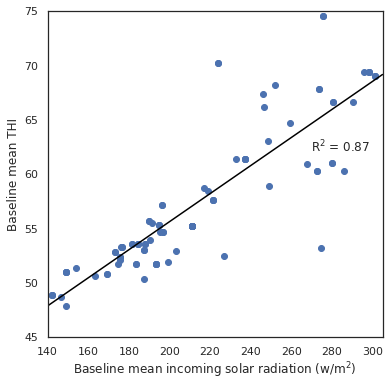

In [ ]:
df = df[['thimean','meanR']].dropna()

plt.figure(figsize=(6,6))
plt.scatter( df.meanR, df.thimean )
plt.plot([140,305],[47.839,69.117], color = 'black')
plt.ylim(45,75)
plt.xlim(140,305)
plt.ylabel('Baseline mean THI')
plt.xlabel('Baseline mean incoming solar radiation (w/m$^{2}$)')
plt.annotate('R$^{2}$ = 0.87', xy=(270,62))

plt.savefig( '/content/drive/My Drive/figures/livestock/thi_rad_scatter.png', dpi = 700, bbox_inches = 'tight', pad_inches = 0 )

In [ ]:
df.groupby(['country','kind']).count()

In [ ]:
monthly = ['bel2_Tar','ben1_CR','boh1_Ath','boh2_Pho','gar1_preg','igo1_AZ','igo2_KL','dup1','sant3']
dfm = df[~df.studyID.isin(monthly)]
dfm

In [ ]:
dft = df[df.kind == 'P']
dft.breakpoint.median()

69.0

In [ ]:
57.58899789824359 * 0.3466

In [ ]:
69.1 - 57.58899789824359 * 0.3466

In [ ]:
dft[dft.breakpoint==69.1]

In [ ]:
dftest = df[df.kind == 'M']
m = sc.stats.linregress(dftest.thimean.values,dftest.breakpoint.values)
print(m.slope)
print(m.intercept)
print(m.pvalue)
print(m.rvalue)
print(m.stderr)

In [ ]:
dftest = df[df.kind == 'F']
m = sc.stats.linregress(dftest.thimean.values,dftest.breakpoint.values)
print(m.slope)
print(m.intercept)
print(m.pvalue)
print(m.rvalue)
print(m.stderr)

In [ ]:
dftest = df[df.kind == 'P']
m = sc.stats.linregress(dftest.thimean.values,dftest.breakpoint.values)
print(m.slope)
print(m.intercept)
print(m.pvalue)
print(m.rvalue)
print(m.stderr)

0.6297096826572675
30.918844057211913
0.006367674065124386
0.4096862054211012
0.21897765104895406


0.6042285456299822
1.0176032070260639e-05
0.4336313897832567


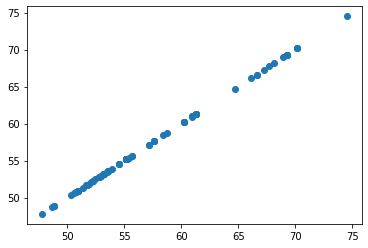

In [ ]:
plt.scatter(df.thimean, df.thimean)
m = sc.stats.linregress(df.thimean.values,df.breakpoint.values)
print(m.slope)
print(m.pvalue)
print(m.rvalue)

In [ ]:
np.quantile(df.breakpoint.values, [0.98])

array([81.15])

In [ ]:
%R -i df
%R df$kind  <- as.factor( df$kind )
%R df$rbin <- as.factor( df$rbin )
%R df$country <- as.factor( df$country )

dfm = pd.DataFrame({})
%R out <- tidy( felm( breakpoint ~  thimean | kind | 0 | kind , data = df ) )
%R -o out 
out['model'] = 'thimean | country FE'
dfm = pd.concat( ( dfm, out ) ) 

%R out <- tidy( felm( breakpoint ~  thimaxmonth | kind | 0 | kind , data = df ) )
%R -o out 
out['model'] = 'thimaxmonth | country FE'
dfm = pd.concat( ( dfm, out ) ) 

%R out <- tidy( felm( breakpoint ~  thimean | kind + country | 0 | kind , data = df ) )
%R -o out 
out['model'] = 'thimean | impact type + country FE'
dfm = pd.concat( ( dfm, out ) ) 


%R out <- tidy( felm( breakpoint ~  thimaxmonth | kind + country | 0 | kind , data = df ) )
%R -o out 
out['model'] = 'thimaxmonth | impact type + country FE'
dfm = pd.concat( ( dfm, out ) ) 

%R -i dfs
%R dfs$kind  <- as.factor( dfs$kind )
%R dfs$rbin <- as.factor( dfs$rbin )
%R dfs$country <- as.factor( dfs$country )

%R out <- tidy( felm( breakpoint ~  thimean | kind | 0 | kind , data = dfs ) )
%R -o out 
out['model'] = '(sensitity) thimean | country FE'
dfm = pd.concat( ( dfm, out ) ) 

%R out <- tidy( felm( breakpoint ~  thimaxmonth | kind | 0 | kind , data = dfs ) )
%R -o out 
out['model'] = '(sensitity) thimaxmonth | country FE'
dfm = pd.concat( ( dfm, out ) ) 

%R out <- tidy( felm( breakpoint ~  thimean | kind + country | 0 | kind , data = dfs ) )
%R -o out 
out['model'] = '(sensitity) thimean | impact type + country FE'
dfm = pd.concat( ( dfm, out ) ) 

%R out <- tidy( felm( breakpoint ~  thimaxmonth | kind + country | 0 | kind , data = dfs ) )
%R -o out 
out['model'] = '(sensitity) thimaxmonth | impact type + country FE'
dfm = pd.concat( ( dfm, out ) ) 

dfm['stars'] = dfm['p.value'].apply(get_stars)
dfm

,term,estimate,std.error,statistic,p.value,model,stars
1,thimean,0.663556,0.036385,18.236914,0.002993,thimean | country FE,**
1,thimaxmonth,0.517442,0.198927,2.601166,0.121451,thimaxmonth | country FE,
1,thimean,0.479873,0.129024,3.719249,0.065291,thimean | impact type + country FE,.
1,thimaxmonth,0.676198,0.188169,3.593564,0.069465,thimaxmonth | impact type + country FE,.
1,thimean,0.559421,0.029861,18.734092,0.002837,(sensitity) thimean | country FE,**
1,thimaxmonth,0.428257,0.111526,3.839989,0.061616,(sensitity) thimaxmonth | country FE,.
1,thimean,0.222004,0.154718,1.434897,0.287779,(sensitity) thimean | impact type + country FE,
1,thimaxmonth,0.402152,0.242503,1.658335,0.239110,(sensitity) thimaxmonth | impact type + countr...,


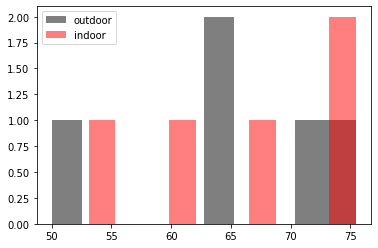

In [ ]:
indoor = ['bru1_MY','ger8_preg','sch1','vit1_max','fre2_stat']
outdoor = ['bru2_MY','bru3_MY','ber1_fst','ber2_sec','ber3_thi','igo1_AZ','igo2_KL']

dfi = df[df.studyID.isin(indoor)]
dfo = df[df.studyID.isin(outdoor)]
plt.hist(dfo.breakpoint, color = 'black', alpha = 0.5, label = 'outdoor')
plt.hist(dfi.breakpoint, color = 'red', alpha = 0.5, label = 'indoor')
plt.legend()
plt.savefig('/content/drive/My Drive/figures/livestock/indoor_outdoor.png', dpi = 700, bbox_inches = 'tight', pad_inches = 0 )

In [ ]:
dfo.breakpoint.mean()

65.12

In [ ]:
dfi.breakpoint.mean()

66.51316252333478

In [ ]:
df.sort_values('breakpoint', ascending=False)

,studyID,Citation,comment_for_Jim,country,breakpoint,thimax,thimean,thimin,thimaxmonth,meanR,maxR,kind,rbin
99,sant3,Santana et al 2018,n,Brazil,85.600000,78.582901,74.504966,68.669785,77.463314,275.720833,298.82,F,280
103,vit1_max,Vitali et al 2009,n,Germay,85.407118,61.170236,55.263118,47.996856,78.024455,194.880833,363.78,M,200
73,may1_MY_a1,Mayer et al 1999,n,Australia,83.100000,69.954339,60.962311,51.190563,69.387957,279.872500,396.26,P,280
74,may2_MY_a2,Mayer et al 1999,n,Australia,80.600000,69.954339,60.962311,51.190563,69.387957,279.872500,396.26,P,280
76,may4_MY_b2,Mayer et al 1999,n,Australia,79.400000,74.883534,69.305124,64.770785,76.119021,298.457500,400.59,P,300
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,igo2_KL,Igono et al. 1992,n,USA,50.000000,72.703387,66.628332,60.370842,80.579469,280.414167,420.08,P,290
68,kin4_fou,Kino et al 2019,n,Japan,45.000000,54.576200,51.727124,49.048979,70.447805,193.439167,285.83,P,200
66,kin1_fst,Kino et al 2019,n,Japan,45.000000,54.576200,51.727124,49.048979,70.447805,193.439167,285.83,P,200
72,kon4_win,Konyves et al 2017,n,Serbia,43.900000,59.881066,53.539906,46.785170,73.196218,184.596667,324.80,P,190


In [ ]:
%R -i df
%R dfkind <- as.factor( df$kind )
%R dfrbin <- as.factor( df$rbin )

dfm = pd.DataFrame({})
%R out <- tidy( felm( breakpoint ~ thimean | kind | 0 | kind , data = df ) )
%R -o out 
out['model'] = 'thimean | impact type FE'
dfm = pd.concat( ( dfm, out ) ) 

%R out <- tidy( felm( breakpoint ~ thimax | kind | 0 | kind , data = df ) )
%R -o out 
out['model'] = 'thimax | impact type FE'
dfm = pd.concat( ( dfm, out ) )

%R out <- tidy( felm( breakpoint ~ thimin | kind | 0 | kind , data = df ) )
%R -o out 
out['model'] = 'thimin | impact type FE'
dfm = pd.concat( ( dfm, out ) )

%R out <- tidy( felm( breakpoint ~ thimean | kind + rbin | 0 | kind , data = df ) )
%R -o out 
out['model'] = 'thimean | impact FE & radiation binned FE'
dfm = pd.concat( ( dfm, out ) )

%R out <- tidy( felm( breakpoint ~ meanR | kind | 0 | kind , data = df ) )
%R -o out 
out['model'] = 'mean rad | impact FE'
dfm = pd.concat( ( dfm, out ) )

%R out <- tidy( felm( breakpoint ~ maxR | kind | 0 | kind , data = df ) )
%R -o out 
out['model'] = 'max rad | impact FE'
dfm = pd.concat( ( dfm, out ) )

%R out <- tidy( felm( breakpoint ~ thimean + meanR | kind | 0 | kind , data = df ) )
%R -o out 
out['model'] = '~thimean + mean rad | impact FE'
dfm = pd.concat( ( dfm, out ) )

%R out <- tidy( felm( breakpoint ~ thimax + maxR | kind | 0 | kind , data = df ) )
%R -o out 
out['model'] = '~thimax + max  rad | impact FE'
dfm = pd.concat( ( dfm, out ) )


dfm['stars'] = dfm['p.value'].apply(get_stars)
dfm

In [ ]:
plt.scatter(df.meanR, df.thimean)
m = sc.stats.linregress(df.meanR.values,df.thimean.values)
print(m.slope)
print(m.pvalue)
print(m.rvalue)

In [ ]:
print(df[df.kind == 'M'].thimean.mean())
print(df[df.kind == 'P'].thimean.mean())
print(df[df.kind == 'F'].thimean.mean())

In [ ]:
5*0.7591374159724992

In [ ]:
(53.10555908672899 - 58.91158968133609) * 0.759

In [ ]:
(61.11211765739878- 58.91158968133609) * 0.759

In [ ]:
%R -i dfR
%R dfR$FIPS  <- as.factor( dfR$FIPS  )
%R dfR$state <- as.factor( dfR$state )
%R dfR$week  <- as.factor( dfR$week )
%R dfR$month <- as.factor( dfR$month )

%R out <- tidy( felm( Ro_T ~ T | FIPS + day + state:month | 0 | FIPS , data = dfR ) )
%R -o out 
out['model'] = 'temp_sXm'
out['day'] = day
dfm = pd.concat( ( dfm, out ) )

%R out <- tidy( felm( Ro_T ~ T | FIPS + day + state:week | 0 | FIPS , data = dfR ) )
%R -o out 
out['model'] = 'temp_sXw'
out['day'] = day
dfm = pd.concat( ( dfm, out ) )

%R out <- tidy( felm( Ro_T ~ T | FIPS + day + FIPS:month | 0 | FIPS , data = dfR ) )
%R -o out 
out['model'] = 'temp_cXm'
out['day'] = day
dfm = pd.concat( ( dfm, out ) )

%R out <- tidy( felm( Ro_T ~ T | FIPS + day + FIPS:week | 0 | FIPS , data = dfR ) )
%R -o out 
out['model'] = 'temp_cXw'
out['day'] = day
dfm = pd.concat( ( dfm, out ) )

dfm['stars'] = dfm['p.value'].apply(get_stars)
dfm = dfm.rename( columns = {'std.error':'std_error', 'statistic':'T_statistic', 'p.value':'p_value'} )

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data/livestock/impacts_observational_april2021.csv')
df = df[['Citation','lat','lon','day_3day_month','mean_or_max']]
df = df.replace({'Bryant et al.  2007':'Bryant et al. 2007', 'Jeelani et al.  2019':'Jeelani et al. 2019' } )

df1 = pd.read_csv('/content/drive/MyDrive/data/livestock/Digitized studies .csv', skiprows=1)
df1 = df1[['Citation','note','.csv file name','Production type','Unnamed: 9','Cattle breed type','Mortality','Fertility','Production','Physiological']]
df1 = df1.rename( columns = {'.csv file name':'csvname'} )
for year in range(2016,2030): df1 = df1.replace({f'Morignat et al. {year}':'Morignat et al. 2015'} )


df = pd.merge(df1, df, on ='Citation', how = 'left')
df = df.drop_duplicates()

df1 = pd.read_csv('/content/drive/MyDrive/data/livestock/jims_digitized.csv')
df1 = df1.rename( columns = {'note ':'breaknote', 'study ':'csvname', 'break':'breakpoint'} )
df1.csvname = df1.csvname.str.strip('.csv')

df = pd.merge(df, df1, on = 'csvname')
df = df[df.breakpoint !='E']
df = df[df.breakpoint !='NA']
df = df[~df.breakpoint.isna()]
df.breakpoint  = pd.to_numeric(df.breakpoint)
df.mean_or_max = df.mean_or_max.replace({np.nan:'mean'})
df.breaknote   = df.breaknote.replace({'m':'min','M':'min'})

### convert the C breakpoints ###
df1 = df[df.breakpoint < 30]
df = df[df.breakpoint > 30]
rh = 0.5
df1.breakpoint = df1.breakpoint * 9/5 + 32
#df1.breakpoint = (319*rh + 40*df.breakpoint - 319)/ (22*rh + 18)
df = pd.concat([df,df1])

### get baseline climate info from the HADisd ###
sta = pd.read_fwf('/content/drive/My Drive/data/livestock/hadisd_station_fullinfo_v311_202001p.txt',
                  colspecs = [(0,11),(12,42),(43,50),(51,59),(60,67),(68,78),(79,89)],
                  names = ['ID','name','lat','lon','elv','start_date','end_date'])
sta = pd.read_fwf('/content/drive/My Drive/data/livestock/hadisd_station_info_v311_202008p.txt',
                  colspecs = [(0,11),(12,19),(20,29),(30,39)], names = ['ID','lat','lon','elv'])

sta = sta.dropna()
new = sta.copy()

def get_path(sid):
    files = ['080000-099999','000000-029999','030000-049999','450000-499999','650000-699999','400000-449999',
            '350000-399999','300000-349999','200000-249999','250000-299999','100000-149999','150000-199999',
            '050000-079999','550000-599999','600000-649999','500000-549999','700000-709999','720000-722999',
            '710000-719999','723000-723999','726000-726999','725000-725999','724000-724999','730000-799999',
            '800000-849999','950000-999999','900000-949999','850000-899999','727000-729999']

    bins = np.zeros((len(files),2))
    for i, file in enumerate(files): bins[i,:] = np.array(file.split('-'), dtype=int) 

    sidn = np.int(sid[:6])
    for i,j in bins: 
        if (sidn > i) & (sidn < j): out = i,j
        else: pass
    
    b1 = out[0].astype(int).astype(str)
    b2 = out[1].astype(int).astype(str)

    if len(b1) == 5: 
        b1 = '0'+ b1
        b2 = '0'+ b2
    else: pass

    path = f'/content/drive/My Drive/data/livestock/HadISD/WMO_{b1}-{b2}_heat_stress/hadisd.3.1.1.202008p_19310101-20200901_{sid+sid[-1]}_heat_stress.nc'
    ds = xr.open_dataset( path )
    ds = ds.temperature_humidity_index

    ds = ds.where( (ds > 0) & (ds < 150) )
    thimax   = ds.resample( time = '1D' ).max().mean().values
    thimean  = ds.resample( time = '1D' ).mean().mean().values
    thimin   = ds.resample( time = '1D' ).min().mean().values
    #thimean3 = ds.resample( time = '3D' ).mean().mean().values
    return thimax, thimean, thimin #, thimean3

l = []
for index, row in df.iterrows():
    new['latlon'] = np.abs( new.lat-row.lat ) + np.abs( new.lon-row.lon )
    new.sort_values( 'latlon' , inplace=True)
    try: l.append(get_path(new.iloc[0].ID))
    except: 
        try: l.append(get_path(new.iloc[1].ID))
        except: 
            try: l.append(get_path(new.iloc[2].ID))
            except: 
                try: l.append(get_path(new.iloc[3].ID))
                except:
                    try: l.append(get_path(new.iloc[4].ID))
                    except: 
                        try: l.append(et_path(new.iloc[5].ID))
                        except: l.append(get_path(new.iloc[6].ID))

l = np.array(l)
df['thimax'] = l[:,0]
df['thimean'] = l[:,1]
df['thimin'] = l[:,2]

df.to_csv('/content/drive/My Drive/data/livestock/digitized_breakpoints_with_min_mean_max.csv', index = False )

In [ ]:
dfmin = df[df.mean_or_max == 'min']
dfmin.breakpoint = dfmin.breakpoint + (dfmin.thimean - dfmin.thimin) 

dfmax = df[df.mean_or_max == 'max']
dfmax.breakpoint = dfmax.breakpoint - (dfmax.thimax - dfmax.thimean) 

dfmean= df[df.mean_or_max == 'mean']
df = pd.concat([dfmin,dfmean,dfmax])

# all thresholds (280ish)

In [ ]:
plt.hist(df.breakpoint)
df.breakpoint.median()

In [ ]:
plt.hist([df[df.Mortality == 'x'].breakpoint.values,df[df.Fertility == 'x'].breakpoint.values,df[df.Production == 'x'].breakpoint.values,df[df.Physiological == 'x'].breakpoint.values], bins = 30, stacked=True, color = ['r','orange','b','black'])

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/data/livestock/Digitized studies .csv', skiprows=1)
df1 = df1[['Citation']]
df = pd.merge(df,df1, )

In [ ]:
df

In [ ]:
dft = df[df.Production == 'x']
dft = dft[dft['Unnamed: 9'] != 'milk quality']
print(dft.breakpoint.median())

In [ ]:
dft = df[df.Production == 'x']
dft = dft[dft['Unnamed: 9'] != 'milk yield']
print(dft.breakpoint.median())

In [ ]:
dft.breakpoint.median() 

In [ ]:
print(df[df.Mortality == 'x'])
print(df[df.Fertility == 'x'].breakpoint.median())
print(df[df.Production == 'x'].breakpoint.median())
print(df[df.Physiological == 'x'].breakpoint.median())

In [ ]:
print(df[df.Mortality == 'x'].breakpoint.median())
print(df[df.Fertility == 'x'].breakpoint.median())
print(df[df.Production == 'x'].breakpoint.median())
print(df[df.Physiological == 'x'].breakpoint.median())

In [ ]:
df[df.Mortality == 'x'].Citation.unique()

In [ ]:
for citation in df.Citation.unique(): plt.scatter( df[df.Citation == citation].thimean, df[df.Citation == citation].breakpoint)

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/data/livestock/Digitized studies .csv', skiprows=1)
len(df1.Citation.unique())

In [ ]:
dffit = df[['Citation','thimean','thimax','breakpoint','Mortality','Fertility','Production','Physiological']]
dffit = dffit[dffit.Production == 'x']
dffit = dffit.dropna( subset=['thimax'])
sc.stats.linregress(dffit.thimax, dffit.breakpoint)

In [ ]:
sc.stats.linregress(dffit.thimax, dffit.breakpoint)

# get impacts thresholds... and baseline climate

In [ ]:
df = pd.read_csv('/content/drive/My Drive/data/livestock/impacts.csv' )
df = df[['Citation','lat','lon','thieq', 'Jim_breakpoint', 'Species for Jim','Jim_for using','Cattle breed type','day_3day_month', 'mean_or_max','Mortality (Y/N)','Fertility (Y/N)','Production (Y/N)']]
df = df.replace({'cattle ':'cattle'})
df = df[df['Species for Jim'] == 'cattle']
df = df[df['Jim_for using'] == 'Y']
df = df[df.mean_or_max != 'min']
df.Jim_breakpoint = pd.to_numeric(df.Jim_breakpoint, errors='coerce')
df = df.dropna(subset=['Jim_breakpoint'])

df['ta'] = 25
df['rh'] = 50
### Wet bulb from Stull, 2011 Journal of Applied Meterology and Climatology, Equation 1 ###
df['wb'] = df.ta * np.arctan( 0.151977 * (df.rh + 8.313659)**(1/2) ) + np.arctan(df.ta+ df.rh) - np.arctan(df.rh - 1.676331) + 0.00391838 * (df.rh)**(3/2) * np.arctan(0.023101 * df.rh) - 4.686035
### Dewpoint from XXXX ###
df['dp'] = 243.5 * (np.log(df.rh/100) + ( ( 17.67 * df.ta ) / ( 243.5 + df.ta ) ) ) / ( 17.67 - np.log(df.rh/100) - ( ( 17.67 * df.ta ) / ( 243.5 + df.ta ) ) )

labs = ['THI =','THI=','THI_mon =','HSI = ','THI1 = ','THI2 = ','THI3 = ','THI4 = ','THI5 = ','THI6 = ','THI7= ','THIRa = ','THIBo = ']
for lab in labs: df.thieq = df.thieq.str.replace(lab,'', case = False)

df.thieq = df.thieq.str.replace('×','*', case = False)
df.thieq = df.thieq.str.replace('X','*', case = False)
df.thieq = df.thieq.str.replace('\[','(', case = False)
df.thieq = df.thieq.str.replace('\]',')', case = False)
df.thieq = df.thieq.str.replace('%','', case = False)

df.thieq = df.thieq.str.replace('RH','df.rh', case = False)
df.thieq = df.thieq.str.replace('Tdp','df.dp', case = False)
df.thieq = df.thieq.str.replace('Twb','df.wb', case = False)
labs = ['TaC','Tave','Tdb','TDB','Ta','AT','T']
for lab in labs: df.thieq = df.thieq.str.replace(lab,'df.ta', case = True)

test = []
for i in df.index: test.append({'id':i, 'thi':pd.eval( df[df.index == i].thieq )[0,0]}) 
test = pd.DataFrame(test)
test.index = test['id']
df = pd.merge(df, test, left_index=True, right_index=True)
df['thi_adjust'] = df.thi.mode().values[0] - df.thi 
df['breakpoint'] = df.Jim_breakpoint + df.thi_adjust
df = df.sort_values( by = 'Citation', ascending = False)
df.head(3)

### get baseline climate info from the HADisd ###
sta = pd.read_fwf('/content/drive/My Drive/data/livestock/hadisd_station_fullinfo_v311_202001p.txt',
                  colspecs = [(0,11),(12,42),(43,50),(51,59),(60,67),(68,78),(79,89)],
                  names = ['ID','name','lat','lon','elv','start_date','end_date'])
sta = pd.read_fwf('/content/drive/My Drive/data/livestock/hadisd_station_info_v311_202008p.txt',
                  colspecs = [(0,11),(12,19),(20,29),(30,39)], names = ['ID','lat','lon','elv'])

sta = sta.dropna()
new = sta.copy()

def get_path(sid):
    files = ['080000-099999','000000-029999','030000-049999','450000-499999','650000-699999','400000-449999',
            '350000-399999','300000-349999','200000-249999','250000-299999','100000-149999','150000-199999',
            '050000-079999','550000-599999','600000-649999','500000-549999','700000-709999','720000-722999',
            '710000-719999','723000-723999','726000-726999','725000-725999','724000-724999','730000-799999',
            '800000-849999','950000-999999','900000-949999','850000-899999','727000-729999']

    bins = np.zeros((len(files),2))
    for i, file in enumerate(files): bins[i,:] = np.array(file.split('-'), dtype=int) 

    sidn = np.int(sid[:6])
    for i,j in bins: 
        if (sidn > i) & (sidn < j): out = i,j
        else: pass
    
    b1 = out[0].astype(int).astype(str)
    b2 = out[1].astype(int).astype(str)

    if len(b1) == 5: 
        b1 = '0'+ b1
        b2 = '0'+ b2
    else: pass

    path = f'/content/drive/My Drive/data/livestock/HadISD/WMO_{b1}-{b2}_heat_stress/hadisd.3.1.1.202008p_19310101-20200901_{sid+sid[-1]}_heat_stress.nc'
    ds = xr.open_dataset( path )
    ds = ds.temperature_humidity_index

    ds = ds.where( (ds > 0) & (ds < 150) )
    thimax   = ds.resample( time = '1D' ).max().mean().values
    thimean  = ds.resample( time = '1D' ).mean().mean().values
    thimin   = ds.resample( time = '1D' ).min().mean().values
    #thimean3 = ds.resample( time = '3D' ).mean().mean().values
    return thimax, thimean, thimin #, thimean3

l = []
for index, row in df.iterrows():
    new['latlon'] = np.abs( new.lat-row.lat ) + np.abs( new.lon-row.lon )
    new.sort_values( 'latlon' , inplace=True)
    try: l.append(get_path(new.iloc[0].ID))
    except: 
        try: l.append(get_path(new.iloc[1].ID))
        except: 
            try: l.append(get_path(new.iloc[2].ID))
            except: 
                try: l.append(get_path(new.iloc[3].ID))
                except:
                    try: l.append(get_path(new.iloc[4].ID))
                    except: 
                        try: l.append(et_path(new.iloc[5].ID))
                        except: l.append(get_path(new.iloc[6].ID))

l = np.array(l)
df['thimax'] = l[:,0]
df['thimean'] = l[:,1]
df['thimin'] = l[:,2]
#df['thimin3d'] = l[:,3]

df.to_csv('/content/drive/My Drive/data/livestock/HadISD/breakpoints_with_min_mean_max.csv', index = False )

In [ ]:
### adjust the max's ---> means ###
df = pd.read_csv( '/content/drive/My Drive/data/livestock/HadISD/breakpoints_with_min_mean_max.csv' )
dfmax = df[df.mean_or_max == 'max']
dfmax['break_adj'] = dfmax.breakpoint - (dfmax.thimax - dfmax.thimean)
dfmean = df[df.mean_or_max != 'max']
dfmean['break_adj'] = dfmean.breakpoint
df = pd.concat( ( dfmax, dfmean ) )

In [ ]:
df.break_adj.median()

In [ ]:
dmort = df[df['Mortality (Y/N)'] == 'Y'].shape#.break_adj.mean()
fer = df[df['Fertility (Y/N)'] == 'Y'].shape#.break_adj.mean()
pro = df[df['Production (Y/N)'] == 'Y'].shape#.break_adj.mean()
print(mort, fer, pro)

In [ ]:
mort = df[df['Mortality (Y/N)'] == 'Y'].break_adj.median()
fer = df[df['Fertility (Y/N)'] == 'Y'].break_adj.median()
pro = df[df['Production (Y/N)'] == 'Y'].break_adj.median()
print(mort, fer, pro)

# Figure 1 panel c

In [ ]:
df = pd.read_csv('/content/drive/My Drive/data/livestock/digitized_breakpoints_connverted.csv')
df = df[df.breakpoint.between(30,90)]
#df = df[['delta','breakpoint','Citation','plotID']]
#df = df.sort_values('breakpoint')
#df

In [ ]:
import scipy.stats as st

In [ ]:
import scipy.stats as st
data = df.breakpoint.values
st.t.interval(alpha=0.95, df=len(data)-1, loc=np.median(data), scale=st.sem(data))

(66.24033951586088, 70.06017772551843)

In [ ]:
t = 15
rh = 50
(1.8 * t + 32) - ( (0.55 - 0.0055 * rh) * (1.8 * t - 26) )

58.725

In [ ]:
xx, yy = np.mgrid[10:50:2000j, 0:101:2000j]
thom = (1.8 * xx + 32) - ( (0.55 - 0.0055 * yy) * (1.8 * xx - 26) )
#thom = 0.80*xx + xx*(yy/100) - 1.43*(yy/100) + 46.4

x = np.zeros_like(xx)
for breakpoint in df.breakpoint.values: x[breakpoint<thom] += 1
x = x/len(df.breakpoint.values) * 100

In [ ]:
3.1/2.4

1.2916666666666667

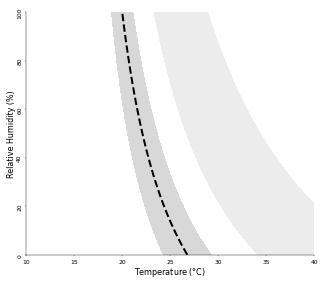

In [ ]:
xx, yy = np.mgrid[10:50:2000j, 0:101:2000j]
thom = (1.8 * xx + 32) - ( (0.55 - 0.0055 * yy) * (1.8 * xx - 26) )
#thom = 0.80*xx + xx*(yy/100) - 1.43*(yy/100) + 46.4

x = np.zeros_like(xx)
for breakpoint in df.breakpoint.values: x[breakpoint<thom] += 1
x = x/len(df.breakpoint.values) * 100

plt.close('all')
plt.rcParams.update( {'font.size': 8, 'xtick.labelsize' : 6, 'ytick.labelsize' : 6, 'legend.fontsize': 6, 'legend.frameon': False, 
                     'axes.linewidth':0.4, 'xtick.major.width':0.4, 'ytick.major.width':0.4, 'xtick.major.size':1, 'ytick.major.size':1,
                     'xtick.bottom': True, 'xtick.top': False, 'ytick.right': False, 'ytick.right': False, 'legend.numpoints': 4,
                     'xtick.major.pad':3, 'ytick.major.pad':3, 'axes.labelpad':1,'xtick.direction': 'out', 'ytick.direction': 'out', 
                      'axes.edgecolor': 'black','ytick.color': 'black','xtick.color': 'black', 'hatch.color': 'gray' } )

fig = plt.figure( figsize = ( 4*1.29, 4*1.29, ) )
gs = GridSpec( 2, 3, height_ratios = [1, 0.05], width_ratios = [0.05, 1, 0.55] )
gs.update( wspace = 0, hspace = 0.2 )

ax1 = plt.subplot( gs[0,:] )

#plt.contourf( xx, yy, thom, levels = [74,84], hatches = '////////////////', color = 'gray', alpha = 0, zorder = 2)
#plt.contour( xx, yy, thom, levels = [74], linewidths = 1, colors = 'gray',  alpha = 1, zorder = 2)
#plt.contour( xx, yy, thom, levels = [84], linewidths = 1, colors = 'gray',  alpha = 1, zorder = 2)

plt.contourf( xx, yy, thom, levels = [74,84], colors = 'gray', alpha = 0.15, zorder = 2 )
#plt.contour( xx, yy, thom, levels = [74], linewidths = 2, colors = '#434343',  linestyles ='--',  alpha = 1, zorder = 2)

colors = ['#377eb8','#ff7f00','#e41a1c']
#plt.contour( xx, yy, thom, levels = [pro],  linewidths = 2, colors = colors[0], linestyles ='--', alpha = 1, zorder = 2)
#plt.contour( xx, yy, thom, levels = [fer],  linewidths = 2, colors = colors[1], linestyles ='--', alpha = 1, zorder = 2)
#plt.contour( xx, yy, thom, levels = [mort], linewidths = 2, colors = colors[2], linestyles ='--', alpha = 1, zorder = 2)
plt.contourf( xx, yy, thom, levels = [66,70], colors = 'gray', alpha = 0.3, zorder = 2 )
plt.contour( xx, yy, thom, levels = [68], linewidths = 2, colors = 'black', linestyles ='--', alpha = 1, zorder = 2)
#'#00b0f1'

colors = [rgb2hex(i) for i in px.colors.sequential.deep] #dense
per_levels = np.linspace( 5, 95, 13 )
cmap, norm = flc( per_levels, colors )

#plt.contourf( xx, yy, x, levels = per_levels, cmap = cmap, alpha = 0.8, zorder = 0 )

plt.ylim( 0, 100 )
plt.xlim( 10, 40 )
plt.xlabel( 'Temperature ($\degree$C)' )
plt.ylabel( 'Relative Humidity (%)' )
sns.despine( offset = 0, trim = True )
plt.yticks( rotation = 90, va = 'center' )

#ax2 = plt.subplot( gs[1,1] )
#CB = plt.colorbar( cax = ax2, ticks = [5, 20, 35.5, 50, 65.5, 80, 95], orientation = "horizontal" )
#CB.ax.set_xticklabels( ['5','20','35.5','50','65.5','80','95'] )
#CB.ax.tick_params( labelsize = 7 )
#CB.set_label( '% of published onset thresholds', fontsize = 7 )

plt.savefig( '/content/drive/My Drive/figures/livestock/Figure1b.png', dpi = 700, bbox_inches = 'tight', pad_inches = 0 )

In [ ]:
thom

In [ ]:
mor = df[df['Mortality (Y/N)'] == 'Y']
fer = df[df['Fertility (Y/N)'] == 'Y']
pro = df[df['Production (Y/N)'] == 'Y']

level1 = np.sort(pro.break_adj.values)
level2 = np.sort(fer.break_adj.values)
level3 = np.sort(mor.break_adj.values)

for i in range(1,level1.shape[0]):  
    if level1[i] == level1[i-1]: level1[i] = level1[i] + 0.1
    elif level1[i] < level1[i-1]: level1[i] = level1[i-1] + 0.1

for i in range(1,level2.shape[0]):  
    if level2[i] == level2[i-1]: level2[i] = level2[i] + 0.1
    elif level2[i] < level2[i-1]: level2[i] = level2[i-1] + 0.1

for i in range(1,level3.shape[0]):  
    if level3[i] == level3[i-1]: level3[i] = level3[i] + 0.1
    elif level3[i] < level3[i-1]: level3[i] = level3[i-1] + 0.1

plt.close('all')
plt.rcParams.update( {'font.size': 8, 'xtick.labelsize' : 6, 'ytick.labelsize' : 6, 'legend.fontsize': 6, 'legend.frameon': False, 
                     'axes.linewidth':0.3, 'xtick.major.width':0.3, 'ytick.major.width':0.3, 'xtick.major.size':1, 'ytick.major.size':1,
                     'xtick.bottom': True, 'xtick.top': False, 'ytick.right': False, 'ytick.right': False, 'legend.numpoints': 4,
                     'xtick.major.pad':3, 'ytick.major.pad':3, 'axes.labelpad':3,'xtick.direction': 'out', 'ytick.direction': 'out', 
                      'axes.edgecolor': 'black','ytick.color': 'black','xtick.color': 'black'})

fig = plt.figure( figsize = ( 2, 2 ) )
colors = ['#377eb8','#ff7f00','#e41a1c']

plt.contour( xx, yy, thom, levels = level1, colors = colors[0], linewidths=0.5, alpha = 0.5, zorder = 2)
plt.contour( xx, yy, thom, levels = level2, colors = colors[1], linewidths=0.5, alpha = 0.5, zorder = 1)
plt.contour( xx, yy, thom, levels = level3, colors = colors[2], linewidths=0.5, alpha = 0.5, zorder = 1)

#plt.contour( xx, yy, thom, levels = [74], linewidths = 2, colors = 'black',  alpha = 1, zorder = 0)
#plt.contourf( xx, yy, thom, levels = [74,84], colors = 'gray', alpha = 0.3, zorder = 0 )

plt.ylim(0,100)
plt.xlim(15,45)
plt.yticks([0,20,40,60,80,100],[])
plt.xticks([15,20,25,30,35,40,45],[])
sns.despine( offset = 0, trim = True )
plt.savefig( '/content/drive/My Drive/figures/livestock/Figure2_inset.png', dpi = 700, bbox_inches = 'tight', pad_inches = 0 )

In [ ]:
mor = df[df['Mortality (Y/N)'] == 'Y']
fer = df[df['Fertility (Y/N)'] == 'Y']
pro = df[df['Production (Y/N)'] == 'Y']

level1 = np.sort(pro.break_adj.values)
level2 = np.sort(fer.break_adj.values)
level3 = np.sort(mor.break_adj.values)

for i in range(1,level1.shape[0]):  
    if level1[i] == level1[i-1]: level1[i] = level1[i] + 0.1
    elif level1[i] < level1[i-1]: level1[i] = level1[i-1] + 0.1

for i in range(1,level2.shape[0]):  
    if level2[i] == level2[i-1]: level2[i] = level2[i] + 0.1
    elif level2[i] < level2[i-1]: level2[i] = level2[i-1] + 0.1

for i in range(1,level3.shape[0]):  
    if level3[i] == level3[i-1]: level3[i] = level3[i] + 0.1
    elif level3[i] < level3[i-1]: level3[i] = level3[i-1] + 0.1

plt.close('all')
plt.rcParams.update( {'font.size': 8, 'xtick.labelsize' : 6, 'ytick.labelsize' : 6, 'legend.fontsize': 6, 'legend.frameon': False, 
                     'axes.linewidth':0.3, 'xtick.major.width':0.3, 'ytick.major.width':0.3, 'xtick.major.size':1, 'ytick.major.size':1,
                     'xtick.bottom': True, 'xtick.top': False, 'ytick.right': False, 'ytick.right': False, 'legend.numpoints': 4,
                     'xtick.major.pad':3, 'ytick.major.pad':3, 'axes.labelpad':3,'xtick.direction': 'out', 'ytick.direction': 'out', 
                      'axes.edgecolor': 'black','ytick.color': 'black','xtick.color': 'black'})

fig = plt.figure( figsize = ( 4, 4 ) )
colors = ['#377eb8','#ff7f00','#e41a1c']

plt.contour( xx, yy, thom, levels = level1, colors = colors[0], linewidths=1, alpha = 0.5, zorder = 2)
plt.contour( xx, yy, thom, levels = level2, colors = colors[1], linewidths=1, alpha = 0.5, zorder = 1)
plt.contour( xx, yy, thom, levels = level3, colors = colors[2], linewidths=1, alpha = 0.5, zorder = 1)

plt.xlabel( 'Temperature ($\degree$C)' )
plt.ylabel( 'Relative Humidity (%)' )

plt.ylim(0,100)
plt.xlim(15,45)
plt.yticks([0,20,40,60,80,100],[])
plt.xticks([15,20,25,30,35,40,45],[])
sns.despine( offset = 0, trim = True )
plt.savefig( '/content/drive/My Drive/figures/livestock/Figure2_inset.png', dpi = 700, bbox_inches = 'tight', pad_inches = 0 )

In [ ]:
plt.close('all')
plt.rcParams.update( {'font.size': 8, 'xtick.labelsize' : 6, 'ytick.labelsize' : 6, 'legend.fontsize': 6, 'legend.frameon': False, 
                     'axes.linewidth':0.3, 'xtick.major.width':0.3, 'ytick.major.width':0.3, 'xtick.major.size':1, 'ytick.major.size':1,
                     'xtick.bottom': True, 'xtick.top': False, 'ytick.right': False, 'ytick.right': False, 'legend.numpoints': 4,
                     'xtick.major.pad':3, 'ytick.major.pad':3, 'axes.labelpad':3,'xtick.direction': 'out', 'ytick.direction': 'out', 
                      'axes.edgecolor': 'black','ytick.color': 'black','xtick.color': 'black'})

fig = plt.figure( figsize = ( 4, 4 ) )
colors = [rgb2hex(i) for i in px.colors.sequential.YlOrRd]
levels = np.linspace(50,75,9)

for index, row in df.iterrows():
    y = row.thimean
    color = colors[np.argmin(np.abs(levels -  y))] 
    plt.contour( xx, yy, thom, levels = [row.break_adj], colors = color, linewidths=1, alpha = 0.7, zorder = 2)

plt.xlabel( 'Temperature ($\degree$C)' )
plt.ylabel( 'Relative Humidity (%)' )

plt.ylim(0,100)
plt.xlim(15,45)
plt.yticks([0,20,40,60,80,100],[])
plt.xticks([15,20,25,30,35,40,45],[])
sns.despine( offset = 0, trim = True )
plt.savefig( '/content/drive/My Drive/figures/livestock/Figure2_supplement_climate.png', dpi = 700, bbox_inches = 'tight', pad_inches = 0 )

In [ ]:
ind

In [ ]:
ind = df[df['Cattle breed type' ]== 'indicine']
tau = df[df['Cattle breed type'] == 'taurine']

level1 = np.sort(ind.break_adj.values)
level2 = np.sort(tau.break_adj.values)

for i in range(1,level1.shape[0]):  
    if level1[i] == level1[i-1]: level1[i] = level1[i] + 0.1
    elif level1[i] < level1[i-1]: level1[i] = level1[i-1] + 0.1

for i in range(1,level2.shape[0]):  
    if level2[i] == level2[i-1]: level2[i] = level2[i] + 0.1
    elif level2[i] < level2[i-1]: level2[i] = level2[i-1] + 0.1

plt.close('all')
plt.rcParams.update( {'font.size': 8, 'xtick.labelsize' : 6, 'ytick.labelsize' : 6, 'legend.fontsize': 6, 'legend.frameon': False, 
                     'axes.linewidth':0.3, 'xtick.major.width':0.3, 'ytick.major.width':0.3, 'xtick.major.size':1, 'ytick.major.size':1,
                     'xtick.bottom': True, 'xtick.top': False, 'ytick.right': False, 'ytick.right': False, 'legend.numpoints': 4,
                     'xtick.major.pad':3, 'ytick.major.pad':3, 'axes.labelpad':3,'xtick.direction': 'out', 'ytick.direction': 'out', 
                      'axes.edgecolor': 'black','ytick.color': 'black','xtick.color': 'black'})

fig = plt.figure( figsize = ( 4, 4 ) )
colors = [rgb2hex(i) for i in px.colors.sequential.YlOrRd]
levels = np.linspace(50,75,9)

plt.contour( xx, yy, thom, levels = level1, colors = 'red', linewidths=1, alpha = 0.5, zorder = 2)
plt.contour( xx, yy, thom, levels = level2, colors = 'black', linewidths=1, alpha = 0.5, zorder = 1)

plt.xlabel( 'Temperature ($\degree$C)' )
plt.ylabel( 'Relative Humidity (%)' )

plt.ylim(0,100)
plt.xlim(15,45)
plt.yticks([0,20,40,60,80,100],[])
plt.xticks([15,20,25,30,35,40,45],[])
sns.despine( offset = 0, trim = True )
plt.savefig( '/content/drive/My Drive/figures/livestock/Figure2_supplement_breed.png', dpi = 700, bbox_inches = 'tight', pad_inches = 0 )

In [ ]:
df['Cattle breed type'].unique()

# map

In [ ]:
img = cv2.imread('/content/drive/My Drive/data/livestock/FAO_distribution/6_Ct_2010_Aw.tif', cv2.IMREAD_UNCHANGED)
area = cv2.imread('/content/drive/My Drive/data/livestock/FAO_distribution/8_Areakm.tif', cv2.IMREAD_UNCHANGED)
img = img / area
img = np.flip( img, axis = 0 )
img = np.ma.masked_where( img < 0, img )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

overflow encountered in true_divide



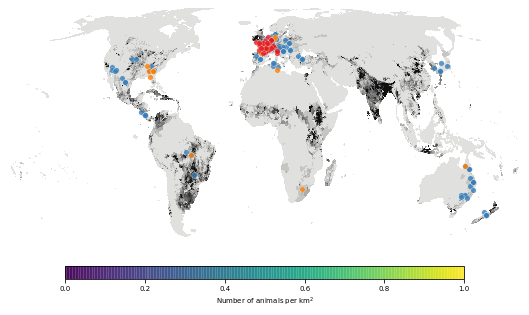

In [ ]:
img = cv2.imread('/content/drive/My Drive/data/livestock/FAO_distribution/6_Ct_2010_Aw.tif', cv2.IMREAD_UNCHANGED)
area = cv2.imread('/content/drive/My Drive/data/livestock/FAO_distribution/8_Areakm.tif', cv2.IMREAD_UNCHANGED)
img = img / area
img = np.flip( img, axis = 0 )
img = np.ma.masked_where( img < 0, img )

df = pd.read_csv('/content/drive/My Drive/data/livestock/digitized_breakpoints_connverted.csv')
df = df.rename(columns={'long':'lon'})

df2 = pd.read_csv('/content/drive/My Drive/data/livestock/milk_yield_impact_studies.csv')
#df2 = df2[df2['Included in breakpoint calculation'] != 'x' ]
df2 = df2[['lat','lon','Breakpoint']]
df2 = df2.dropna()
df2['Production'] = 'x'

df = pd.concat([df,df2])

df['lat'].where(df.duplicated( ['lat']), lambda x: x+np.random.randn()*5, inplace=True, axis=0)
df['lon'].where(df.duplicated( ['lon']), lambda x: x+np.random.randn()*5, inplace=True, axis=0)

mort = df[df['Mortality'] == 'x' ]
fer = df[df['Fertility'] == 'x' ]
pro = df[df['Production'] == 'x']

plt.close('all')
fig = plt.figure( figsize = ( 10, 5 ) )

colors = [rgb2hex(i) for i in px.colors.sequential.gray_r][1:]
levels = np.linspace( 1, 100, 11 )
img[ img > 102 ] = 102
cmap, norm = flc( levels = levels, colors = colors, extend = 'max')

gs = GridSpec(2, 3, height_ratios = [1, 0.05], width_ratios = [0.2, 1, 0.2] )
gs.update( wspace = 0, hspace = 0.01)

m = Basemap( projection = 'eck4', lon_0 = 0, resolution = 'l' )
lat = np.linspace( -90, 90, img.shape[0] )
lon = np.linspace( -180, 180, img.shape[1] )
lon2d, lat2d = np.meshgrid( lon, lat )
x, y = m( lon2d, lat2d )

ax1 = plt.subplot( gs[0, 0:3] )
m.drawmapboundary( fill_color = 'white', color = 'white', linewidth = 0.0 )
m.pcolormesh( x, y, img, cmap = cmap, zorder = 10, alpha = 0.7)

scatcolors = ['#377eb8','#ff7f00','#e41a1c']
xa, ya = m( pro.lon.values, pro.lat.values )
plt.scatter( xa, ya, s = 30, facecolors = scatcolors[0], edgecolors = 'white', lw = 0.3, zorder = 20, alpha = 0.8 )

xa, ya = m( fer.lon.values, fer.lat.values )
plt.scatter( xa, ya, s = 30, facecolors = scatcolors[1], edgecolors = 'white', lw = 0.3, zorder = 20, alpha = 0.8 )
xa, ya = m( mort.lon.values, mort.lat.values )
plt.scatter( xa, ya, s = 30, facecolors = scatcolors[2], edgecolors = 'white', lw = 0.3, zorder = 20, alpha = 0.8 )

ax2 = plt.subplot( gs[1, 1] )
CB = plt.colorbar( cax = ax2, orientation = "horizontal" )
CB.ax.tick_params( labelsize = 7 )
CB.set_label( 'Number of animals per km$^2$', fontsize = 7 )

plt.savefig( '/content/drive/MyDrive/figures/livestock/cow_density.png', dpi = 700, bbox_inches = 'tight', pad_inches = 0.01 )

# Scatter

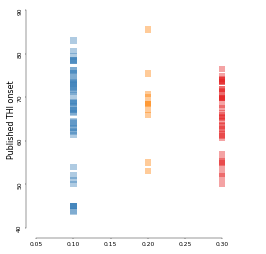

In [ ]:
plt.close('all')
fig = plt.figure( figsize = ( 4, 4 ) )

df = pd.read_csv('/content/drive/My Drive/data/livestock/digitized_breakpoints_connverted.csv')
df = df.rename(columns={'long':'lon'})

mort = df[df['Mortality'] == 'x' ]
fer = df[df['Fertility'] == 'x' ]
pro = df[df['Production'] == 'x']

plt.scatter( np.full_like(fer.breakpoint.values, 0.2),  fer.breakpoint.values, s = 40, marker = 's', facecolors = scatcolors[1], edgecolors = 'none', lw = 0.3, zorder = 20, alpha = 0.4 )
plt.scatter( np.full_like(pro.breakpoint.values, 0.1),  pro.breakpoint.values, s = 40, marker = 's', facecolors = scatcolors[0], edgecolors = 'none', lw = 0.3, zorder = 20, alpha = 0.4 )
plt.scatter( np.full_like(mort.breakpoint.values, 0.3), mort.breakpoint.values, s =40, marker = 's', facecolors = scatcolors[2], edgecolors = 'none', lw = 0.3, zorder = 20, alpha = 0.4 )

#plt.scatter( np.median(fer.breakpoint.values), 0.2,  marker = '|', s = 100, facecolors = scatcolors[1], edgecolors = 'white', lw = 0.3, zorder = 20, alpha = 1 )
#plt.scatter( np.median(pro.breakpoint.values), 0.1, marker = '|', s = 100, facecolors = scatcolors[0], edgecolors = 'white', lw = 0.3, zorder = 20, alpha = 1 )
#plt.scatter( np.median(mort.breakpoint.values),  0.3, marker = '|', s = 100, facecolors = scatcolors[2], edgecolors = 'white', lw = 0.3, zorder = 20, alpha = 1 )

plt.xlim( 0.05, 0.35 )
plt.ylim( 40, 90 )
plt.ylabel( 'Published THI onset' )
sns.despine( offset = 10, trim = True )
plt.yticks( rotation = 90, va = 'center' )

plt.savefig( '/content/drive/My Drive/figures/livestock/Figure1d.png', dpi = 700, bbox_inches = 'tight', pad_inches = 0 )

# ISOTYPE

In [ ]:
df = pd.read_csv('/content/drive/My Drive/data/livestock/impacts.csv' )
df = df[['Citation','Year','lat','lon','thieq', 'Jim_breakpoint', 'Species for Jim','Jim_for using','Cattle breed type','day_3day_month', 'mean_or_max','Mortality (Y/N)','Fertility (Y/N)','Production (Y/N)']]
df = df.replace({'cattle ':'cattle'})
df = df[df['Species for Jim'] == 'cattle']
df = df[df['Jim_for using'] == 'Y']
df = df[df.mean_or_max != 'min']
df.Jim_breakpoint = pd.to_numeric(df.Jim_breakpoint, errors='coerce')
df = df.dropna(subset=['Jim_breakpoint'])
df = df[['Citation','Year','Mortality (Y/N)','Fertility (Y/N)','Production (Y/N)']]
studies = df.Citation.unique()
df1 = df.copy()
df1.Year = pd.to_numeric(df1.Year)
df1.sort_values(by ='Year')

In [ ]:
df = pd.read_csv('/content/drive/My Drive/data/livestock/impacts.csv' )
df = df[['Citation','Year','lat','lon','thieq', 'Jim_breakpoint', 'Species for Jim','Jim_for using','Cattle breed type','day_3day_month', 'mean_or_max','Mortality (Y/N)','Fertility (Y/N)','Production (Y/N)']]
df = df.replace({'cattle ':'cattle'})
df = df[df['Species for Jim'] == 'cattle']
df = df[df['Jim_for using'] == 'Y']
df = df[df.mean_or_max != 'min']
df.Jim_breakpoint = pd.to_numeric(df.Jim_breakpoint, errors='coerce')
df = df.dropna(subset=['Jim_breakpoint'])
df = df[['Citation','Year','Mortality (Y/N)','Fertility (Y/N)','Production (Y/N)']]
studies = df.Citation.unique()
df1 = df.copy()
df1.Year = pd.to_numeric(df1.Year)
mor = df1[df1['Mortality (Y/N)'] == 'Y']
fer = df1[df1['Fertility (Y/N)'] == 'Y']
pro = df1[df1['Production (Y/N)'] == 'Y']

df = pd.read_csv('/content/drive/My Drive/data/livestock/all_lit.csv' )
df = df[['Citation','Pub year','Species']].rename(columns = {'Pub year':'Year'})
df = df.replace({'cattle ':'cattle'})
df = df[df.Species == 'cattle']
df = df[~df.Citation.isin(studies)]

df = pd.concat( (df, pro, fer, mor) )

df.Year[df.Year < 2000] = 1998
df.tail

In [ ]:
df[df.Year == 1998]

In [ ]:
def recolor(im, hex):
    rgb = hex2rgb(hex)
    imred = im[:,:,2]
    imgreen = im[:,:,1]
    imblue = im[:,:,0]
    imred[imred<255] = rgb[0]
    imgreen[imgreen<255] = rgb[1]
    imblue[imblue<255] = rgb[2]
    im = np.concatenate( ( imred[:,:,np.newaxis], imgreen[:,:,np.newaxis], imblue[:,:,np.newaxis]), axis = 2 )
    return im

colors = ['#377eb8','#ff7f00','#e41a1c']
im = cv2.imread('/content/drive/My Drive/figures/livestock/cow.png', cv2.IMREAD_COLOR)
cow1 = recolor( im, colors[0] )
im = cv2.imread('/content/drive/My Drive/figures/livestock/cow.png', cv2.IMREAD_COLOR)
cow2 = recolor( im, colors[1] )
im = cv2.imread('/content/drive/My Drive/figures/livestock/cow.png', cv2.IMREAD_COLOR)
cow3 = recolor( im, colors[2] )

im = cv2.imread('/content/drive/My Drive/figures/livestock/cow.png', cv2.IMREAD_COLOR)
cow4 = recolor( im, '#bdbdbd' )

In [ ]:
plt.close('all')
fig = plt.figure( figsize = ( 10, 6 ) )
gs = GridSpec( 33, 23, wspace = 0.02, hspace = 0.02 )

for i, year in enumerate(range(1998,2021)):
    df1 = df[df.Year == year]#.sort_values(by=)
    r = 0
    for index, row in df1.iterrows(): 
        print(r)
        if row['Mortality (Y/N)'] == 'Y': x = cow3
        elif row['Fertility (Y/N)'] == 'Y': x = cow2
        elif row['Production (Y/N)'] == 'Y': x = cow1
        else:  x = cow4
        ax1 = plt.subplot( gs[32-r, i] )
        plt.imshow( x, alpha = 0.8 )
        plt.axis('off')
        r = r + 1

plt.savefig( '/content/drive/My Drive/figures/livestock/icons.png', dpi = 700, bbox_inches = 'tight', pad_inches = 0,  transparent = True )

In [ ]:
colors = px.colors.qualitative.Antique
def recolor(im, rgbstring):
    s = rgbstring.split('(')[1].split(',')
    imred = im[:,:,2]
    imgreen = im[:,:,1]
    imblue = im[:,:,0]
    imred[imred<255] = np.int(s[0])
    imgreen[imgreen<255] = np.int(s[1])
    imblue[imblue<255] = np.int(s[2].split(')')[0])
    im = np.concatenate( ( imred[:,:,np.newaxis], imgreen[:,:,np.newaxis], imblue[:,:,np.newaxis]), axis = 2 )
    return im

colors = px.colors.qualitative.Plotly
def recolor(im, hex):
    rgb = hex2rgb(hex)
    imred = im[:,:,2]
    imgreen = im[:,:,1]
    imblue = im[:,:,0]
    imred[imred<255] = rgb[0]
    imgreen[imgreen<255] = rgb[1]
    imblue[imblue<255] = rgb[2]
    im = np.concatenate( ( imred[:,:,np.newaxis], imgreen[:,:,np.newaxis], imblue[:,:,np.newaxis]), axis = 2 )
    return im

im = cv2.imread('/content/drive/My Drive/figures/livestock/cow.png', cv2.IMREAD_COLOR)
cow = recolor( im, colors[0] )
im = cv2.imread('/content/drive/My Drive/figures/livestock/buffalo.png', cv2.IMREAD_COLOR)
buffalo = recolor( im, colors[1] )
im = cv2.imread('/content/drive/My Drive/figures/livestock/chicken.png', cv2.IMREAD_COLOR)
chicken = recolor( im, colors[2] )
im = cv2.imread('/content/drive/My Drive/figures/livestock/goat.png', cv2.IMREAD_COLOR)
goat = recolor( im, colors[3] )
im = cv2.imread('/content/drive/My Drive/figures/livestock/pig.png', cv2.IMREAD_COLOR)
pig = recolor( im, colors[4] )
im = cv2.imread('/content/drive/My Drive/figures/livestock/sheep.png', cv2.IMREAD_COLOR)
sheep = recolor( im, colors[5] )

In [ ]:
plt.close('all')
fig = plt.figure( figsize = ( 10, 5 ) )

colors = [rgb2hex(i) for i in px.colors.sequential.gray_r][1:]
levels = np.linspace( 1, 100, 11 )
img[ img > 102 ] = 102
cmap, norm = flc( levels = levels, colors = colors, extend = 'max')

gs = GridSpec(2, 3, height_ratios = [1, 0.05], width_ratios = [0.2, 1, 0.2] )
gs.update( wspace = 0, hspace = 0.01)

m = Basemap( projection = 'eck4', lon_0 = 0, resolution = 'l' )
lat = np.linspace( -90, 90, img.shape[0] )
lon = np.linspace( -180, 180, img.shape[1] )
lon2d, lat2d = np.meshgrid( lon, lat )
x, y = m( lon2d, lat2d )

ax1 = plt.subplot( gs[0, 0:3] )
m.drawmapboundary( fill_color = 'white', color = 'white', linewidth = 0.0 )
m.pcolormesh( x, y, img, cmap = cmap, zorder = 10, alpha = 0.7)

scatcolors = [rgb2hex(i) for i in px.colors.qualitative.Antique]
scatcolors = px.colors.qualitative.Plotly
for i, animal in enumerate(animals):
    df1 = df[df.Species == animal]
    xa, ya = m( df1.lon.values, df1.lat.values )
    plt.scatter( xa, ya, s = 20, facecolors = scatcolors[i], edgecolors = 'white', lw = 0.3, zorder = 20, alpha = 0.8 )

ax2 = plt.subplot( gs[1, 1] )
CB = plt.colorbar( cax = ax2, orientation = "horizontal" )
CB.ax.tick_params( labelsize = 7 )
CB.set_label( 'Number of animals per km$^2$', fontsize = 7 )

plt.savefig( '/content/drive/My Drive/figures/livestock/cow_density.png', dpi = 700, bbox_inches = 'tight', pad_inches = 0 )

In [ ]:
plt.close('all')
plt.rcParams.update( {'font.size': 8, 'xtick.labelsize' : 6, 'ytick.labelsize' : 6, 'legend.fontsize': 6, 'legend.frameon': False, 
                     'axes.linewidth':0.4, 'xtick.major.width':0.4, 'ytick.major.width':0.4, 'xtick.major.size':1, 'ytick.major.size':1,
                     'xtick.bottom': True, 'xtick.top': False, 'ytick.right': False, 'ytick.right': False, 'legend.numpoints': 4,
                     'xtick.major.pad':3, 'ytick.major.pad':3, 'axes.labelpad':1,'xtick.direction': 'out', 'ytick.direction': 'out', 
                      'axes.edgecolor': 'black','ytick.color': 'black','xtick.color': 'black'})

fig = plt.figure( figsize = ( 5, 5.5 ) )
gs = GridSpec( 2, 3, height_ratios = [1, 0.05], width_ratios = [0.01, 1, 0.2] )
gs.update( wspace = 0, hspace = 0.2 )

ax1 = plt.subplot( gs[0,:] )
CS1 = plt.contour( xx, yy, thom, levels = [74], linewidths=1.5, colors = 'white', linestyles ='--', alpha = 1, zorder = 2)
fmt = {}
strs = ['Onset (NRC)']
for l, s in zip(CS1.levels, strs): fmt[l] = s
#plt.clabel(CS1, inline=3, fmt=fmt, fontsize=7, manual = [(33, 18)] )

CS2 = plt.contour( xx, yy, thom, levels = [84], linewidths=1.5, colors = 'black', linestyles ='--', alpha = 1, zorder = 2)
fmt = {}
strs = [ 'Severe (NRC)']
for l, s in zip(CS2.levels, strs): fmt[l] = s
#plt.clabel(CS2, inline=1, fmt=fmt, fontsize=7, manual = [(40,20)] )

#CS3 = plt.contour( xx, yy, thom, levels = [68], linewidths=1, colors = 'black', linestyles ='--', alpha = 1, zorder = 2)
fmt = {}
strs = ['Production median']
for l, s in zip(CS3.levels, strs): fmt[l] = s
#plt.clabel(CS3, inline=1, fmt=fmt, fontsize=7, manual = [(20, 40)] )

#CS4 = plt.contour( xx, yy, thom, levels = [67], linewidths=1, colors = 'black', linestyles ='--', alpha = 1, zorder = 2)
fmt = {}
strs = ['Fertility median']
for l, s in zip(CS4.levels, strs): fmt[l] = s
#plt.clabel(CS4, inline=1, fmt=fmt, fontsize=7, manual = [(20, 40)] )

CS5 = plt.contour( xx, yy, thom, levels = [68], linewidths=1, colors = 'black', linestyles ='--', alpha = 1, zorder = 2)
fmt = {}
strs = ['Mortality median']
for l, s in zip(CS5.levels, strs): fmt[l] = s
#plt.clabel(CS5, inline=1, fmt=fmt, fontsize=7, manual = [(20, 40)] )

colors = [rgb2hex(i) for i in px.colors.sequential.deep] #dense
per_levels = np.linspace( 0, 100, 13 )
cmap, norm = flc( per_levels, colors )

plt.contourf( xx, yy, x, levels = per_levels, cmap = cmap, alpha = 0.85, zorder = 0 )

plt.ylim( 0, 100 )
plt.ylim( 5, 50 )
plt.xlabel( 'Temperature ($\degree$C)' )
plt.ylabel( 'Relative Humidity (%)' )
sns.despine( offset = 2, trim = True )
plt.yticks( rotation = 90, va = 'center' )

ax2 = plt.subplot( gs[1,1] )
CB = plt.colorbar( cax = ax2, ticks = [1, 50, 100], orientation = "horizontal" )
CB.ax.set_xticklabels( ['0','50','100'] )
CB.ax.tick_params( labelsize = 7 )
CB.set_label( '% of published onset thresholds', fontsize = 7 )

plt.savefig( '/content/drive/My Drive/figures/livestock/Figure1b.png', dpi = 700, bbox_inches = 'tight', pad_inches = 0 )

In [ ]:
plt.close('all')
plt.rcParams.update( {'font.size': 8, 'xtick.labelsize' : 6, 'ytick.labelsize' : 6, 'legend.fontsize': 6, 'legend.frameon': False, 
                     'axes.linewidth':0.4, 'xtick.major.width':0.4, 'ytick.major.width':0.4, 'xtick.major.size':1, 'ytick.major.size':1,
                     'xtick.bottom': True, 'xtick.top': False, 'ytick.right': False, 'ytick.right': False, 'legend.numpoints': 4,
                     'xtick.major.pad':3, 'ytick.major.pad':3, 'axes.labelpad':1,'xtick.direction': 'out', 'ytick.direction': 'out', 
                      'axes.edgecolor': 'black','ytick.color': 'black','xtick.color': 'black'})

fig = plt.figure( figsize = ( 5, 5.5 ) )
gs = GridSpec( 2, 3, height_ratios = [1, 0.05], width_ratios = [0.4, 1, 0.05] )
gs.update( wspace = 0, hspace = 0.2 )

ax1 = plt.subplot( gs[0,:] )
CS1 = plt.contour( xx, yy, thom, levels = [74], linewidths=1.5, colors = 'white', linestyles ='--', alpha = 1, zorder = 2)
fmt = {}
strs = ['Onset (NRC)']
for l, s in zip(CS1.levels, strs): fmt[l] = s
#plt.clabel(CS1, inline=3, fmt=fmt, fontsize=7, manual = [(33, 18)] )

CS2 = plt.contour( xx, yy, thom, levels = [84], linewidths=1.5, colors = 'black', linestyles ='--', alpha = 1, zorder = 2)
fmt = {}
strs = [ 'Severe (NRC)']
for l, s in zip(CS2.levels, strs): fmt[l] = s
#plt.clabel(CS2, inline=1, fmt=fmt, fontsize=7, manual = [(40,20)] )

#CS3 = plt.contour( xx, yy, thom, levels = [68], linewidths=1, colors = 'black', linestyles ='--', alpha = 1, zorder = 2)
fmt = {}
strs = ['Production median']
for l, s in zip(CS3.levels, strs): fmt[l] = s
#plt.clabel(CS3, inline=1, fmt=fmt, fontsize=7, manual = [(20, 40)] )

#CS4 = plt.contour( xx, yy, thom, levels = [67], linewidths=1, colors = 'black', linestyles ='--', alpha = 1, zorder = 2)
fmt = {}
strs = ['Fertility median']
for l, s in zip(CS4.levels, strs): fmt[l] = s
#plt.clabel(CS4, inline=1, fmt=fmt, fontsize=7, manual = [(20, 40)] )

CS5 = plt.contour( xx, yy, thom, levels = [68], linewidths=1, colors = 'black', linestyles ='--', alpha = 1, zorder = 2)
fmt = {}
strs = ['Mortality median']
for l, s in zip(CS5.levels, strs): fmt[l] = s
#plt.clabel(CS5, inline=1, fmt=fmt, fontsize=7, manual = [(20, 40)] )

colors = [rgb2hex(i) for i in px.colors.sequential.deep] #dense
per_levels = np.linspace( 0, 100, 13 )
cmap, norm = flc( per_levels, colors )

plt.contourf( xx, yy, x, levels = per_levels, cmap = cmap, alpha = 0.95, zorder = 0 )

plt.ylim( 0, 100 )
plt.ylim( 5, 50 )
plt.xlabel( 'Temperature ($\degree$C)' )
plt.ylabel( 'Relative Humidity (%)' )
sns.despine( offset = 2, trim = True )
plt.yticks( rotation = 90, va = 'center' )

ax2 = plt.subplot( gs[1,1] )
CB = plt.colorbar( cax = ax2, ticks = [1, 50, 99], orientation = "horizontal" )
CB.ax.set_xticklabels( ['0','50','100'] )
CB.ax.tick_params( labelsize = 7 )
CB.set_label( '% of published onset thresholds', fontsize = 7 )

plt.savefig( '/content/drive/My Drive/figures/livestock/Figure1b.png', dpi = 700, bbox_inches = 'tight', pad_inches = 0 )

In [ ]:
colors = [rgb2hex(i) for i in px.colors.sequential.deep]
per_levels = np.linspace( 1, 99, 13 )
cmap, norm = flc( per_levels, colors )

In [ ]:
df = pd.read_csv('/content/drive/My Drive/data/livestock/HadISD/breakpoints_with_min_mean_max.csv' )
df = df[df.day_3day_month != 'month']
df = df[ df.Citation != 'Bertocchi et al 2014' ]
df = df[ df.Citation != 'Hubbard et al., 1999' ]

newbreaks = []
for i,row in df.iterrows():
    if row.mean_or_max == 'max': newbreak = row.Jim_breakpoint -  (row.thimax - row.thimean)
    elif row.mean_or_max == 'min': newbreak = row.Jim_breakpoint + (row.thimean - row.thimin)
    else: newbreak = row.Jim_breakpoint
    newbreaks.append(newbreak)

df['newbreak'] = newbreaks

colors = [rgb2hex(i) for i in px.colors.sequential.deep]
#colors = px.colors.sequential.Plotly3
colors = ['#377eb8','#ff7f00','#e41a1c']

newcolors = []
for i,row in df.iterrows():
    if row['Production (Y/N)'] == 'Y': newbreak = colors[0]
    elif row['Fertility (Y/N)'] == 'Y': newbreak = colors[1]
    elif row['Mortality (Y/N)'] == 'Y': newbreak = colors[2]
    else:  newbreak = colors[0]
    newcolors.append(newbreak)

df['newcolor'] = newcolors

#df = df.replace({ 'kibler': 'thom'})

df1 = df[df.Orig_source_JF =='thom']
df1 = df1.sort_values( by = 'newbreak' )
df2 = df[df.Orig_source_JF =='kelly']
df2 = df2.sort_values( by = 'newbreak' )
df3 = df[df.Orig_source_JF =='kibler']
df3 = df3.sort_values( by = 'newbreak' )

level1 = df1.newbreak.values 
for i in range(1,level1.shape[0]):  
    if level1[i] == level1[i-1]: level1[i] = level1[i] + 0.05
    elif level1[i] < level1[i-1]: level1[i] = level1[i-1] + 0.05

level2 =  df2.newbreak.values 
for i in range(1,level2.shape[0]):  
    if level2[i] == level2[i-1]: level2[i] = level2[i] + 0.05
    elif level2[i] < level2[i-1]: level2[i] = level2[i-1] + 0.05

level2 =  df2.newbreak.values 
for i in range(1,level2.shape[0]):  
    if level2[i] == level2[i-1]: level2[i] = level2[i] + 0.05
    elif level2[i] < level2[i-1]: level2[i] = level2[i-1] + 0.05

df2.newbreak = [67.265, 67.27, 69.085, 78.055, 78.06]
df3.newbreak = [62.58, 82.995]

### with the kibler and kelly equations mannualy converted ###
levels = np.array([60., 60.05, 60.77, 61.77, 62.59, 62.77, 62.82, 62.87, 62.92, 62.97, 65., 65.55, 65.77, 66., 66.18, 66.85, 66.9 , 67.09, 
          67.27, 67.36, 67.77, 68.  , 68.05, 68.09, 68.19, 69., 69.05, 69.09, 69.1, 70. , 70.09, 71.85, 72.  , 72.05, 
          72.1 , 73.  , 73.05, 73.1 , 73.15, 73.2 , 74., 75., 76.5 , 77., 77.42, 78.05, 78.06, 79.09, 83.0])
levels = np.sort(levels)

df = pd.concat((df1,df2,df3))
df = df.sort_values( by = ['newbreak']) 

xx, yy = np.mgrid[5:50:2000j, 0:101:2000j]
thom = 0.80*xx + xx*(yy/100) - 1.43*(yy/100) + 46.4

plt.close('all')
plt.rcParams.update( {'font.size': 8, 'xtick.labelsize' : 6, 'ytick.labelsize' : 6, 'legend.fontsize': 6, 'legend.frameon': False, 
                     'axes.linewidth':0.3, 'xtick.major.width':0.3, 'ytick.major.width':0.3, 'xtick.major.size':1, 'ytick.major.size':1,
                     'xtick.bottom': True, 'xtick.top': False, 'ytick.right': False, 'ytick.right': False, 'legend.numpoints': 4,
                     'xtick.major.pad':3, 'ytick.major.pad':3, 'axes.labelpad':3,'xtick.direction': 'out', 'ytick.direction': 'out', 
                      'axes.edgecolor': 'black','ytick.color': 'black','xtick.color': 'black'})

fig = plt.figure( figsize = ( 2, 2 ) )

plt.contour( xx, yy, thom, levels = df.newbreak, linewidths=0.5, colors = df.newcolor, alpha = 1, zorder = 0)
plt.annotate('Production', xy = (30, 92), color = colors[0] , fontsize = 7 )
plt.annotate('Fertility', xy = (30, 84), color =colors[1], fontsize = 7 )
plt.annotate('Mortality', xy = (30, 76), color =colors[2], fontsize = 7 )

plt.ylim(0,101)
plt.xticks([5,10,15,20,25,30,35,40,45,50],[])
sns.despine( offset = 2, trim = True )
plt.yticks([0,20,40,60,80,100],[], rotation = 90, va = 'center')
plt.savefig( '/content/drive/My Drive/figures/livestock/Figure2_inset.png', dpi = 700, bbox_inches = 'tight', pad_inches = 0 )

In [ ]:
dft = df[df.newcolor==colors[3]]
dft.newbreak.median()

In [ ]:
dft = df[df.newcolor!=colors[3]]
dft.newbreak.median()

In [ ]:
xx, yy = np.mgrid[5:50:2000j, 0:101:2000j]
thom = 0.80*xx + xx*(yy/100) - 1.43*(yy/100) + 46.4

x = np.zeros_like(xx)
for level in levels: x[level<thom] += 1
x = x/len(levels) * 100

In [ ]:
plt.close('all')

colors = [rgb2hex(i) for i in px.colors.sequential.deep] #dense
per_levels = np.linspace( 1, 99, 13 )
cmap, norm = flc( per_levels, colors )

plt.rcParams.update( {'font.size': 8, 'xtick.labelsize' : 7, 'ytick.labelsize' : 7, 'legend.fontsize': 7, 'legend.frameon': False, 
                     'axes.linewidth':0.4, 'xtick.major.width':0.4, 'ytick.major.width':0.4, 'xtick.major.size':1.4, 'ytick.major.size':1.4,
                     'xtick.bottom': True, 'xtick.top': False, 'ytick.right': False, 'ytick.right': False, 'legend.numpoints': 4,
                     'xtick.major.pad':1.5, 'ytick.major.pad':1.5, 'axes.labelpad':1.5,'xtick.direction': 'out', 'ytick.direction': 'out', 
                      'axes.edgecolor':'black','ytick.color':'black','xtick.color':'black','font.sans-serif':"Helvetica",'font.family':"sans-serif"})


fig = plt.figure( figsize = ( 5, 5.6 ) )
gs = GridSpec(2, 3, height_ratios = [1, 0.05], width_ratios = [0.4, 1, 0.05] )
gs.update(wspace = 0, hspace = 0.25)

ax1 = plt.subplot( gs[0,:] )
CS = plt.contour( xx, yy, thom, levels = [74], linewidths=1, colors = 'white', linestyles ='--', alpha = 1, zorder = 1)
fmt = {}
strs = ['NRC Onset']
for l, s in zip(CS.levels, strs): fmt[l] = s
plt.clabel(CS, inline=3, fmt=fmt, fontsize=8, manual = [(33, 18)] )

CS2 = plt.contour( xx, yy, thom, levels = [84], linewidths=1, colors = 'gray', linestyles ='--', alpha = 1, zorder = 1)
fmt = {}
strs = [ 'NRC Severe']
for l, s in zip(CS2.levels, strs): fmt[l] = s
plt.clabel(CS2, inline=1, fmt=fmt, fontsize=8, manual = [(40,20)] )

CS1 = plt.contour( xx, yy, thom, levels = [67.9], linewidths=1, colors = 'black', linestyles ='--', alpha = 1, zorder = 2)
fmt = {}
strs = ['Production']
for l, s in zip(CS1.levels, strs): fmt[l] = s
plt.clabel(CS1, inline=1, fmt=fmt, fontsize=8, manual = [(20, 40)] )

CS1 = plt.contour( xx, yy, thom, levels = [73], linewidths=1, colors = 'black', linestyles ='--', alpha = 1, zorder = 2)
fmt = {}
strs = ['Mortality']
for l, s in zip(CS1.levels, strs): fmt[l] = s
plt.clabel(CS1, inline=1, fmt=fmt, fontsize=8, manual = [(26, 40)])

plt.ylim(0,101)
plt.xlabel('Temperature ($\degree$C)')
plt.ylabel('Relative Humidity (%)')
sns.despine( offset = 2, trim = True )
plt.yticks(rotation = 90, va = 'center')

#plt.contourf( xx, yy, x, levels = [74,84], hatches=['/'], colors = 'gray', zorder = 2)

plt.contourf( xx, yy, x, levels = per_levels, cmap = cmap, alpha = 0.8, zorder = 0)

ax2 = plt.subplot( gs[1,1] )
CB = plt.colorbar( cax = ax2, ticks = [1,50,99], orientation = "horizontal" )
CB.ax.set_xticklabels( ['1','50','99'] )
CB.ax.tick_params( labelsize = 7 )
CB.set_label('% of published onset thresholds', fontsize=8)

plt.savefig( '/content/drive/My Drive/figures/livestock/Figure2.png', dpi = 700, bbox_inches = 'tight', pad_inches = 0 )

In [ ]:
plt.close('all')
plt.rcParams.update( {'font.size': 8, 'xtick.labelsize' : 8, 'ytick.labelsize' : 8, 'legend.fontsize': 8, 'legend.frameon': False, 
                     'axes.linewidth':0.4, 'xtick.major.width':0.4, 'ytick.major.width':0.4, 'xtick.major.size':1.4, 'ytick.major.size':1.4,
                     'xtick.bottom': True, 'xtick.top': False, 'ytick.right': False, 'ytick.right': False, 'legend.numpoints': 4,
                     'xtick.major.pad':1, 'ytick.major.pad':1, 'axes.labelpad':0.2,'xtick.direction': 'out', 'ytick.direction': 'out', 
                      'axes.edgecolor': 'black','ytick.color': 'black','xtick.color': 'black'})


fig = plt.figure( figsize = ( 5, 10.5 ) )
gs = GridSpec(3, 3, height_ratios = [1, 1, 0.05], width_ratios = [0.4, 1, 0.05] )
gs.update(wspace = 0, hspace = 0.2)

ax0 = plt.subplot( gs[0,:] )
colors = ['#377eb8','#ff7f00','#e41a1c']
plt.contour( xx, yy, thom, levels = df.newbreak, linewidths=0.9, colors = df.newcolor, alpha = 1, zorder = 0)
plt.annotate('Production', xy = (40, 92), color = colors[0] , fontsize = 8 )
plt.annotate('Fertility', xy = (40, 86), color =colors[1], fontsize = 8 )
plt.annotate('Mortality', xy = (40, 80), color =colors[2], fontsize = 8 )

plt.ylim(0,101)
plt.xlabel('Temperature ($\degree$C)')
plt.ylabel('Relative Humidity (%)')
sns.despine( offset = 1, trim = True )
plt.yticks(rotation = 90, va = 'center')

colors = [rgb2hex(i) for i in px.colors.sequential.deep] #dense
per_levels = np.linspace( 1, 99, 13 )
cmap, norm = flc( per_levels, colors )

ax1 = plt.subplot( gs[1,:] )
CS = plt.contour( xx, yy, thom, levels = [74], linewidths=1.5, colors = 'white', linestyles ='--', alpha = 1, zorder = 2)
fmt = {}
strs = ['Onset (NRC)']
for l, s in zip(CS.levels, strs): fmt[l] = s
plt.clabel(CS, inline=3, fmt=fmt, fontsize=8, manual = [(33, 18)] )

CS2 = plt.contour( xx, yy, thom, levels = [84], linewidths=1.5, colors = 'black', linestyles ='--', alpha = 1, zorder = 2)
fmt = {}
strs = [ 'Severe (NRC)']
for l, s in zip(CS2.levels, strs): fmt[l] = s
plt.clabel(CS2, inline=1, fmt=fmt, fontsize=8, manual = [(40,20)] )

CS1 = plt.contour( xx, yy, thom, levels = [68.2], linewidths=1, colors = 'black', linestyles ='--', alpha = 1, zorder = 2)
fmt = {}
strs = ['Pub. median']
for l, s in zip(CS1.levels, strs): fmt[l] = s
plt.clabel(CS1, inline=1, fmt=fmt, fontsize=8, manual = [(20, 40)] )

plt.ylim(0,101)
plt.xlabel('Temperature ($\degree$C)')
plt.ylabel('Relative Humidity (%)')
sns.despine( offset = 1, trim = True )
plt.yticks(rotation = 90, va = 'center')

plt.contourf( xx, yy, x, levels = per_levels, cmap = cmap, alpha = 0.95, zorder = 0)

ax2 = plt.subplot( gs[2,1] )
CB = plt.colorbar( cax = ax2, ticks = [1,50,99], orientation = "horizontal" )
CB.ax.set_xticklabels( ['1','50','99'] )
CB.ax.tick_params( labelsize = 7 )
CB.set_label('% of published onset thresholds', fontsize=7)

plt.savefig( '/content/drive/My Drive/figures/livestock/Figure2.png', dpi = 700, bbox_inches = 'tight', pad_inches = 0 )



---

# OLD

---



In [ ]:
px.colors.sequential.swatches()

In [ ]:
plt.close('all')

plt.rcParams.update( {'font.size': 8, 'xtick.labelsize' : 8, 'ytick.labelsize' : 8, 'legend.fontsize': 8, 'legend.frameon': False, 
                     'axes.linewidth':0.4, 'xtick.major.width':0.4, 'ytick.major.width':0.4, 'xtick.major.size':1.4, 'ytick.major.size':1.4,
                     'xtick.bottom': True, 'xtick.top': False, 'ytick.right': False, 'ytick.right': False, 'legend.numpoints': 4,
                     'xtick.major.pad':1, 'ytick.major.pad':1, 'axes.labelpad':0.2,'xtick.direction': 'out', 'ytick.direction': 'out', 
                      'axes.edgecolor': 'black','ytick.color': 'black','xtick.color': 'black'})

fig = plt.figure( figsize = ( 5, 5 ) )
gs = GridSpec(1, 1, wspace = 0.02, hspace = 0.02 )

plt.contour( xx, yy, thom, levels = levels, linewidths=0.5, colors = 'black', alpha = 0.5, zorder = 1)
plt.contourf( xx, yy, thom, levels = [74,84], colors = '#4a86e8', alpha = 0.2, zorder = 1)

plt.ylim(0,101)
plt.xlabel('Temperature ($\degree$C)')
plt.ylabel('Relative Humidity (%)')
sns.despine( offset = 1, trim = True )
plt.yticks(rotation = 'vertical', rotation_mode="default")
plt.savefig( '/content/drive/My Drive/figures/livestock/Figure2.png', dpi = 700, bbox_inches = 'tight', pad_inches = 0 )

In [ ]:
Ta = 16.6
rh = 0.5
Ta - 0.55 * (rh) * (Ta - 14.5)

In [ ]:
thi = 16.0225
(thi + 14.5 * 0.55 * rh) / ( 1 - 0.55 * rh)

In [ ]:
14.5*0.55

In [ ]:
DI = 0.4 (td + tw) + 15

In [ ]:
Ta = 16.6
print(Ta - 0.55 * (0.5) * (Ta - 14.5))
Ta = 18
print(Ta - 0.55 * (0.5) * (Ta - 14.5))
Ta = 24.9
print(Ta - 0.55 * (0.5) * (Ta - 14.5))

Ta = 28.7
Tdp = 243.5 * (np.log(50/100) + ( ( 17.67 * Ta ) / ( 243.5 + Ta ) ) ) / ( 17.67 - np.log(50/100) - ( ( 17.67 * Ta ) / ( 243.5 + Ta ) ) )
print(1.00*Ta + 0.36*Tdp + 41.2)
Ta = 13
Tdp = 243.5 * (np.log(50/100) + ( ( 17.67 * Ta ) / ( 243.5 + Ta ) ) ) / ( 17.67 - np.log(50/100) - ( ( 17.67 * Ta ) / ( 243.5 + Ta ) ) )
print(1.00*Ta + 0.36*Tdp + 41.2)

Ta = 13
print(0.80*Ta + Ta*0.5 - 1.43*0.5 + 46.4)
Ta = 16.6
print(0.80*Ta + Ta*0.5 - 1.43*0.5 + 46.4)
Ta = 18
print(0.80*Ta + Ta*0.5 - 1.43*0.5 + 46.4)
Ta = 24.9
print(0.80*Ta + Ta*0.5 - 1.43*0.5 + 46.4)
Ta = 28.7
print(0.80*Ta + Ta*0.5 - 1.43*0.5 + 46.4)

In [ ]:
xx, yy = np.mgrid[0:45:100j, 0:101:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

Tdp = 243.5 * (np.log(yy/100) + ( ( 17.67 * xx ) / ( 243.5 + xx ) ) ) / ( 17.67 - np.log(yy/100) - ( ( 17.67 * xx ) / ( 243.5 + xx ) ) )
thom = 0.80*xx + xx*(yy/100) - 1.43*(yy/100) + 46.4
kibler = 1.00*xx + 0.36*Tdp + 41.2
kelly = xx - 0.55 * (1 -  (yy/100)) * (xx - 14.5) 

In [ ]:
plt.pcolormesh(kibler)

In [ ]:
plt.pcolormesh(thom - kibler, cmap=plt.cm.RdBu, vmin= -20, vmax=20)
plt.colorbar()



---

# OLD

---



In [ ]:
newdelhi  = '421820-9999' 
desmoines = '725460-1493'
paris     = '071560-9999'
london    = '037780-9999'
santarosa = '876230-9999'
edmondton = '711210-9999'
darwin    = '941200-9999'
douala    = '649100-9999'
portgenti = '645010-9999'
nairobi   = '637400-9999'
#sta[ sta.name.str.contains('NAIR') ]   # wildcard string comparison 

In [ ]:
sta = pd.read_fwf('/content/drive/My Drive/data/livestock/hadisd_station_fullinfo_v311_202001p.txt',
                  colspecs = [(0,11),(12,42),(43,50),(51,59),(60,67),(68,78),(79,89)],
                  names = ['ID','name','lat','lon','elv','start_date','end_date'])

sta = pd.read_fwf('/content/drive/My Drive/data/livestock/hadisd_station_info_v311_202008p.txt',
                  colspecs = [(0,11),(12,19),(20,29),(30,39)],
                  names = ['ID','lat','lon','elv'])

sta = sta.dropna()
new = sta.copy()

df = pd.read_csv('/content/drive/My Drive/data/livestock/literature.csv')
df = df[['Citation', 'lat','lon']]

df2 = pd.read_csv('/content/drive/My Drive/data/livestock/observational.csv')
df2 = df2[['Citation', 'Species', 'Orig_source_JF', 'day_3day_month','mean_or_max','Jim_breakpoint','Mortality (Y/N)', 'Fertility (Y/N)','Production (Y/N)']]
df = pd.merge( df, df2, on = 'Citation' )

df = df.dropna( subset=['Jim_breakpoint'] )
df = df.replace({ 'kiebler':'kibler', 'kibler ':'kibler' })
df = df[df.Species == 'cattle']

def get_path(sid):
    files = ['080000-099999','000000-029999','030000-049999','450000-499999','650000-699999','400000-449999',
            '350000-399999','300000-349999','200000-249999','250000-299999','100000-149999','150000-199999',
            '050000-079999','550000-599999','600000-649999','500000-549999','700000-709999','720000-722999',
            '710000-719999','723000-723999','726000-726999','725000-725999','724000-724999','730000-799999',
            '800000-849999','950000-999999','900000-949999','850000-899999','727000-729999']

    bins = np.zeros((len(files),2))
    for i, file in enumerate(files): bins[i,:] = np.array(file.split('-'), dtype=int) 

    sidn = np.int(sid[:6])
    for i,j in bins: 
        if (sidn > i) & (sidn < j): out = i,j
        else: pass
    
    b1 = out[0].astype(int).astype(str)
    b2 = out[1].astype(int).astype(str)

    if len(b1) == 5: 
        b1 = '0'+ b1
        b2 = '0'+ b2
    else: pass

    path = f'/content/drive/My Drive/data/livestock/HadISD/WMO_{b1}-{b2}_heat_stress/hadisd.3.1.1.202008p_19310101-20200901_{sid+sid[-1]}_heat_stress.nc'
    ds = xr.open_dataset( path )
    ds = ds.temperature_humidity_index

    ds = ds.where( (ds > 0) & (ds < 150) )
    thimax   = ds.resample(time = '1D').max().mean().values
    thimean  = ds.resample(time = '1D').mean().mean().values
    thimin   = ds.resample(time = '1D').min().mean().values
    thimean3 = ds.resample(time = '3D').mean().mean().values
    return thimax, thimean, thimin, thimean3

l = []
for index, row in df.iterrows():
    new['latlon'] = np.abs( new.lat-row.lat ) + np.abs( new.lon-row.lon )
    new.sort_values( 'latlon' , inplace=True)
    try: l.append(get_path(new.iloc[0].ID))
    except: 
        try: l.append(get_path(new.iloc[1].ID))
        except: 
            try: l.append(get_path(new.iloc[2].ID))
            except: 
                try: l.append(get_path(new.iloc[3].ID))
                except:
                    try: l.append(get_path(new.iloc[4].ID))
                    except: 
                        try: l.append(et_path(new.iloc[5].ID))
                        except: l.append(get_path(new.iloc[6].ID))

l = np.array(l)
df['thimax'] = l[:,0]
df['thimean'] = l[:,1]
df['thimin'] = l[:,2]
df['thimin3d'] = l[:,3]

#df= df.copy()
#df = df.rename(columns={'mean_or_max ': 'mean_or_max'})
df.to_csv('/content/drive/My Drive/data/livestock/HadISD/breakpoints_with_min_mean_max.csv', index = False )
df

In [ ]:
df = pd.read_csv('/content/drive/My Drive/data/livestock/HadISD/breakpoints_with_min_mean_max.csv' )
df = df[df.day_3day_month != 'month']
df = df[df.Citation != 	'Bertocchi et al 2014' ]

newbreaks = []
for i,row in df.iterrows():
    if row.mean_or_max == 'max': newbreak = row.Jim_breakpoint -  (row.thimax - row.thimean)
    elif row.mean_or_max == 'min': newbreak = row.Jim_breakpoint + (row.thimean - row.thimin)
    else: newbreak = row.Jim_breakpoint
    newbreaks.append(newbreak)

df['newbreak'] = newbreaks

newcolors = []
for i,row in df.iterrows():
    if row['Fertility (Y/N)'] == 'Y': newbreak = '#1b9e77'
    elif row['Production (Y/N)'] == 'Y': newbreak = '#7570b3'
    elif row['Mortality (Y/N)'] == 'Y': newbreak = '#d95f02'
    else:  newbreak = 'gray'
    newcolors.append(newbreak)


df['newcolor'] = newcolors

df1 = df[df.Orig_source_JF =='thom']
df1 = df1.sort_values( by = 'newbreak' )
df2 = df[df.Orig_source_JF =='kelly']
df2 = df2.sort_values( by = 'newbreak' )
df3 = df[df.Orig_source_JF =='kibler']
df3 = df3.sort_values( by = 'newbreak' )

level1 = df1.newbreak.values 
for i in range(1,level1.shape[0]):  
    if level1[i] == level1[i-1]: level1[i] = level1[i]+0.05
    elif level1[i] < level1[i-1]: level1[i] = level1[i-1]+0.05

level2 =  df2.newbreak.values 
for i in range(1,level2.shape[0]):  
    if level2[i] == level2[i-1]: level2[i] = level2[i]+0.05
    elif level2[i] < level2[i-1]: level2[i] = level2[i-1]+0.05

level3 = df3.newbreak.values 
for i in range(1,level3.shape[0]):  
    if level3[i] == level3[i-1]: level3[i] = level3[i]+0.05
    elif level3[i] < level3[i-1]: level3[i] = level3[i-1]+0.05

In [ ]:
dft = df[df.newcolor == px.colors.qualitative.D3[1]]
dft

In [ ]:
df3

In [ ]:
plt.close('all')

plt.rcParams.update( {'font.size': 8, 'xtick.labelsize' : 8, 'ytick.labelsize' : 8, 'legend.fontsize': 8, 'legend.frameon': False, 
                     'axes.linewidth':0.4, 'xtick.major.width':0.4, 'ytick.major.width':0.4, 'xtick.major.size':1.4, 'ytick.major.size':1.4,
                     'xtick.bottom': True, 'xtick.top': False, 'ytick.right': False, 'ytick.right': False, 'legend.numpoints': 4,
                     'xtick.major.pad':1, 'ytick.major.pad':1, 'axes.labelpad':0.2,'xtick.direction': 'out', 'ytick.direction': 'out', 
                      'axes.edgecolor': 'black','ytick.color': 'black','xtick.color': 'black'})

fig = plt.figure( figsize = ( 5, 5 ) )
gs = GridSpec(1, 1, wspace = 0.02, hspace = 0.02 )

#plt.contourf( xx, yy, f, cmap = 'Blues' )
plt.contour( xx, yy, thom, levels = level1, linewidths=1, colors = 'black', alpha = 0.7)
plt.contour( xx, yy, kelly, levels = level2, linewidths=1, colors = 'black', alpha = 0.7)
plt.contour( xx, yy, kibler, levels = level3, linewidths=1, colors = 'black', alpha = 0.7)
plt.contour( xx, yy, thom, levels = [74,84], linewidths=3, colors = 'blue', alpha = 1)

plt.ylim(0,101)
plt.xlabel('Temperature ($\degree$C)')
plt.ylabel('Relative Humidity (%)')
sns.despine( offset = 1, trim = True )
plt.yticks(rotation = 'vertical', rotation_mode="default")
plt.savefig( '/content/drive/My Drive/figures/livestock/Figure2.png', dpi = 700, bbox_inches = 'tight', pad_inches = 0 )

In [ ]:
px.colors.se

In [ ]:
ds = xr.open_dataset(f'/content/drive/My Drive/data/livestock/HadISD/old/hadisd.3.1.1.202007p_19310101-20200801_{edmondton}9.nc')
ds = ds.sel(time = slice('1985-01-01T12:00:00', '2014-12-30T12:00:00'))
temp = np.vstack((ds.temperatures,ds.dewpoints))
temp = np.ma.masked_outside( np.nan_to_num( temp ), 0, 60 )
edmon = np.ma.compress_cols( temp )

ds = xr.open_dataset(f'/content/drive/My Drive/data/livestock/HadISD/old/hadisd.3.1.1.202007p_19310101-20200801_{newdelhi}9.nc')
ds = ds.sel(time = slice('1985-01-01T12:00:00', '2014-12-30T12:00:00'))
RH  = 100*np.exp( ( 17.625 * ds.dewpoints ) / ( 243.04 + ds.dewpoints ) ) / np.exp( ( 17.625 * ds.temperatures ) / ( 243.04 + ds.temperatures ) )
temp = np.vstack( ( ds.temperatures, RH ) )
temp = np.ma.masked_outside( np.nan_to_num( temp ), 1, 100 )
values = np.ma.compress_cols( temp )

xx, yy = np.mgrid[0:45:100j, 0:101:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

Tdp = 243.5 * (np.log(yy/100) + ( ( 17.67 * xx ) / ( 243.5 + xx ) ) ) / ( 17.67 - np.log(yy/100) - ( ( 17.67 * xx ) / ( 243.5 + xx ) ) )
thom = 0.80*xx + xx*(yy/100) - 1.43*(yy/100) + 46.4
kibler = 1.00*xx + 0.36*Tdp + 41.2
kelly = xx - 0.55 * (1 -  (yy/100)) * (xx - 14.5) 

In [ ]:
dfdf = pd.read_csv('/content/drive/My Drive/data/livestock/literature.csv')
df = df[['Citation', 'lat','lon']]

df2 = pd.read_csv('/content/drive/My Drive/data/livestock/observational.csv')
df2 = df2[['Citation', 'Species', 'Orig_source_JF', 'day_3day_month','mean_or_max ','Jim_breakpoint', 'Mortality (Y/N)', 'Fertility (Y/N)','Production (Y/N)']]
df = pd.merge(df,df2, on='Citation')
df = df.dropna(subset=['Jim_breakpoint'])
df = df.replace({'kiebler':'kibler','kibler ':'kibler', })
df = df[df.Species == 'cattle']

dfm = pd.read_csv('/content/drive/My Drive/data/livestock/HadISD/breakpoints_with_min_mean_max.csv')
dfm = dfm[['Citation', 'thimax', 'thimean', 'thimin','thimin3d']]
df = pd.merge(df, dfm, on = ['Citation'] )
df

df.lat = np.abs(df.lat) + 0.01

def bin_lat(x):
    if   (5 < x)  & (x < 10): color = colors[0]
    elif (10 < x) & (x < 15): color = colors[1]
    elif (15 < x) & (x < 20): color = colors[2]
    elif (20 < x) & (x < 25): color = colors[3]
    elif (25 < x) & (x < 30): color = colors[4]
    elif (30 < x) & (x < 35): color = colors[5]
    elif (35 < x) & (x < 40): color = colors[6]
    elif (40 < x) & (x < 45): color = colors[7]
    elif (45 < x) & (x < 50): color = colors[8]
    elif (50 < x) & (x < 56): color = colors[9]
    else: color = 'black'
    return color

def bin_lat(x):
    if x<23.5: color = 'red'
    elif x>23.5: color = 'blue'
    else: color = 'black'
    return color

colors = px.colors.sequential.Plotly3_r[3:]
df['color'] = df.lat.apply( lambda x: bin_lat(x))

df1 = df[df.Orig_source_JF =='thom']
df1 = df1.sort_values( by = 'Jim_breakpoint' )
df2 = df[df.Orig_source_JF =='kelly']
df2 = df2.sort_values( by = 'Jim_breakpoint' )
df3 = df[df.Orig_source_JF =='kibler']
df3 = df3.sort_values( by = 'Jim_breakpoint' )

level1 = df1.Jim_breakpoint.values 
for i in range(1,level1.shape[0]):  
    if level1[i] == level1[i-1]: level1[i] = level1[i]+0.05
    elif level1[i] < level1[i-1]: level1[i] = level1[i-1]+0.05

level2 =  df2.Jim_breakpoint.values 
for i in range(1,level2.shape[0]):  
    if level2[i] == level2[i-1]: level2[i] = level2[i]+0.05
    elif level2[i] < level2[i-1]: level2[i] = level2[i-1]+0.05

level3 = df3.Jim_breakpoint.values 
for i in range(1,level3.shape[0]):  
    if level3[i] == level3[i-1]: level3[i] = level3[i]+0.05
    elif level3[i] < level3[i-1]: level3[i] = level3[i-1]+0.05

In [ ]:
df.lat = np.abs(df.lat) + 0.01

def bin_lat(x):
    if   (5 < x)  & (x < 10): color = colors[0]
    elif (10 < x) & (x < 15): color = colors[1]
    elif (15 < x) & (x < 20): color = colors[2]
    elif (20 < x) & (x < 25): color = colors[3]
    elif (25 < x) & (x < 30): color = colors[4]
    elif (30 < x) & (x < 35): color = colors[5]
    elif (35 < x) & (x < 40): color = colors[6]
    elif (40 < x) & (x < 45): color = colors[7]
    elif (45 < x) & (x < 50): color = colors[8]
    elif (50 < x) & (x < 56): color = colors[9]
    else: color = 'black'
    return color

def bin_lat(x):
    if x<23.5: color = 'red'
    elif x>23.5: color = 'blue'
    else: color = 'black'
    return color

colors = px.colors.sequential.Plotly3_r[3:]
df['color'] = df.lat.apply( lambda x: bin_lat(x))

In [ ]:
level1 = df1.Jim_breakpoint.values 
for i in range(1,level1.shape[0]):  
    if level1[i] == level1[i-1]: level1[i] = level1[i]+0.05
    elif level1[i] < level1[i-1]: level1[i] = level1[i-1]+0.05

level2 =  df2.Jim_breakpoint.values 
for i in range(1,level2.shape[0]):  
    if level2[i] == level2[i-1]: level2[i] = level2[i]+0.05
    elif level2[i] < level2[i-1]: level2[i] = level2[i-1]+0.05

level3 = df3.Jim_breakpoint.values 
for i in range(1,level3.shape[0]):  
    if level3[i] == level3[i-1]: level3[i] = level3[i]+0.05
    elif level3[i] < level3[i-1]: level3[i] = level3[i-1]+0.05

In [ ]:
plt.close('all')

plt.rcParams.update( {'font.size': 8, 'xtick.labelsize' : 8, 'ytick.labelsize' : 8, 'legend.fontsize': 8, 'legend.frameon': False, 
                     'axes.linewidth':0.4, 'xtick.major.width':0.4, 'ytick.major.width':0.4, 'xtick.major.size':1.4, 'ytick.major.size':1.4,
                     'xtick.bottom': True, 'xtick.top': False, 'ytick.right': False, 'ytick.right': False, 'legend.numpoints': 4,
                     'xtick.major.pad':1, 'ytick.major.pad':1, 'axes.labelpad':0.2,'xtick.direction': 'out', 'ytick.direction': 'out', 
                      'axes.edgecolor': 'black','ytick.color': 'black','xtick.color': 'black'})

fig = plt.figure( figsize = ( 5, 5 ) )
gs = GridSpec(1, 1, wspace = 0.02, hspace = 0.02 )

plt.contourf( xx, yy, f, cmap = 'Greys' )
plt.contour( xx, yy, thom, levels = level1, linewidths=1, colors = df1.newcolor, alpha = 0.6)
plt.contour( xx, yy, kelly, levels = level2, linewidths=1, colors = df2.newcolor, alpha = 0.6)
plt.contour( xx, yy, kibler, levels = level3, linewidths=1, colors = df3.newcolor, alpha = 0.6)

plt.ylim(0,101)
plt.xlabel('Temperature ($\degree$C)')
plt.ylabel('Relative Humidity (%)')
sns.despine( offset = 1, trim = True )
plt.yticks(rotation = 'vertical', rotation_mode="default")
plt.savefig( '/content/drive/My Drive/figures/livestock/Figure2_impactcolor.png', dpi = 700, bbox_inches = 'tight', pad_inches = 0 )

In [ ]:
sns.jointplot(x=values[0,:], y=values[1,:], kind='kde')

In [ ]:
df.thimean.mean()

In [ ]:
def bin_lat(x):
    if x<57.5: color = 'red'
    elif x>57.5: color = 'blue'
    else: color = 'black'
    return color

colors = px.colors.sequential.Plotly3_r[3:]
df['color'] = df.thimean.apply( lambda x: bin_lat(x))

In [ ]:
def bin_lat(x):
    if x<36.5: color = 'red'
    elif x>36.5: color = 'blue'
    else: color = 'black'
    return color

colors = px.colors.sequential.Plotly3_r[3:]
df['color'] = df.thi.apply( lambda x: bin_lat(x))

df1 = df[df.Orig_source_JF =='thom']
df1 = df1.sort_values( by = 'Jim_breakpoint' )
df2 = df[df.Orig_source_JF =='kelly']
df2 = df2.sort_values( by = 'Jim_breakpoint' )
df3 = df[df.Orig_source_JF =='kibler']
df3 = df3.sort_values( by = 'Jim_breakpoint' )

level1 = df1.Jim_breakpoint.values 
for i in range(1,level1.shape[0]):  
    if level1[i] == level1[i-1]: level1[i] = level1[i]+0.05
    elif level1[i] < level1[i-1]: level1[i] = level1[i-1]+0.05

level2 =  df2.Jim_breakpoint.values 
for i in range(1,level2.shape[0]):  
    if level2[i] == level2[i-1]: level2[i] = level2[i]+0.05
    elif level2[i] < level2[i-1]: level2[i] = level2[i-1]+0.05

level3 = df3.Jim_breakpoint.values 
for i in range(1,level3.shape[0]):  
    if level3[i] == level3[i-1]: level3[i] = level3[i]+0.05
    elif level3[i] < level3[i-1]: level3[i] = level3[i-1]+0.05

In [ ]:
plt.close('all')

plt.rcParams.update( {'font.size': 8, 'xtick.labelsize' : 8, 'ytick.labelsize' : 8, 'legend.fontsize': 8, 'legend.frameon': False, 
                     'axes.linewidth':0.4, 'xtick.major.width':0.4, 'ytick.major.width':0.4, 'xtick.major.size':1.4, 'ytick.major.size':1.4,
                     'xtick.bottom': True, 'xtick.top': False, 'ytick.right': False, 'ytick.right': False, 'legend.numpoints': 4,
                     'xtick.major.pad':1, 'ytick.major.pad':1, 'axes.labelpad':0.2,'xtick.direction': 'out', 'ytick.direction': 'out', 
                      'axes.edgecolor': 'black','ytick.color': 'black','xtick.color': 'black'})

fig = plt.figure( figsize = ( 5, 5 ) )
gs = GridSpec(1, 1, wspace = 0.02, hspace = 0.02 )

plt.contourf( xx, yy, f, cmap = 'Greys' )
plt.contour( xx, yy, thom, levels = level1, linewidths=1, colors = df1.color, alpha = 0.5)
plt.contour( xx, yy, kelly, levels = level2, linewidths=1, colors = df2.color, alpha = 0.5)
plt.contour( xx, yy, kibler, levels = level3, linewidths=1, colors = df3.color, alpha = 0.5)

plt.ylim(0,101)
plt.xlabel('Temperature ($\degree$C)')
plt.ylabel('Relative Humidity (%)')
sns.despine( offset = 1, trim = True )
plt.yticks(rotation = 'vertical', rotation_mode="default")
plt.savefig( '/content/drive/My Drive/figures/livestock/Figure2_thi.png', dpi = 700, bbox_inches = 'tight', pad_inches = 0 )

In [ ]:
plt.close('all')

plt.rcParams.update( {'font.size': 8, 'xtick.labelsize' : 8, 'ytick.labelsize' : 8, 'legend.fontsize': 8, 'legend.frameon': False, 
                     'axes.linewidth':0.4, 'xtick.major.width':0.4, 'ytick.major.width':0.4, 'xtick.major.size':1.4, 'ytick.major.size':1.4,
                     'xtick.bottom': True, 'xtick.top': False, 'ytick.right': False, 'ytick.right': False, 'legend.numpoints': 4,
                     'xtick.major.pad':1, 'ytick.major.pad':1, 'axes.labelpad':0.2,'xtick.direction': 'out', 'ytick.direction': 'out', 
                      'axes.edgecolor': 'black','ytick.color': 'black','xtick.color': 'black'})

fig = plt.figure( figsize = ( 5, 5 ) )
gs = GridSpec(1, 1, wspace = 0.02, hspace = 0.02 )

plt.contourf( xx, yy, f, cmap = 'Greys' )
plt.contour( xx, yy, thom, levels = level1, linewidths=1, colors = df1.newcolor, alpha = 0.5)
plt.contour( xx, yy, kelly, levels = level2, linewidths=1, colors = df2.newcolor, alpha = 0.5)
plt.contour( xx, yy, kibler, levels = level3, linewidths=1, colors = df3.newcolor, alpha = 0.5)

plt.ylim(0,101)
plt.xlabel('Temperature ($\degree$C)')
plt.ylabel('Relative Humidity (%)')
sns.despine( offset = 1, trim = True )
plt.yticks(rotation = 'vertical', rotation_mode="default")
plt.savefig( '/content/drive/My Drive/figures/livestock/Figure2_impact_color.png', dpi = 700, bbox_inches = 'tight', pad_inches = 0 )

In [ ]:
def THI(spec, Ta, Tdp = False, huss = False):
    # takes dry-bulb temperature in C and either dewpoint (C) or specific humidity (kg/kg)
    # returns THI based on whichever specificciation you choose
    Ta = np.nan_to_num( np.atleast_1d( Ta ) )
    temp  = Ta * units.degC
    press = np.array( 1e5 ) * units.hectopascal

    if huss == False: 
        Tdp = np.nan_to_num( np.atleast_1d( Tdp ) )
        dew = Tdp * units.degC 
        RH  = np.asarray( mpcalc.relative_humidity_from_dewpoint( temp , dew ) )
        ### Wet bulb from Stull, 2011 Journal of Applied Meterology and Climatology, Equation 1
        Twb = Ta * np.arctan( 0.151977 * (RH + 8.313659)**(1/2) ) + np.arctan(Ta+ RH) - np.arctan(RH - 1.676331) + 0.00391838 * (RH)**(3/2) * np.arctan(0.023101 * RH) - 4.686035

    elif Tdp == False:
        huss = np.nan_to_num( np.atleast_1d( huss ) )
        SH  =  huss * units.dimensionless
        RH  = np.asarray( mpcalc.relative_humidity_from_specific_humidity(SH, temp, press ) )
        Tdp = np.asarray( mpcalc.dewpoint_from_specific_humidity( SH, temp, press ) )

    if   spec == 'thom':   thi = 0.80*Ta + Ta*RH - 1.43*RH + 46.4     ## adapted from Thom59, they do something goofy with the conversion
    elif spec == 'kibler': thi = 1.00*Ta + 0.36*Tdp + 41.2            ## Kibler 64, NRC71, then yousef85
    elif spec == 'berman': thi = 1.06*Ta + 1.6*Ta*RH - 29*RH + 39.1   ## from berman 2016, not sure if its used anywhere
    elif spec == 'kelly':  thi = Ta - 0.55 * (1 -  RH) * (Ta - 14.5)  ## From kelly and bond 1971, but they use C and F incorectly, so values are lower

    thi = np.ma.masked_outside( np.nan_to_num( thi ), 1, 200 ).compressed()

    return np.round(thi,2)


In [ ]:
thi = 16
(40/29) * thi - (11/2)

In [ ]:
RH = 0.5
Ta = 16.5689
Ta - 0.55 * (1 -  RH) * (Ta - 14.5)

In [ ]:
thi = 19
0.80*((40/29) * thi - (11/2)) + ((40/29) * thi - (11/2))*0.5 - 1.43*0.5 + 46.4 